<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/03-modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem de fraude com modelos de contagem

* Identifica√ß√£o da janela de tempo para modelagem dos dados transacionais em janelas de transa√ß√µes/fraudes
* Cria√ß√£o dos modelos Poisson, Binomial Negativo, Zero Inflated Poisson e Zero Inflated Binomial Negative
* An√°lise do melhor modelo
* Infer√™ncia estat√≠stica do melhor modelo
* Conclus√£o

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install statstests

In [2]:
import os
import tqdm
import math
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
from textwrap import dedent
import statsmodels.api as sm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.cluster import KMeans
from __future__ import annotations
from warnings import filterwarnings
from IPython.display import Markdown
from statstests.tests import overdisp
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy.stats import poisson, nbinom
from statsmodels.genmod import families
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from statsmodels.stats.stattools import durbin_watson
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from typing import Dict, List, Set, Tuple, Optional, Any, Union, Iterable
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

## Carregamento de dados e ajuste de dados/valores

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

shape: (5, 38)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ id      ‚îÜ date       ‚îÜ client_id ‚îÜ card_id ‚îÜ ‚Ä¶ ‚îÜ credit_lim ‚îÜ acct_open_ ‚îÜ year_pin_ ‚îÜ card_on_d ‚îÇ
‚îÇ ---     ‚îÜ ---        ‚îÜ ---       ‚îÜ ---     ‚îÜ   ‚îÜ it         ‚îÜ date       ‚îÜ last_chan ‚îÜ ark_web   ‚îÇ
‚îÇ i64     ‚îÜ datetime[n ‚îÜ i64       ‚îÜ i64     ‚îÜ   ‚îÜ ---        ‚îÜ ---        ‚îÜ ged       ‚îÜ ---       ‚îÇ
‚îÇ         ‚îÜ s]         ‚îÜ           ‚îÜ         ‚îÜ   ‚îÜ f64        ‚îÜ str        ‚îÜ ---       ‚îÜ str       ‚îÇ
‚îÇ         ‚îÜ            ‚îÜ           ‚îÜ         ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ i64       ‚îÜ           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 7475328 ‚îÜ 2010-01-01 ‚îÜ 561       ‚îÜ 4575    ‚îÜ ‚Ä¶ ‚îÜ 9100.0     ‚îÜ 09/2005    ‚îÜ 2015      ‚îÜ No        ‚îÇ
‚îÇ         ‚îÜ 00:02:00   ‚îÜ           ‚îÜ         ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 7475329 ‚îÜ 2010-01-01 ‚îÜ 1129      ‚îÜ 102     ‚îÜ ‚Ä¶ ‚îÜ 14802.0    ‚îÜ 01/2006    ‚îÜ 2008      ‚îÜ No        ‚îÇ
‚îÇ         ‚îÜ 00:02:00   ‚îÜ           ‚îÜ         ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 7475332 ‚îÜ 2010-01-01 ‚îÜ 848       ‚îÜ 3915    ‚îÜ ‚Ä¶ ‚îÜ 19113.0    ‚îÜ 07/2009    ‚îÜ 2014      ‚îÜ No        ‚îÇ
‚îÇ         ‚îÜ 00:06:00   ‚îÜ           ‚îÜ         ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 7475333 ‚îÜ 2010-01-01 ‚îÜ 1807      ‚îÜ 165     ‚îÜ ‚Ä¶ ‚îÜ 89.0       ‚îÜ 01/2008    ‚îÜ 2015      ‚îÜ No        ‚îÇ
‚îÇ         ‚îÜ 00:07:00   ‚îÜ           ‚îÜ         ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 7475335 ‚îÜ 2010-01-01 ‚îÜ 1684      ‚îÜ 2140    ‚îÜ ‚Ä¶ ‚îÜ 46.0       ‚îÜ 03/2007    ‚îÜ 2012      ‚îÜ No        ‚îÇ
‚îÇ         ‚îÜ 00:14:00   ‚îÜ           ‚îÜ         ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [5]:
df.shape

(8472184, 38)

In [6]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [7]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

## Scripts de c√≥digo

Scripts para pre-processar e transformar os dados em fun√ß√£o da janela de tempo.

### Feature Engineering

As features foram **constru√≠das a partir de dados transacionais**, agregadas em janelas de tempo de dura√ß√£o configur√°vel. O objetivo √© estruturar vari√°veis que representem volume, comportamento, risco, sazonalidade, mudan√ßa, rede e a vari√°vel-alvo de fraude.  

---

#### 1. Features Temporais B√°sicas

**Prop√≥sito:** quantificar o volume de atividade em cada janela de tempo.

- **Total de Transa√ß√µes (`total_transactions`)**  
  N√∫mero de transa√ß√µes ocorridas dentro da janela.

- **Valor Total (`total_amount`)**  
  Soma de todos os valores monet√°rios movimentados na janela.

- **Propor√ß√£o de Transa√ß√µes com Chip (`chip_ratio`)**  
  Fra√ß√£o de transa√ß√µes realizadas com chip em rela√ß√£o ao total do per√≠odo.

---

#### 2. Features Comportamentais

**Prop√≥sito:** capturar intensidade e padr√µes de comportamento.

- **Dura√ß√£o em Segundos (`duration_sec`)**  
  Dura√ß√£o exata da janela de agrega√ß√£o, em segundos.  
  Serve como base para an√°lise de taxas ou exposi√ß√£o em modelos de contagem.

- **Velocidade de Transa√ß√µes (`transactions_per_seconds`)**  
  Taxa m√©dia de transa√ß√µes por segundo na janela.  
  Relaciona o n√∫mero de transa√ß√µes com a dura√ß√£o da janela.

- **Valor M√©dio por Transa√ß√£o (`avg_transactions_value`)**  
  Valor monet√°rio m√©dio de cada transa√ß√£o na janela.

- **Dispers√£o Geogr√°fica (`geo_dispersion`)**  
  Grau de espalhamento espacial das transa√ß√µes, baseado na varia√ß√£o de latitude e longitude.  
  Valores altos indicam opera√ß√µes em locais mais dispersos.

- **Diversidade de Estabelecimentos (`merchant_entropy`)**  
  Medida de diversidade de estabelecimentos onde as transa√ß√µes ocorreram, baseada no conceito de entropia.  
  Valores altos indicam grande variedade de estabelecimentos.

---

#### 3. Features de Risco

**Prop√≥sito:** sintetizar o risco associado √†s transa√ß√µes na janela.

- **Score de Cr√©dito M√©dio (`avg_credit_score`)**  
  M√©dia do score de cr√©dito dos clientes que transacionaram na janela.

- **Propor√ß√£o de Transa√ß√µes com Erro (`error_ratio`)**  
  Percentual de transa√ß√µes que apresentaram algum erro operacional ou de sistema.

---

#### 4. Features Sazonais e C√≠clicas

**Prop√≥sito:** identificar padr√µes temporais e efeitos de calend√°rio.

- **Codifica√ß√£o C√≠clica da Hora (`hour_sin`, `hour_cos`)**  
  Representa√ß√£o circular da hora do dia, permitindo capturar padr√µes di√°rios sem perda de continuidade entre 23h e 0h (as colunas originais de hora s√£o descartadas ap√≥s a codifica√ß√£o).

- **Codifica√ß√£o C√≠clica do Dia da Semana (`day_sin`, `day_cos`)**  
  Representa√ß√£o circular do dia da semana, √∫til para modelar padr√µes semanais (a vari√°vel categ√≥rica original de dia √© descartada ap√≥s a codifica√ß√£o).

- **Indicador de Feriado (`is_holiday`)**  
  Vari√°vel bin√°ria que marca se o per√≠odo corresponde a um feriado oficial com base no **USFederalHolidayCalendar** (feriados federais dos EUA).

---

#### 5. Features de Mudan√ßa

**Prop√≥sito:** detectar varia√ß√µes e anomalias em rela√ß√£o a per√≠odos anteriores.

- **Varia√ß√£o no Volume de Transa√ß√µes (`change_volume_transaction`)**  
  Diferen√ßa percentual no n√∫mero de transa√ß√µes em rela√ß√£o √† janela anterior.

- **Alerta de Velocidade (`velocity_alert`)**  
  Indicador bin√°rio que sinaliza quando o volume de transa√ß√µes ultrapassa significativamente a m√©dia hist√≥rica recente (mais de **2 desvios-padr√£o** acima da m√©dia m√≥vel) calculada sobre **168 per√≠odos (24√ó7)** de acordo com a frequ√™ncia configurada.

---

#### 6. Features de Rede

**Prop√≥sito:** analisar a estrutura de relacionamento entre entidades transacionais.

- **Clientes √önicos (`unique_clients`)**  
  N√∫mero de clientes distintos que transacionaram na janela.

- **Cart√µes √önicos (`unique_cards`)**  
  N√∫mero de cart√µes distintos utilizados.

- **Cart√µes por Cliente (`cards_per_client`)**  
  Rela√ß√£o entre cart√µes distintos e clientes distintos, sugerindo poss√≠veis ind√≠cios de risco em clientes que usam muitos cart√µes.

---

#### 7. Vari√°vel Alvo

- **Fraudes (`frauds`)**  
  N√∫mero de transa√ß√µes classificadas como fraudulentas dentro da janela.  
  √â a vari√°vel que ser√° utilizada como alvo em modelagens de contagem ou classifica√ß√£o.

---

#### 8. Estrutura do Conjunto Final

O conjunto final resultante do processo de engenharia cont√©m, para cada janela de tempo definida:

- Medidas de **volume** e **valor** de transa√ß√µes.  
- Indicadores de **comportamento** e **intensidade**.  
- Vari√°veis relacionadas a **risco operacional** e **perfil de cr√©dito**.  
- **Padr√µes sazonais e c√≠clicos** ligados a hora, dia da semana e feriados.  
- Indicadores de **mudan√ßa de comportamento** em rela√ß√£o ao hist√≥rico recente.  
- Estruturas de **rede** de clientes e cart√µes.  
- A vari√°vel-alvo de **fraudes**, representando a contagem de eventos que se deseja modelar.

---


In [8]:
class FraudFeatureEngineer:
    def __init__(self, freq='1H'):
        """
        Inicializa o motor de feature engineering para agrega√ß√£o temporal

        Par√¢metros:
        freq (str): Frequ√™ncia para agrega√ß√£o temporal ('1H', '1D', etc.)
        """
        self.freq = freq
        self.cal = USFederalHolidayCalendar()

    def process(self, df: pd.DataFrame):
        """
        Carrega e pr√©-processa os dados brutos

        Par√¢metros:
        filepath (str): Caminho para o arquivo CSV

        Retorna:
        pd.DataFrame: DataFrame pr√©-processado
        """

        # Converter coluna de data para datetime
        df['date'] = pd.to_datetime(df['date'])

        # Ordenar por data
        df = df.sort_values('date').reset_index(drop=True)

        # Pr√©-processar colunas categ√≥ricas
        df['use_chip'] = df['use_chip'].map({'Chip Transaction': 1, 'Swipe Transaction': 0, 'Online': 0})
        df['online_sales'] = df['online_sales'].map({'Yes': 1, 'No': 0})
        df['card_has_chip'] = df['card_has_chip'].map({'Yes': 1, 'No': 0})

        # Preencher valores ausentes
        df['zip'] = df['zip'].fillna(0)
        df['errors'] = df['errors'].fillna('No Error')

        return df

    def create_time_index(self, df):
        """
        Cria o √≠ndice temporal para agrega√ß√£o

        Par√¢metros:
        df (pd.DataFrame): DataFrame com dados brutos

        Retorna:
        pd.DatetimeIndex: √çndice temporal para agrega√ß√£o
        """
        return pd.date_range(
            start=df['date'].min().floor('H'),
            end=df['date'].max().ceil('H'),
            freq=self.freq
        )

    def add_temporal_features(self, features_df, df):
        """
        Adiciona features temporais b√°sicas

        Par√¢metros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem total de transa√ß√µes por per√≠odo
        features_df['total_transactions'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()

        # Valor total transacionado por per√≠odo
        features_df['total_amount'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].sum()

        # Propor√ß√£o de transa√ß√µes com chip
        chip_count = df[df['use_chip'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['chip_ratio'] = chip_count / features_df['total_transactions']

        return features_df

    def add_behavioral_features(self, features_df, df):
        """
        Adiciona features comportamentais agregadas

        Par√¢metros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Calcular window_size_seconds baseado na frequ√™ncia configurada
        freq_seconds = pd.Timedelta(self.freq).total_seconds()
        features_df['duration_sec'] = freq_seconds

        # Velocidade de transa√ß√µes (transa√ß√µes por segundo)
        features_df['transactions_per_seconds'] = features_df['total_transactions'] / freq_seconds

        # Valor m√©dio por transa√ß√£o
        features_df['avg_transactions_value'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].mean()

        # Dispers√£o geogr√°fica das transa√ß√µes
        def geographic_dispersion(group):
            if len(group) <= 1:
                return 0
            return np.std(group['latitude']) + np.std(group['longitude'])

        geo_dispersion = df.groupby(
            pd.Grouper(key='date', freq=self.freq)).apply(geographic_dispersion)
        features_df['geo_dispersion'] = geo_dispersion

        # Diversidade de merchants (entropia)
        merchant_counts = df.groupby([pd.Grouper(key='date', freq=self.freq),
                                     'merchant_id'])['id'].count()

        def calculate_entropy(group):
            if len(group) <= 1:
                return 0
            return entropy(group.values)

        merchant_entropy = merchant_counts.groupby(level=0).apply(calculate_entropy)
        features_df['merchant_entropy'] = merchant_entropy

        return features_df

    def add_risk_features(self, features_df, df):
        """
        Adiciona features de risco agregadas

        Par√¢metros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # M√©dia de credit score por per√≠odo
        features_df['avg_credit_score'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['credit_score'].mean()

        # Propor√ß√£o de transa√ß√µes com erro
        error_count = df[df['errors'] != 'No Error'].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['error_ratio'] = error_count / features_df['total_transactions']

        return features_df

    def add_seasonal_features(self, features_df):
        """
        Adiciona features sazonais e temporais

        Par√¢metros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """

        # Componentes temporais
        features_df['hour_of_day'] = features_df.index.hour
        features_df['day_of_week'] = features_df.index.dayofweek
        # features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)

        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour_of_day'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour_of_day'] / 24)

        # Codifica√ß√£o c√≠clica para dias da semana
        features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)

        # Remover as colunas originais que tinham pondera√ß√£o arbitr√°ria
        features_df.drop(['hour_of_day', 'day_of_week'], axis=1, inplace=True)


        # Feriados
        holidays = self.cal.holidays(
            start=features_df.index.min(),
            end=features_df.index.max()
        )
        features_df['is_holiday'] = features_df.index.normalize().isin(
            [h.date() for h in holidays]
        ).astype(int)

        return features_df

    def add_change_features(self, features_df):
        """
        Adiciona features de mudan√ßa comportamental

        Par√¢metros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """
        # Mudan√ßas no volume de transa√ß√µes
        features_df['change_volume_transaction'] = features_df['total_transactions'].pct_change()

        # Alertas de velocidade (mais de 2 desvios padr√£o da m√©dia m√≥vel)
        rolling_mean = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).mean()
        rolling_std = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).std()
        features_df['velocity_alert'] = (
            (features_df['total_transactions'] - rolling_mean) > (2 * rolling_std)
        ).astype(int)

        return features_df

    def add_network_features(self, features_df, df):
        """
        Adiciona features de rede e relacionamento

        Par√¢metros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # N√∫mero de clientes √∫nicos por per√≠odo
        features_df['unique_clients'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['client_id'].nunique()

        # N√∫mero de cart√µes √∫nicos por per√≠odo
        features_df['unique_cards'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['card_id'].nunique()

        # Raz√£o cart√µes/clientes (poss√≠vel indicador de fraude)
        features_df['cards_per_client'] = features_df['unique_cards'] / features_df['unique_clients'].replace(0, 1)

        return features_df

    def add_target_variable(self, features_df, df):
        """
        Adiciona a vari√°vel target (contagem de fraudes)

        Par√¢metros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem de fraudes por per√≠odo
        fraud_count = df[df['target'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['frauds'] = fraud_count
        features_df['frauds'].fillna(0, inplace=True)

        return features_df

    def engineer_features(self, df: pd.DataFrame, debug=False):
        """
        Executa todo o pipeline de engenharia de features

        Par√¢metros:
        df: DataFrame

        Retorna:
        pd.DataFrame: DataFrame com features agregadas
        """
        # Carregar e pr√©-processar dados
        if debug:
          print("Carregando e pr√©-processando dados...")
        df = self.process(df)

        # Criar √≠ndice temporal
        if debug:
          print("Criando √≠ndice temporal...")
        time_index = self.create_time_index(df)
        features_df = pd.DataFrame(index=time_index)

        # Adicionar features
        if debug:
          print("Adicionando features temporais...")
        features_df = self.add_temporal_features(features_df, df)

        if debug:
          print("Adicionando features comportamentais...")
        features_df = self.add_behavioral_features(features_df, df)

        if debug:
          print("Adicionando features de risco...")
        features_df = self.add_risk_features(features_df, df)

        if debug:
          print("Adicionando features sazonais...")
        features_df = self.add_seasonal_features(features_df)

        if debug:
          print("Adicionando features de mudan√ßa...")
        features_df = self.add_change_features(features_df)

        if debug:
          print("Adicionando features de rede...")
        features_df = self.add_network_features(features_df, df)

        if debug:
          print("Adicionando vari√°vel target...")
        features_df = self.add_target_variable(features_df, df)

        # Preencher valores NaN
        if debug:
          print("Preenchendo valores ausentes...")
        features_df.fillna(method='ffill', inplace=True)
        features_df.fillna(0, inplace=True)

        if debug:
            print("Feature engineering conclu√≠do!")
        return features_df

### Modelagem Baseline

O script abaixo modela os quatro tipos de modelos de contagem tomando como base apenas o intercepto com a vari√°vel alvo:

* **Poisson**
* **Binomial Negativo**
* **Zero Inflated Poisson**
* **Zero Inflated Binomial Negativo**

In [9]:
@dataclass
class ModelResult:
    """
    Model base response
    """
    name: str
    model: Any


class BaselineCountingModel:
    """
    Baseline counting model
    """
    def __init__(self, df: pd.DataFrame, window: str, offset: Optional[np.ndarray] = None) -> None:
        self.df = df
        self.models: List[ModelResult] = []
        self.window = window
        self.offset = offset

        self.model_name_map = {
            'Poisson': self._plot_poisson_dist,
            'Binomial Negativa': self._plot_neg_binomial_dist,
            'ZIP': self._plot_zip_dist,
            'ZINB': self._plot_zinb_dist,
        }

    def _offset_log(self) -> Optional[np.ndarray]:
        if self.offset is None:
            return None
        off = np.asarray(self.offset, dtype=float)
        if np.any(~np.isfinite(off)) or np.any(off <= 0):
            raise ValueError("Offset/exposi√ß√£o precisa ser positiva e finita.")
        return np.log(off)

    @staticmethod
    def _get_intercept(params: pd.Series) -> float:
        if 'Intercept' in params.index:
            return params['Intercept']
        if 'const' in params.index:
            return params['const']
        return float(params.iloc[0])

    def train_poisson(self):
        offset_log = self._offset_log()
        model = smf.glm('frauds ~ 1', data=self.df,
                        family=sm.families.Poisson(),
                        offset=offset_log)
        return model.fit(disp=False, maxiter=1000)

    def train_binomial(self):
        offset_log = self._offset_log()
        model = sm.NegativeBinomial.from_formula("frauds ~ 1",
                                                 data=self.df,
                                                 offset=offset_log)
        return model.fit(disp=False, maxiter=1000)

    def train_zip(self):
        offset_log = self._offset_log()
        model = sm.ZeroInflatedPoisson.from_formula("frauds ~ 1",
                                                    data=self.df,
                                                    offset=offset_log,
                                                    inflation='logit')
        return model.fit(method="bfgs", maxiter=1000, disp=False)

    def train_zimb(self):
        offset_log = self._offset_log()
        model = sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1",
                                                              data=self.df,
                                                              offset=offset_log,
                                                              inflation='logit')
        return model.fit(method="bfgs", maxiter=2000, disp=False)

    def train(self) -> None:
        """
        Train all baseline models with only the intercept.
        """
        models = {
            'Poisson': self.train_poisson,
            'Binomial Negativa': self.train_binomial,
            'ZIP': self.train_zip,
            'ZINB': self.train_zimb
        }
        for model_name, action in models.items():
            try:
                result = action()
                self.models.append(ModelResult(name=model_name, model=result))
            except Exception as e:
                failed = ModelResult(name=model_name, model=e)
                self.models.append(failed)

    def _get_exposures(self) -> Optional[np.ndarray|float]:
        off_log = self._offset_log()
        if off_log is None:
            return None
        expv = np.asarray(np.exp(off_log))
        if expv.ndim == 0 or (expv.ndim == 1 and np.allclose(expv, expv[0])):
            return float(np.mean(expv))
        return expv

    def _mix_pmf_poisson(self, k_vec: np.ndarray, rate: float, exposures: Optional[np.ndarray]):
        if exposures is None:
            mu = rate
            return poisson.pmf(k_vec, mu)
        if np.isscalar(exposures):
            mu = rate * exposures
            return poisson.pmf(k_vec, mu)
        mu_i = rate * exposures
        return np.mean([poisson.pmf(k_vec, m) for m in mu_i], axis=0)

    def _mix_pmf_nbinom(self, k_vec: np.ndarray, mu_base: float, alpha: float, exposures: Optional[np.ndarray]):
        if exposures is None:
            mu = mu_base
            n = 1.0 / alpha
            p = n / (n + mu)
            return nbinom.pmf(k_vec, n=n, p=p)
        if np.isscalar(exposures):
            mu = mu_base * exposures
            n = 1.0 / alpha
            p = n / (n + mu)
            return nbinom.pmf(k_vec, n=n, p=p)
        n = 1.0 / alpha
        mu_i = mu_base * exposures
        pmfs = []
        for m in mu_i:
            p = n / (n + m)
            pmfs.append(nbinom.pmf(k_vec, n=n, p=p))
        return np.mean(pmfs, axis=0)

    def get_report(self, criterion: str = 'BIC') -> pd.DataFrame:
         """Return a DataFrame summarising diagnostics for each fitted model.
         In addition to ranking by the selected information criterion (LLF, AIC or
         BIC), this method now accounts for convergence and overdispersion when
         determining the ``Best`` model.  Models that did not converge or whose
         Pearson‚Äêresidual dispersion (œÜ) falls outside the range [0.5,¬†4] are
         deprioritised in the ranking.  This range is a pragmatic choice; values
         near one suggest acceptable dispersion for Poisson‚Äêlike count models,
         while extremely high or low values signal overdispersion or
         underdispersion„Äê425780944042139‚Ä†L294-L307„Äë.  If all models fall outside
         this band, the ranking reverts to the selected information criterion.
         Parameters
         ----------
         criterion : {'LLF', 'AIC', 'BIC'}, optional
             Statistic used to rank models.  'LLF' ranks by log‚Äëlikelihood (higher
             is better), whereas 'AIC' and 'BIC' rank by those information
             criteria (lower is better).  Default is 'BIC'.
         Returns
         -------
         pandas.DataFrame
             Table with one row per model and columns for log‚Äëlikelihood,
             information criteria, convergence status, residual diagnostics and
             pseudo‚ÄëR¬≤.  A boolean ``Best`` column flags the top‚Äëranked model.
         """
         if criterion not in {'LLF', 'AIC', 'BIC'}:
             raise ValueError("criterion must be one of 'LLF', 'AIC' or 'BIC'")
         metrics: List[Dict[str, Any]] = []
         for result in self.models:
             model_name = result.name
             model_obj = result.model
             metric: Dict[str, Any] = dict(
                 window=self.window,
                 model_name=model_name,
                 LLF=np.nan,
                 BIC=np.nan,
                 AIC=np.nan,
                 Converged=np.nan,
             )
             if isinstance(model_obj, Exception):
                 metrics.append(metric)
                 continue
             metric['LLF'] = getattr(model_obj, 'llf', np.nan)
             metric['BIC'] = getattr(model_obj, 'bic', np.nan)
             metric['AIC'] = getattr(model_obj, 'aic', np.nan)
             metric['Converged'] = getattr(model_obj, 'converged', getattr(model_obj, 'mle_retvals', {}).get('converged', np.nan))
             try:
                 if hasattr(model_obj, 'resid_pearson') and np.asarray(model_obj.resid_pearson).size:
                     resid = np.asarray(model_obj.resid_pearson)
                 else:
                     endog = getattr(model_obj.model, 'endog', None)
                     mu = np.asarray(model_obj.predict())
                     if hasattr(model_obj, 'mu') and model_obj.mu is not None:
                         var = np.asarray(model_obj.mu)
                     elif hasattr(model_obj.model, 'var_weights') and model_obj.model.var_weights is not None:
                         var = np.asarray(model_obj.model.var_weights)
                     else:
                         var = np.maximum(mu, 1e-8)
                     resid = (np.asarray(endog) - mu) / np.sqrt(var)
             except Exception:
                 resid = np.array([])
             if resid.size == 0 or not np.any(np.isfinite(resid)):
                 metric.update(
                     RMSE_Pearson=np.nan,
                     Outliers=np.nan,
                     Pct_resid_gt_2=np.nan,
                     Pct_resid_gt_3=np.nan,
                     Dispersion=np.nan,
                     df_resid=np.nan,
                     PseudoR2=np.nan,
                 )
                 metrics.append(metric)
                 continue
             df_resid = getattr(model_obj, 'df_resid', None)
             if df_resid is None:
                 nobs = getattr(model_obj, 'nobs', getattr(getattr(model_obj, 'model', None), 'nobs', np.nan))
                 params = getattr(model_obj, 'df_modelwc', getattr(model_obj, 'df_model', np.nan))
                 try:
                     df_resid = float(nobs) - float(params)
                 except Exception:
                     df_resid = np.nan
             resid_finite = resid[np.isfinite(resid)]
             rmse_resid = float(np.sqrt(np.mean(resid_finite ** 2))) if resid_finite.size else np.nan
             outliers = int(np.sum(np.abs(resid_finite) > 2)) if resid_finite.size else np.nan
             pct_gt_2 = float(100.0 * np.mean(np.abs(resid_finite) > 2)) if resid_finite.size else np.nan
             pct_gt_3 = float(100.0 * np.mean(np.abs(resid_finite) > 3)) if resid_finite.size else np.nan
             if df_resid is None or not np.isfinite(df_resid) or df_resid == 0:
                 dispersion = np.nan
             else:
                 dispersion = float((resid_finite ** 2).sum() / df_resid)
             pseudo_r2 = np.nan
             if hasattr(model_obj, 'prsquared'):
                 pseudo_r2 = float(model_obj.prsquared)
             else:
                 try:
                     pseudo_r2 = float(model_obj.pseudo_rsquared())
                 except Exception:
                     llnull = getattr(model_obj, 'llnull', getattr(model_obj, 'llf_null', np.nan))
                     if np.isfinite(llnull) and llnull != 0:
                         try:
                             pseudo_r2 = float(1.0 - (model_obj.llf / llnull))
                         except Exception:
                             pseudo_r2 = np.nan
             metric.update(
                 RMSE_Pearson=rmse_resid,
                 Outliers=outliers,
                 Pct_resid_gt_2=pct_gt_2,
                 Pct_resid_gt_3=pct_gt_3,
                 Dispersion=dispersion,
                 df_resid=df_resid,
                 PseudoR2=pseudo_r2,
             )
             metrics.append(metric)
         df = pd.DataFrame(metrics)
         df['ranking_value'] = np.where(
             (df['Converged'] == True) &
             (df['Dispersion'].between(0.5, 4, inclusive='both')),
             1,
             0
         )
         if df['ranking_value'].sum() > 0:
             preferred = df[df['ranking_value'] == 1].copy()
             non_preferred = df[df['ranking_value'] == 0].copy()
             if criterion == 'LLF':
                 preferred_sort = preferred.sort_values(by=criterion, ascending=False)
                 non_pref_sort = non_preferred.sort_values(by=criterion, ascending=False)
             else:
                 preferred_sort = preferred.sort_values(by=criterion, ascending=True)
                 non_pref_sort = non_preferred.sort_values(by=criterion, ascending=True)
             df_sorted = pd.concat([preferred_sort, non_pref_sort], ignore_index=True)
             df_sorted['RankApplied'] = True
         else:
             if criterion == 'LLF':
                 df_sorted = df.sort_values(by=criterion, ascending=False).reset_index(drop=True)
             else:
                 df_sorted = df.sort_values(by=criterion, ascending=True).reset_index(drop=True)
             df_sorted['RankApplied'] = False
         df_sorted['Best'] = False
         if not df_sorted.empty:
             df_sorted.loc[0, 'Best'] = True
         df_sorted = df_sorted.drop(columns=['ranking_value'])
         return df_sorted

    def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)) -> None:
        if not self.models:
            raise RuntimeError("Nenhum modelo foi treinado. Execute o m√©todo .train() primeiro.")

        y = self.df[target_col]
        max_frauds = int(y.max())
        bins = np.arange(0, max_frauds + 2)
        total_obs = len(y)

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=fig_size)
        ax = sns.histplot(y, bins=bins, stat='count', discrete=True,
                          color='skyblue', alpha=0.6, label='Observado')
        exposures = self._get_exposures()
        for res in self.models:
            name = res.name
            model_obj = res.model
            if name in self.model_name_map and not isinstance(model_obj, Exception):
                self.model_name_map[name](ax, model_obj, bins, total_obs, exposures)
        ax.set_title('Distribui√ß√£o de Fraudes: Observada vs. Te√≥rica', fontsize=16)
        ax.set_xlabel('Fraudes', fontsize=12)
        ax.set_ylabel('Frequ√™ncia', fontsize=12)
        ax.legend(fontsize=12)
        ax.set_xlim(left=-0.5, right=max_frauds + 0.5)
        plt.tight_layout()
        plt.show()

    def _plot_poisson_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        rate = np.exp(intercept)
        pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
        # For constant exposures, rate*exposures yields the mean count per window
        label = (f'Poisson (Œª={ (rate * exposures):.2f})' if np.isscalar(exposures)
                 else f'Poisson (rate={rate:.4g}/unit)')
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='red',
                label=label, linewidth=2, markersize=4)

    def _plot_neg_binomial_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        mu_base = np.exp(intercept)
        # The 'alpha' parameter appears either in params or as the dispersion/scale
        alpha = model_obj.params.get('alpha', getattr(model_obj, 'scale', None))
        if alpha is None:
            return
        pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
        if exposures is None:
            mu_lbl = mu_base
        elif np.isscalar(exposures):
            mu_lbl = mu_base * exposures
        else:
            mu_lbl = mu_base * np.mean(exposures)
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='green',
                label=f'Binomial Negativa (Œº‚âà{mu_lbl:.2f}, Œ±={alpha:.2f})',
                linewidth=2, markersize=4)

    def _plot_zip_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        rate = np.exp(intercept)
        pi = 1 / (1 + np.exp(-model_obj.params.get('inflate_const')))
        base_pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
        pmf = (1 - pi) * base_pmf
        # Adjust the zero probability for zero inflation
        if exposures is None:
            mu0 = rate
            p0 = poisson.pmf(0, mu0)
        elif np.isscalar(exposures):
            mu0 = rate * exposures
            p0 = poisson.pmf(0, mu0)
        else:
            p0 = np.mean([poisson.pmf(0, rate * t) for t in exposures])
        pmf[0] = pi + (1 - pi) * p0
        if exposures is None:
            lam_lbl = rate
        elif np.isscalar(exposures):
            lam_lbl = rate * exposures
        else:
            lam_lbl = rate * np.mean(exposures)
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='purple',
                label=f'ZIP (Œª‚âà{lam_lbl:.2f}, œÄ={pi:.2f})', linewidth=2, markersize=4)

    def _plot_zinb_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        mu_base = np.exp(intercept)
        alpha = model_obj.params['alpha']
        pi = 1 / (1 + np.exp(-model_obj.params.get('inflate_const')))
        base_pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
        pmf = (1 - pi) * base_pmf
        if exposures is None:
            n = 1.0 / alpha
            p = n / (n + mu_base)
            p0 = nbinom.pmf(0, n=n, p=p)
            mu_lbl = mu_base
        elif np.isscalar(exposures):
            mu = mu_base * exposures
            n = 1.0 / alpha
            p = n / (n + mu)
            p0 = nbinom.pmf(0, n=n, p=p)
            mu_lbl = mu
        else:
            n = 1.0 / alpha
            p0 = np.mean([nbinom.pmf(0, n=n, p=n/(n + mu_base*t)) for t in exposures])
            mu_lbl = mu_base * np.mean(exposures)
        pmf[0] = pi + (1 - pi) * p0
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='darkblue',
                label=f'ZINB (Œº‚âà{mu_lbl:.2f}, Œ±={alpha:.2f}, œÄ={pi:.2f})',
                linewidth=2, markersize=4)

### Testes estatisticos para compara√ß√£o de modelos

Testes estatisticos utilizados durante o processo de treinamento e an√°lise dos modelos treinados.

#### Teste de Voung para valida√ß√£o de infla√ß√£o de zeros

O teste de Vuong √© um procedimento estat√≠stico para **comparar modelos n√£o aninhados**, ou seja, quando um modelo n√£o pode ser simplificado para se tornar o outro (ex: comparar um modelo Poisson com um Poisson Zero-Inflado). O teste avalia a hip√≥tese nula ($H_0$) de que ambos os modelos s√£o igualmente pr√≥ximos da verdadeira especifica√ß√£o, sendo portanto indistingu√≠veis em termos de ajuste. A hip√≥tese alternativa ($H_a$) √© que um dos modelos √© significativamente superior ao outro. A implementa√ß√£o fornecida √© especializada para comparar modelos de contagem, focando na decis√£o de usar ou n√£o uma estrutura de infla√ß√£o de zeros.

***

### Descritivo T√©cnico do Teste

1.  **Finalidade**: O **Teste de Vuong** serve para a sele√ß√£o entre dois modelos estat√≠sticos n√£o aninhados, determinando qual deles oferece um ajuste significativamente melhor aos dados.

2.  **Hip√≥teses**:
    * **$H_0$ (Hip√≥tese Nula)**: Os modelos s√£o equivalentes em seu ajuste. N√£o h√° evid√™ncia estat√≠stica para preferir um ao outro.
    * **$H_a$ (Hip√≥tese Alternativa)**: Um modelo √© significativamente superior. A dire√ß√£o da estat√≠stica de teste indica qual modelo √© o preferido.

3.  **Mecanismo**: O teste funciona calculando as probabilidades preditas para cada observa√ß√£o em ambos os modelos. Em seguida, calcula a diferen√ßa dos logaritimos dessas probabilidades (raz√£o de verossimilhan√ßa pontual). A soma dessas diferen√ßas, padronizada pela sua vari√¢ncia, forma a estat√≠stica de teste.

4.  **Estat√≠stica**: A estat√≠stica de teste ($V$) segue uma distribui√ß√£o normal padr√£o sob $H_0$. √â calculada como:
    
    $V = \frac{\sum_{i=1}^{n} (\log(P_1(y_i)) - \log(P_2(y_i)))}{\sqrt{\sum_{i=1}^{n} (\log(P_1(y_i)) - \log(P_2(y_i)))^2}}$

5.  **Decis√£o e Interpreta√ß√£o**:
    * Se $V$ for **significativamente positivo** (ex: p-valor < 0.05 e $V > 1.96$), favorece-se o **modelo 1**.
    * Se $V$ for **significativamente negativo** (ex: p-valor < 0.05 e $V < -1.96$), favorece-se o **modelo 2**.
    * Se $V$ **n√£o for significativamente diferente de zero** (p-valor > 0.05), n√£o se pode distinguir o ajuste dos modelos.


Autores: Luiz Paulo F√°vero e Helder Prado Santos

10. **Refer√™ncia**: Vuong, Q. H. (1989). *Likelihood Ratio Tests for Model Selection and Non-Nested Hypotheses*. Econometrica.

In [10]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extra√ß√£o das vari√°veis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Teste de Autocorrela√ß√£o de Ljung-Box

O teste de Ljung-Box √© uma ferramenta estat√≠stica usada para verificar se os res√≠duos de um modelo de s√©ries temporais apresentam autocorrela√ß√£o. A hip√≥tese nula ($H_0$) do teste √© que os res√≠duos s√£o independentes e se comportam como ru√≠do branco, indicando que o modelo capturou adequadamente a estrutura de depend√™ncia temporal dos dados. A hip√≥tese alternativa ($H_a$) sugere a presen√ßa de autocorrela√ß√£o. A decis√£o √© tomada comparando o p-valor do teste com um n√≠vel de signific√¢ncia ($\alpha$, geralmente 0.05). Se o p-valor for menor que $\alpha$, a hip√≥tese nula √© rejeitada, concluindo-se que h√° autocorrela√ß√£o significativa, o que aponta para uma poss√≠vel m√° especifica√ß√£o do modelo.

***

##### Descritivo T√©cnico

###### Teste de autocorrela√ß√£o de Ljung-Box

1)  O teste de **Ljung‚ÄìBox** avalia a autocorrela√ß√£o conjunta nos res√≠duos de um modelo, analisando at√© $h$ defasagens (lags).
2)  **Hip√≥teses:**
    * **$H_0$ (Hip√≥tese Nula):** Os res√≠duos s√£o independentes e n√£o correlacionados (ru√≠do branco).
    * **$H_a$ (Hip√≥tese Alternativa):** Os res√≠duos n√£o s√£o independentes; existe autocorrela√ß√£o para algum lag $(\le h)$.
3)  **Estat√≠stica:** $Q^* = n(n+2)\sum_{k=1}^{h}\frac{\hat r_k^2}{n-k}$, onde $\hat r_k$ s√£o as autocorrela√ß√µes amostrais dos res√≠duos.
4)  **Distribui√ß√£o:** Sob $H_0$, a estat√≠stica $Q^*$ segue uma distribui√ß√£o Qui-quadrado ($\chi^2_v$), onde os graus de liberdade $v$ s√£o ajustados pelo n√∫mero de par√¢metros do modelo.
5)  **Decis√£o:** Rejeita-se a hip√≥tese nula ($H_0$) se o p-valor for menor que o n√≠vel de signific√¢ncia ($\alpha$, ex: 0.05). Isso indica a presen√ßa de autocorrela√ß√£o remanescente e uma poss√≠vel m√° especifica√ß√£o do modelo.
6)  **Aplica√ß√£o:** √â um teste de diagn√≥stico crucial ap√≥s o ajuste de modelos como ARIMA, GARCH, ou GLM para s√©ries temporais, garantindo que n√£o resta padr√£o nos erros.
7)  **Escolha de $h$:** O n√∫mero de lags $h$ √© tipicamente definido como 10‚Äì20 ou $\approx \ln n$. Valores muito grandes podem reduzir o poder do teste em amostras pequenas.
8)  **Implementa√ß√£o:** Em Python, a fun√ß√£o `acorr_ljungbox` do pacote `statsmodels` calcula a estat√≠stica de teste e o p-valor, facilitando a valida√ß√£o autom√°tica do modelo.
9)  **Limita√ß√µes:** O teste pode ser afetado por heterocedasticidade ou outliers. Recomenda-se complementar a an√°lise com gr√°ficos ACF/PACF.
10) **Refer√™ncias:** Ljung & Box (1978) *Biometrika* 65(2):297‚Äì303; Box & Pierce (1970) *JASA* 65:1509‚Äì1526.

In [11]:
def residuos_ljung_box_autocorrelacao_test(residuos, n_lags=20):
    ljung_box_results = acorr_ljungbox(residuos, lags=[n_lags], return_df=True)

    print("\n--- Resultados do Teste de Ljung-Box ---")
    print(ljung_box_results)

    # --- VALIDA√á√ÉO AUTOM√ÅTICA DAS HIP√ìTESES ---
    alpha = 0.05
    p_valor = ljung_box_results['lb_pvalue'].iloc[0]

    print(f"\n--- Valida√ß√£o da Hip√≥tese (N√≠vel de Signific√¢ncia Œ± = {alpha}) ---")
    print("H‚ÇÄ (Hip√≥tese Nula): Os res√≠duos s√£o independentes e n√£o correlacionados (ru√≠do branco).")
    print("H‚Çê (Hip√≥tese Alternativa): Os res√≠duos n√£o s√£o independentes; existe autocorrela√ß√£o.")

    if p_valor < alpha:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) √© MENOR que {alpha}.")
        print("Decis√£o: Rejeitamos a Hip√≥tese Nula (H‚ÇÄ).")
        print("Conclus√£o: O teste indica a presen√ßa de AUTOCORRELA√á√ÉO nos res√≠duos.")
    else:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) √© MAIOR ou IGUAL a {alpha}.")
        print("Decis√£o: N√£o Rejeitamos a Hip√≥tese Nula (H‚ÇÄ).")
        print("Conclus√£o: O teste N√ÉO indica a presen√ßa de autocorrela√ß√£o nos res√≠duos.")



#### Estat√≠stica de Dispers√£o

A estat√≠stica de dispers√£o √© utilizada como medida diagn√≥stica em modelos de contagem para avaliar se a vari√¢ncia observada est√° de acordo com a especifica√ß√£o do modelo. Ela √© definida como:

$$
\hat{\phi} \;=\; \frac{\sum_{i=1}^{n} \left(r_i^{(P)}\right)^2}{\text{df}_{\text{resid}}}
$$

onde $r_i^{(P)}$ s√£o os res√≠duos de Pearson e $\text{df}_{\text{resid}}$ representa os graus de liberdade residuais. Valores de $\hat{\phi}$ pr√≥ximos a 1 indicam ajuste adequado da estrutura de vari√¢ncia‚Äìm√©dia, enquanto desvios significativos sugerem superdispers√£o ou subdispers√£o, o que pode comprometer a validade das infer√™ncias do modelo.

***

##### Descritivo T√©cnico

###### Estat√≠stica de Dispers√£o

1) **Defini√ß√£o:** Mede a raz√£o entre a soma dos quadrados dos res√≠duos de Pearson e os graus de liberdade residuais do modelo.  
2) **Hip√≥teses:**
   * **$H_0$:** A vari√¢ncia observada est√° de acordo com a especifica√ß√£o do modelo (homocedasticidade no sentido adequado ao GLM).  
   * **$H_a$:** A vari√¢ncia n√£o est√° de acordo, sugerindo superdispers√£o ou subdispers√£o.  
3) **Interpreta√ß√£o:**  
   * **$\hat{\phi} \approx 1$** ‚Üí Vari√¢ncia consistente com o modelo.  
     - No Poisson: $Var(Y) = \mu$ √© plaus√≠vel.  
     - No NB ou ZINB: a dispers√£o foi bem modelada.  
   * **$\hat{\phi} \gg 1$** ‚Üí Superdispers√£o (vari√¢ncia maior que a prevista).  
     - O modelo Poisson pode ser inadequado; considerar NB ou ZINB.  
   * **$\hat{\phi} \ll 1$** ‚Üí Subdispers√£o (vari√¢ncia menor que a prevista).  
     - Pode indicar sobreajuste (overfitting) ou estrutura excessivamente restritiva.  
4) **Rela√ß√£o com Homocedasticidade:**  
   - Em modelos lineares cl√°ssicos, assume-se vari√¢ncia constante dos erros.  
   - Nos GLMs de contagem, a vari√¢ncia √© fun√ß√£o da m√©dia. Assim, o teste de dispers√£o exerce papel an√°logo ao de testes de heterocedasticidade (Breusch‚ÄìPagan, White), verificando se a rela√ß√£o vari√¢ncia‚Äìm√©dia foi corretamente especificada.  
5) **Decis√£o:** Valores de $\hat{\phi}$ muito diferentes de 1 evidenciam que a vari√¢ncia n√£o est√° bem modelada, comprometendo a qualidade inferencial.  
6) **Aplica√ß√£o:** Ferramenta essencial para avaliar modelos de Poisson, Binomial Negativa e suas vers√µes zero-infladas.  
7) **Implementa√ß√£o:** Pode ser calculada diretamente a partir dos res√≠duos de Pearson no `statsmodels`.  
8) **Limita√ß√µes:** Pode ser influenciada por outliers ou especifica√ß√µes incorretas do preditor de m√©dia. Recomenda-se inspe√ß√£o gr√°fica dos res√≠duos como complemento.  
9) **Refer√™ncias:**  
   - Hilbe, J. M. (2011). *Negative Binomial Regression*. Cambridge University Press.  
   - McCullagh, P., & Nelder, J. A. (1989). *Generalized Linear Models* (2nd ed.). Chapman & Hall.  


In [12]:
def dispersion_stat(resid_pearson: np.ndarray, df_resid: float) -> float:
    """Estat√≠stica de dispers√£o ~ 1 quando a vari√¢ncia est√° bem especificada."""
    resid_pearson = np.asarray(resid_pearson)
    return float(np.sum(resid_pearson**2) / df_resid)


### C√≥digo Auxiliares

#### M√©todo para obter a m√©dia de previs√£o dos modelos de contagem

In [13]:
def _fitted_mean(model):
    """
    Retorna a m√©dia prevista (Œº) na escala do resultado.
    Funciona para GLM e para modelos zero-inflados/discrete do statsmodels.
    """
    # 1) Tente pedir explicitamente a m√©dia (ZIP/ZINB/Poisson/NB discrete)
    try:
        mu = np.asarray(model.predict(which='mean'))
        if np.all(np.isfinite(mu)) and np.any(mu > 0):
            return mu
    except Exception:
        pass

    # 2) GLM: fittedvalues j√° √© a m√©dia
    if hasattr(model, "fittedvalues"):
        mu = np.asarray(model.fittedvalues)
        # Se vier o preditor linear por engano (valores negativos),
        # tente reverter pela liga√ß√£o log + offset armazenado:
        if np.any(mu < 0) and hasattr(model, "model"):
            off = getattr(model.model, "offset", None)
            if off is not None:
                mu = np.exp(mu + off)
            else:
                mu = np.exp(mu)
        return mu

    raise ValueError("N√£o foi poss√≠vel obter a m√©dia prevista (Œº) para este objeto de modelo.")

#### M√©todo para extrair o parametro de dispers√£o NB2 (alpha) do modelo

In [14]:
def _get_nb_alpha(model):
    """
    Tenta extrair o par√¢metro de dispers√£o NB2 (alpha) do modelo.
    Conven√ß√£o NB2: Var(Y|X) = mu + alpha * mu^2; r = 1/alpha; p = r/(r+mu).
    """
    # statsmodels.discrete NegativeBinomial/ZeroInflatedNB geralmente exp√µem 'alpha'
    for attr in ['alpha', 'nb2_alpha', 'dispersion']:
        if hasattr(model, attr):
            val = getattr(model, attr)
            try:
                return float(val)
            except Exception:
                pass

    # √†s vezes 'alpha' est√° nomeado nos params
    try:
        if hasattr(model, 'params') and model.params is not None:
            # procura chave 'alpha' (ou parecidas)
            if hasattr(model, 'param_names'):
                names = list(getattr(model, 'param_names'))
            elif hasattr(model.params, "index"):
                names = list(getattr(model.params, "index"))
            else:
                names = [str(k) for k in range(len(model.params))]
            for i, name in enumerate(names):
                if 'alpha' in name.lower():
                    return float(model.params[i])
    except Exception:
        pass

    # GLM(NegativeBinomial) pode guardar em family
    try:
        fam = getattr(model.model, 'family', None)
        if fam is not None and hasattr(fam, 'alpha'):
            return float(fam.alpha)
    except Exception:
        pass

    return None  # n√£o encontrado

#### M√©todo para extrair a probabilidade do componente de contagem

In [15]:
def _predict_prob_zero(model):
    """
    Tenta obter a probabilidade total de zero P(Y=0|X) prevista pelo modelo (ZIP/ZINB/Poisson/NB).
    Em muitos modelos de contagem, predict(which='prob-zero') est√° dispon√≠vel.
    """
    try:
        p0 = np.asarray(model.predict(which='prob-zero'))
        if np.all(np.isfinite(p0)):
            return p0
    except Exception:
        pass
    return None

#### Ordenar Modelos por M√©tricas

M√©todo de ordena√ß√£o de modelos com base em score composto atrav√©s de m√©tricas e testes estat√≠sticos.



#### Defini√ß√£o do Score

Dado um conjunto de modelos $\{m=1,\dots,M\}$, definimos um score $S_m \in [0,100]$:

$$
  m^\star = \arg\max_{m} S_m
$$

onde

$$
  S_m = 100 \times B_m \times \Big( w_C \, \widehat{C}_m + w_D \, D_m + w_R \, R_m + w_P \, P_m \Big).
$$

---

#### Componentes

##### 1) Crit√©rio principal normalizado ($\widehat{C}_m$)

- Para AIC/BIC (quanto **menor**, melhor):

$$
  \widehat{C}_m = \frac{\max_j \kappa_j - \kappa_m}{\max_j \kappa_j - \min_j \kappa_j}, \quad \kappa \in \{\text{AIC}, \text{BIC}\}.
$$

- Para LLF (quanto **maior**, melhor):

$$
  \widehat{C}_m = \frac{\kappa_m - \min_j \kappa_j}{\max_j \kappa_j - \min_j \kappa_j}, \quad \kappa = \text{LLF}.
$$

---

##### 2) Dispers√£o global ($D_m$)

Seja

$$
  \phi_m = \frac{\sum_i \big(r^{(P)}_{im}\big)^2}{\text{df}_{\text{resid},m}},
$$

ent√£o penalizamos desvios de $\phi=1$ com

$$
  D_m = \exp\!\big(-\lambda \, |\log \phi_m|\big).
$$

---

##### 3) Diagn√≥stico via res√≠duos Dunn‚ÄìSmyth ($R_m$)

Consideramos os p-valores $\mathcal P_m = \{p^{SW}_m, p^{JB}_m, p^{LB}_m, p^{(2)}_m, p^{(3)}_m\}$ referentes a:  
- Shapiro‚ÄìWilk  
- Jarque‚ÄìBera  
- Ljung‚ÄìBox  
- Propor√ß√£o $P(|r|>2)$  
- Propor√ß√£o $P(|r|>3)$  

Definimos:

$$
  g(p;\alpha) = \min\!\left(1,\; \frac{p}{\alpha}\right),
$$

$$
  R_m = \frac{1}{5} \sum_{p \in \mathcal P_m} g(p;\alpha).
$$

---

##### 4) Converg√™ncia e b√¥nus ($P_m$, $B_m$)

- Indicador de converg√™ncia:

$$
  P_m = \mathbf{1}\{\text{modelo $m$ convergiu}\}.
$$

- B√¥nus multiplicativo para modelos que convergiram e t√™m dispers√£o plaus√≠vel $L \leq \phi_m \leq U$:

$$
  B_m = 1 + \beta \cdot \mathbf{1}\{\text{Convergiu}\} \cdot \mathbf{1}\{L \leq \phi_m \leq U\}.
$$

---

#### Conclus√£o

O **Score Composto** sintetiza, em uma m√©trica √∫nica:  
- ajuste informacional (AIC/BIC/LLF),  
- ader√™ncia √† dispers√£o te√≥rica,  
- adequa√ß√£o dos res√≠duos (via Dunn‚ÄìSmyth),  
- converg√™ncia e parsimonia.  

---


In [16]:
# def build_count_models_report(
#     models: Iterable[Union[Any, Tuple[str, Any], Dict[str, Any]]],
#     window: Optional[str] = None,
#     criterion: str = 'BIC',
#     dispersion_band: Tuple[float, float] = (0.5, 4.0),
#     prefer_converged: bool = True,
# ) -> pd.DataFrame:
#     """
#     Gera o relat√≥rio comparativo de modelos de contagem.

#     Par√¢metros
#     ----------
#     models:
#         Iter√°vel contendo:
#         - objetos `results` do statsmodels; ou
#         - tuplas (name, results); ou
#         - dicts com chaves {'name': ..., 'model': results}; ou
#         - objetos com atributos .name e .model (ex.: dataclass ModelResult).
#     window:
#         R√≥tulo opcional (ex.: janela temporal) para aparecer na coluna 'window'.
#     criterion: {'LLF','AIC','BIC'}
#         M√©trica de ranqueamento principal (LLF maior √© melhor; AIC/BIC menores).
#     dispersion_band:
#         Faixa aceit√°vel para a dispers√£o de Pearson œÜ (inclusiva). Usada para
#         priorizar modelos com res√≠duos ‚Äúrazo√°veis‚Äù.
#     prefer_converged:
#         Se True, d√° prefer√™ncia a modelos convergentes e com œÜ no intervalo.

#     Retorno
#     -------
#     DataFrame com uma linha por modelo e colunas:
#       ['window','model_name','LLF','BIC','AIC','Converged','RMSE_Pearson',
#        'Outliers','Pct_resid_gt_2','Pct_resid_gt_3','Dispersion','df_resid',
#        'PseudoR2','Best']
#     """
#     def _unpack(item) -> Tuple[str, Any]:
#         if isinstance(item, tuple) and len(item) == 2:
#             return item[0], item[1]
#         if isinstance(item, dict):
#             name = item.get('name') or item.get('model_name') or item.get('title') or 'model'
#             res = (item.get('model') or item.get('result') or
#                    item.get('res') or item.get('fit') or item.get('fitted'))
#             return name, res
#         # dataclass-like (tem .name e .model) ou o pr√≥prio results
#         name = getattr(item, 'name', item.__class__.__name__)
#         res = getattr(item, 'model', item)
#         return name, res

#     if criterion not in {'LLF', 'AIC', 'BIC'}:
#         raise ValueError("criterion must be one of 'LLF', 'AIC' or 'BIC'")

#     metrics: List[Dict[str, Any]] = []

#     for it in models:
#         name, res = _unpack(it)
#         m = dict(window=window, model_name=name,
#                  LLF=np.nan, BIC=np.nan, AIC=np.nan, Converged=np.nan)

#         # falha de ajuste?
#         if isinstance(res, Exception):
#             metrics.append(m)
#             continue

#         # m√©tricas base
#         m['LLF'] = getattr(res, 'llf', np.nan)
#         m['BIC'] = getattr(res, 'bic', np.nan)
#         m['AIC'] = getattr(res, 'aic', np.nan)
#         m['Converged'] = getattr(res, 'converged',
#                           getattr(res, 'mle_retvals', {}).get('converged', np.nan))

#         # res√≠duos de Pearson (com fallback)
#         try:
#             if hasattr(res, 'resid_pearson') and np.asarray(res.resid_pearson).size:
#                 resid = np.asarray(res.resid_pearson)
#             else:
#                 endog = getattr(res.model, 'endog', None)
#                 mu = np.asarray(res.predict())
#                 if hasattr(res, 'mu') and res.mu is not None:
#                     var = np.asarray(res.mu)  # Poisson-like
#                 elif hasattr(res.model, 'var_weights') and res.model.var_weights is not None:
#                     var = np.asarray(res.model.var_weights)  # NB-like
#                 else:
#                     var = np.maximum(mu, 1e-8)  # fallback Poisson
#                 resid = (np.asarray(endog) - mu) / np.sqrt(var)
#         except Exception:
#             resid = np.array([])

#         if resid.size == 0 or not np.any(np.isfinite(resid)):
#             m.update(RMSE_Pearson=np.nan, Outliers=np.nan, Pct_resid_gt_2=np.nan,
#                      Pct_resid_gt_3=np.nan, Dispersion=np.nan, df_resid=np.nan,
#                      PseudoR2=np.nan)
#             metrics.append(m)
#             continue

#         # df_resid
#         df_resid = getattr(res, 'df_resid', None)
#         if df_resid is None:
#             nobs = getattr(res, 'nobs', getattr(getattr(res, 'model', None), 'nobs', np.nan))
#             params = getattr(res, 'df_modelwc', getattr(res, 'df_model', np.nan))
#             try:
#                 df_resid = float(nobs) - float(params)
#             except Exception:
#                 df_resid = np.nan

#         resid_f = resid[np.isfinite(resid)]
#         rmse = float(np.sqrt(np.mean(resid_f**2))) if resid_f.size else np.nan
#         outliers = int(np.sum(np.abs(resid_f) > 2)) if resid_f.size else np.nan
#         pct2 = float(100.0 * np.mean(np.abs(resid_f) > 2)) if resid_f.size else np.nan
#         pct3 = float(100.0 * np.mean(np.abs(resid_f) > 3)) if resid_f.size else np.nan

#         if df_resid is None or not np.isfinite(df_resid) or df_resid == 0:
#             disp = np.nan
#         else:
#             disp = float((resid_f**2).sum() / df_resid)

#         # Pseudo-R¬≤ (McFadden) com fallbacks
#         pseudo = np.nan
#         if hasattr(res, 'prsquared'):
#             pseudo = float(res.prsquared)
#         else:
#             try:
#                 pseudo = float(res.pseudo_rsquared())
#             except Exception:
#                 llnull = getattr(res, 'llnull', getattr(res, 'llf_null', np.nan))
#                 if np.isfinite(llnull) and llnull != 0:
#                     try:
#                         pseudo = float(1.0 - (res.llf / llnull))
#                     except Exception:
#                         pseudo = np.nan

#         m.update(RMSE_Pearson=rmse, Outliers=outliers, Pct_resid_gt_2=pct2,
#                  Pct_resid_gt_3=pct3, Dispersion=disp, df_resid=df_resid,
#                  PseudoR2=pseudo)
#         metrics.append(m)

#     df = pd.DataFrame(metrics)

#     # prefer√™ncia: converg√™ncia + œÜ dentro do intervalo
#     low, high = dispersion_band
#     preferred = np.ones(len(df), dtype=bool)
#     if prefer_converged:
#         preferred &= (df['Converged'] == True)
#     preferred &= df['Dispersion'].between(low, high, inclusive='both')
#     df['__preferred__'] = preferred.astype(int)

#     # ordena√ß√£o final
#     if criterion == 'LLF':
#         # preferidos primeiro (desc), depois LLF desc
#         df_sorted = df.sort_values(['__preferred__', 'LLF'],
#                                    ascending=[False, False]).reset_index(drop=True)
#     else:
#         # preferidos primeiro (desc), depois AIC/BIC asc
#         df_sorted = df.sort_values(['__preferred__', criterion],
#                                    ascending=[False, True]).reset_index(drop=True)

#     df_sorted['Best'] = False
#     if not df_sorted.empty:
#         df_sorted.loc[0, 'Best'] = True

#     return df_sorted#.drop(columns='__preferred__')

In [17]:
def build_count_models_report(
    models: Iterable[Union[Any, Tuple, Dict[str, Any]]],
    *,
    criterion: str = 'BIC',                 # base p/ C_hat (min‚Äìmax)
    alpha: float = 0.05,                    # n√≠vel p/ p-valores RQR
    dispersion_band: Tuple[float, float] = (0.8, 1.5),  # banda aceit√°vel p/ œÜ
    lambda_disp: float = 1.0,               # penaliza√ß√£o |log œÜ|
    beta_bonus: float = 0.05,               # b√¥nus multiplicativo B
    w_C: float = 0.50, w_D: float = 0.20, w_R: float = 0.25, w_P: float = 0.05,
    rqr_lags: int = 20,
    rqr_seed: Optional[int] = 123,
) -> pd.DataFrame:
    """
    Relat√≥rio m√≠nimo com Score composto para escolher modelo de contagem.

    Cada item de `models` deve trazer `window` junto do modelo:
      - tupla: (name, result) OU (name, result, window)
      - dict : {'name':..., 'model':..., 'window': ...} (chaves alternativas aceitas)
      - objeto com atributos .name, .model, .window (window opcional)

    Score = 100 * B * (wC*C_hat + wD*D + wR*R + wP*P)
    """

    # -------- helpers m√≠nimos --------
    def _unpack(item) -> Tuple[str, Any, Optional[str]]:
        # tupla
        if isinstance(item, tuple):
            if len(item) == 2:
                return item[0], item[1], None
            if len(item) >= 3:
                return item[0], item[1], item[2]
        # dict
        if isinstance(item, dict):
            name = item.get('name') or item.get('model_name') or item.get('title') or 'model'
            res = (item.get('model') or item.get('result') or
                   item.get('res') or item.get('fit') or item.get('fitted'))
            win = item.get('window') or item.get('win') or item.get('period') or None
            return name, res, win
        # objeto
        name = getattr(item, 'name', item.__class__.__name__)
        res = getattr(item, 'model', item)
        win = getattr(item, 'window', None)
        return name, res, win

    def _minmax(series: pd.Series, higher_is_better: bool) -> pd.Series:
        s = series.astype(float)
        if s.isna().all():
            return pd.Series(np.nan, index=s.index)
        mn, mx = s.min(skipna=True), s.max(skipna=True)
        if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn:
            return pd.Series(np.nan, index=s.index)
        return (s - mn) / (mx - mn) if higher_is_better else (mx - s) / (mx - mn)

    def _g_soft_mean(pvals: List[float], alpha: float) -> float:
        vals = [min(1.0, float(p)/alpha) for p in pvals if p is not None and np.isfinite(p)]
        return float(np.mean(vals)) if vals else np.nan

    # pesos ‚Üí soma 1
    w = np.array([w_C, w_D, w_R, w_P], dtype=float)
    s = w.sum()
    if not np.isclose(s, 1.0):
        if s <= 0 or not np.isfinite(s):
            raise ValueError("w_C + w_D + w_R + w_P deve somar 1 (e ser finito).")
        w = w / s
        w_C, w_D, w_R, w_P = w.tolist()

    if criterion not in {'LLF', 'AIC', 'BIC'}:
        raise ValueError("criterion ‚àà {'LLF','AIC','BIC'}")

    rows: List[Dict[str, Any]] = []

    for it in models:
        name, res, window = _unpack(it)
        row = dict(window=window, model_name=name,
                   LLF=np.nan, AIC=np.nan, BIC=np.nan,
                   Converged=np.nan, Dispersion=np.nan,  # œÜ
                   C_hat=np.nan, D=np.nan, R=np.nan, P=np.nan, B=np.nan, Score=np.nan)

        # modelo inv√°lido?
        if isinstance(res, Exception) or res is None:
            rows.append(row); continue

        # m√©tricas base
        row['LLF'] = getattr(res, 'llf', np.nan)
        row['AIC'] = getattr(res, 'aic', np.nan)
        row['BIC'] = getattr(res, 'bic', np.nan)
        row['Converged'] = bool(getattr(res, 'converged',
                                 getattr(res, 'mle_retvals', {}).get('converged', False)))
        row['P'] = 1.0 if row['Converged'] else 0.0

        # --- œÜ (dispers√£o via Pearson) ---
        rP, df_resid = None, None
        try:
            if hasattr(res, 'resid_pearson') and np.asarray(res.resid_pearson).size:
                rP = np.asarray(res.resid_pearson, dtype=float)
            else:
                y = np.asarray(getattr(res.model, 'endog', None))
                mu = np.asarray(res.predict())
                var = np.maximum(mu, 1e-8)  # fallback Poisson-like
                rP = (y - mu) / np.sqrt(var)
            rP = rP[np.isfinite(rP)]
            df_resid = getattr(res, 'df_resid', None)
            if df_resid is None:
                nobs = getattr(res, 'nobs', getattr(getattr(res, 'model', None), 'nobs', np.nan))
                dfm  = getattr(res, 'df_modelwc', getattr(res, 'df_model', np.nan))
                df_resid = float(nobs) - float(dfm)
            if np.isfinite(df_resid) and df_resid > 0 and rP.size:
                phi = float((rP**2).sum() / df_resid)
                row['Dispersion'] = phi
                row['D'] = float(np.exp(-lambda_disp * abs(np.log(phi))))
        except Exception:
            pass  # deixa NaN

        # --- R (RQR) ---
        try:
            y_obs = getattr(res.model, 'endog', None)
            rqr = compute_rqr(res, y_obs, family='auto', random_state=rqr_seed)
            rep = diagnostico_rqr(
                rqr,
                mu_pred=np.asarray(res.predict()),
                resid_pearson=rP if (isinstance(rP, np.ndarray) and rP.size) else None,
                df_resid=df_resid if (df_resid is not None) else None,
                lags=rqr_lags,
                alpha=alpha
            )
            pvals = [
                rep.get('shapiro_p'), rep.get('jb_p'),
                rep.get('ljung_box_p'),
                rep.get('binom_p_|r|>2'), rep.get('binom_p_|r|>3')
            ]
            row['R'] = _g_soft_mean(pvals, alpha)
            # se diagnostico_rqr trouxe phi_hat mais acurado (ex.: ZI), atualizar:
            phi_hat = rep.get('phi_hat', np.nan)
            if np.isfinite(phi_hat):
                row['Dispersion'] = float(phi_hat)
                row['D'] = float(np.exp(-lambda_disp * abs(np.log(row['Dispersion']))))
        except Exception:
            pass  # mant√©m NaN

        rows.append(row)

    df = pd.DataFrame(rows)

    # --- C_hat (crit√©rio normalizado) ---
    if criterion == 'LLF':
        df['C_hat'] = _minmax(df['LLF'], higher_is_better=True)
    elif criterion == 'AIC':
        df['C_hat'] = _minmax(df['AIC'], higher_is_better=False)
    else:  # BIC
        df['C_hat'] = _minmax(df['BIC'], higher_is_better=False)

    # --- B√¥nus B ---
    L, U = dispersion_band
    in_band = df['Dispersion'].between(L, U, inclusive='both')
    df['B'] = 1.0 + beta_bonus * ((df['Converged'] == True) & in_band.fillna(False)).astype(float)

    # --- Score final ---
    df['Score'] = 100.0 * df['B'] * (
        w_C * df['C_hat'].astype(float) +
        w_D * df['D'].astype(float) +
        w_R * df['R'].astype(float) +
        w_P * df['P'].astype(float)
    )

    # ordena e marca Best
    df_sorted = df.sort_values(['Score', 'model_name'], ascending=[False, True]).reset_index(drop=True)
    df_sorted['Best'] = False
    if not df_sorted.empty:
        df_sorted.loc[0, 'Best'] = True

    # colunas essenciais
    cols = ['window', 'model_name', 'Converged', 'LLF', 'AIC', 'BIC',
            'Dispersion', 'C_hat', 'D', 'R', 'P', 'B', 'Score', 'Best']
    return df_sorted[cols]


#### M√©todo para obter o Pi de um modelo de contagem

In [18]:
def _infer_zi_pi_from_p0(mu, base_p0, total_p0):
    """
    Dado P0 total previsto e P0 do componente de contagem (base),
    infere pi da mistura zero-inflacionada: total_p0 = pi + (1-pi)*base_p0.
    """
    # total_p0 = pi + (1-pi)*base_p0  =>  pi = (total_p0 - base_p0) / (1 - base_p0)
    denom = 1.0 - base_p0
    with np.errstate(divide='ignore', invalid='ignore'):
        pi = np.where(denom > 0, (total_p0 - base_p0) / denom, 0.0)
    # limita ao [0,1]
    pi = np.clip(pi, 0.0, 1.0)
    return pi

#### Computa CDF para cada familia de modelo

In [19]:
def _cdf_poisson(y, mu):
    return stats.poisson.cdf(y, mu)

def _cdf_nb2(y, mu, alpha):
    """
    NB2: Var = mu + alpha*mu^2. Par√¢metros SciPy (n, p):
    r = 1/alpha ; p = r / (r + mu).
    SciPy nbinom usa n√∫mero de falhas at√© n sucessos (param n=r, p=p).
    """
    r = 1.0 / alpha
    p = r / (r + mu)
    return stats.nbinom.cdf(y, n=r, p=p)

def _cdf_zip(y, mu, pi):
    """
    ZIP = mistura: P(Y=0) = pi + (1-pi)*Pois(0|mu),
    para y>=0: F(y) = pi + (1-pi)*F_Pois(y).
    """
    F_count = stats.poisson.cdf(y, mu)
    return pi + (1.0 - pi) * F_count

def _cdf_zinb(y, mu, alpha, pi):
    """
    ZINB = mistura: P(Y=0) = pi + (1-pi)*NB(0|mu, alpha),
    F(y) = pi + (1-pi)*F_NB(y).
    """
    r = 1.0 / alpha
    p = r / (r + mu)
    F_count = stats.nbinom.cdf(y, n=r, p=p)
    return pi + (1.0 - pi) * F_count

#### Residuos de Dunn-Smyth


Dunn & Smyth (1996).
Randomized Quantile Residuals.
Journal of Computational and Graphical Statistics, 5(3):236‚Äì244.
üëâ Artigo seminal. Mostra que res√≠duos tradicionais falham em modelos discretos e que res√≠duos quant√≠licos aleatorizados produzem diagn√≥stico gr√°fico v√°lido.

Zeileis, Kleiber, Jackman (2008).
Regression Models for Count Data in R.
Journal of Statistical Software, 27(8).
üëâ Refer√™ncia cl√°ssica (pacote countreg em R). Adota Dunn‚ÄìSmyth como padr√£o para diagn√≥stico distribuicional.

Hilbe, Joseph M. (2011).
Negative Binomial Regression (2nd Ed.). Cambridge University Press.
üëâ Explica por que res√≠duos quant√≠licos s√£o prefer√≠veis em modelos NB/ZIP/ZINB.

Rigby & Stasinopoulos (2005).
Generalized Additive Models for Location, Scale and Shape (GAMLSS).
üëâ Mostram aplica√ß√£o dos Dunn‚ÄìSmyth como padr√£o para avalia√ß√£o de modelos de fam√≠lia discreta.

In [20]:
def compute_rqr(model, y, family='auto', random_state=42):
    """
    Computa res√≠duos Dunn‚ÄìSmyth (RQR) para Poisson, NB2, ZIP, ZINB.
    - 'model' √© o objeto de resultados do statsmodels (GLM/Discrete/ZI).
    - 'y' s√£o as contagens observadas (array-like).
    - 'family':
        'auto'  -> tenta inferir (Poisson/NB/ZIP/ZINB) a partir do modelo
        'poisson', 'nb2', 'zip', 'zinb' -> for√ßa a fam√≠lia
    Retorna: np.ndarray com RQR (mesmo tamanho de y).
    """
    rng = np.random.default_rng(random_state)
    y = np.asarray(y, dtype=np.int64)
    mu = _fitted_mean(model)

    # --- Detecta fam√≠lia, se 'auto'
    fam = (family or 'auto').lower()
    if fam == 'auto':
        name = model.__class__.__name__.lower()
        model_name = getattr(getattr(model, 'model', object()), '__class__', type('x',(object,),{})).__name__.lower()
        text = f"{name} {model_name}"
        if 'zeroinflatednegativebinomial' in text or 'zinb' in text:
            fam = 'zinb'
        elif 'zeroinflatedpoisson' in text or 'zip' in text:
            fam = 'zip'
        elif 'negativebinomial' in text or 'nb' in text:
            fam = 'nb2'
        else:
            fam = 'poisson'

    # --- Constroi CDF F(y) por observa√ß√£o
    n = y.size
    Fy = np.empty(n, dtype=float)      # F(y)
    Fy_minus = np.empty(n, dtype=float)  # F(y-1)

    if fam == 'poisson':
        # CDF direta Poisson
        Fy = _cdf_poisson(y, mu)
        Fy_minus = np.where(y > 0, _cdf_poisson(y - 1, mu), 0.0)

    elif fam == 'nb2':
        alpha = _get_nb_alpha(model)
        if alpha is None or not np.isfinite(alpha) or alpha <= 0:
            raise RuntimeError("N√£o foi poss√≠vel obter alpha (NB2). Informe 'family=\"poisson\"' se for Poisson.")
        Fy = _cdf_nb2(y, mu, alpha)
        Fy_minus = np.where(y > 0, _cdf_nb2(y - 1, mu, alpha), 0.0)

    elif fam in ('zip', 'zinb'):
        # Primeiro, constr√≥i CDF do componente de contagem (Poisson ou NB2)
        if fam == 'zip':
            F_count_y = _cdf_poisson(y, mu)
            F_count_y_minus = np.where(y > 0, _cdf_poisson(y - 1, mu), 0.0)
            base_p0 = np.exp(-mu)  # P(Y=0|count)
            alpha = None
        else:  # ZINB
            alpha = _get_nb_alpha(model)
            if alpha is None or not np.isfinite(alpha) or alpha <= 0:
                raise RuntimeError("N√£o foi poss√≠vel obter alpha (ZINB).")
            F_count_y = _cdf_nb2(y, mu, alpha)
            F_count_y_minus = np.where(y > 0, _cdf_nb2(y - 1, mu, alpha), 0.0)
            r = 1.0 / alpha
            p = r / (r + mu)
            base_p0 = stats.nbinom.pmf(0, n=r, p=p)

        # Tenta obter P0 total previsto e inferir pi
        total_p0 = _predict_prob_zero(model)
        if total_p0 is None:
            # Sem 'prob-zero': aproxima pi=0 (i.e., sem infla√ß√£o) ‚Äî conservador.
            # Alternativa: tentar parsear params da parte inflate (varia entre vers√µes).
            pi = np.zeros_like(mu)
        else:
            pi = _infer_zi_pi_from_p0(mu, base_p0, total_p0)

        # Mistura zero-inflada
        Fy = pi + (1.0 - pi) * F_count_y
        Fy_minus = np.where(y > 0, pi + (1.0 - pi) * F_count_y_minus, 0.0)

    else:
        raise ValueError(f"family='{family}' n√£o reconhecida.")


    print(f'Family {fam}')
    # Corrige limites num√©ricos
    Fy = np.clip(Fy, 0.0, 1.0)
    Fy_minus = np.clip(Fy_minus, 0.0, 1.0)

    # --- Dunn‚ÄìSmyth com randomiza√ß√£o
    V = rng.uniform(low=0.0, high=1.0, size=n)
    U = Fy_minus + V * (Fy - Fy_minus)
    U = np.clip(U, 1e-12, 1 - 1e-12)  # evita inf no quantil
    rqr = stats.norm.ppf(U)
    return rqr

#### Diagnostico baseado nos residuos

In [21]:
import numpy as np
from scipy import stats
import statsmodels.api as sm

def diagnostico_rqr(rqr,
                    mu_pred=None,
                    resid_pearson=None,
                    df_resid=None,
                    lags=20,
                    alpha=0.05):
    """
    Bateria de testes sobre RQR (Dunn‚ÄìSmyth) + Dispers√£o global (Pearson):
    - Normalidade: Shapiro, Jarque‚ÄìBera
    - Localiza√ß√£o/escala: t para m√©dia=0; qui-quadrado para var=1
    - Independ√™ncia: Ljung‚ÄìBox (at√© 'lags')
    - Heterocedasticidade (padr√£o): regress√£o r^2 ~ mu (OLS HC1), se 'mu_pred' fornecido
    - Dispers√£o global (escala): œÜ_hat = sum(resid_pearson^2)/df_resid (+ p-valor Pearson)
    - Caudas: |r|>2 e |r|>3 vs te√≥rico (binomial)
    """
    r = np.asarray(rqr)
    n = r.size
    out = {}

    # 1) Normalidade
    W, p_sw = stats.shapiro(r)
    jb_stat, jb_p = stats.jarque_bera(r)
    out.update({"shapiro_W": float(W), "shapiro_p": float(p_sw),
                "jb": float(jb_stat), "jb_p": float(jb_p)})

    # 2) Localiza√ß√£o/escala
    mean_r = float(r.mean())
    sd_r  = float(r.std(ddof=1))
    t_stat, t_p = stats.ttest_1samp(r, 0.0)
    chi2_stat = (n-1)*(sd_r**2)
    chi2_p_two_sided = 2*min(stats.chi2.cdf(chi2_stat, df=n-1),
                             1 - stats.chi2.cdf(chi2_stat, df=n-1))
    out.update({"mean": mean_r, "sd": sd_r,
                "t_mean0": float(t_stat), "t_mean0_p": float(t_p),
                "chi2_var1": float(chi2_stat), "chi2_var1_p": float(chi2_p_two_sided)})

    # 3) Independ√™ncia (Ljung‚ÄìBox)
    lb = sm.stats.acorr_ljungbox(r, lags=[lags], return_df=True)
    out.update({"ljung_box_Q": float(lb["lb_stat"].iloc[0]),
                "ljung_box_p": float(lb["lb_pvalue"].iloc[0])})

    # 4a) Heterocedasticidade (padr√£o): r^2 ~ mu
    if mu_pred is not None:
        X = sm.add_constant(np.asarray(mu_pred))
        aux = sm.OLS(r**2, X).fit(cov_type="HC1")
        out.update({"r2_mu_beta": float(aux.params[1]),
                    "r2_mu_t": float(aux.tvalues[1]),
                    "r2_mu_p": float(aux.pvalues[1])})

    # 4b) Dispers√£o global (escala): Pearson œá¬≤ / df
    if (resid_pearson is not None) and (df_resid is not None) and (df_resid > 0):
        resid_pearson = np.asarray(resid_pearson, dtype=float)
        X2 = float(np.sum(resid_pearson**2))
        phi_hat = float(X2 / df_resid)

        # Teste tipo Pearson: sob H0 (dispers√£o correta), X2 ~ œá¬≤_df
        p_over  = 1 - stats.chi2.cdf(X2, df=int(df_resid))  # evid√™ncia de sobre-dispers√£o (X2 grande)
        p_under = stats.chi2.cdf(X2, df=int(df_resid))      # evid√™ncia de sub-dispers√£o (X2 pequeno)
        p_two   = 2*min(p_over, p_under)                    # two-sided informal

        out.update({
            "phi_hat": phi_hat,
            "pearson_X2": X2,
            "pearson_df": float(df_resid),
            "pearson_p_over": float(p_over),
            "pearson_p_under": float(p_under),
            "pearson_p_two_sided": float(p_two)
        })

    # 5) Caudas (outliers)
    k2 = int(np.sum(np.abs(r) > 2))
    k3 = int(np.sum(np.abs(r) > 3))
    p2 = stats.binomtest(k2, n=n, p=0.0455, alternative='two-sided').pvalue
    p3 = stats.binomtest(k3, n=n, p=0.0027, alternative='two-sided').pvalue
    out.update({"n_|r|>2": k2, "binom_p_|r|>2": float(p2),
                "n_|r|>3": k3, "binom_p_|r|>3": float(p3)})

    # Flags (OK/NOK)
    flags = {
        "normalidade_ok": (p_sw > alpha and jb_p > alpha),
        "media_zero_ok": (t_p > alpha),
        "variancia_um_ok": (chi2_p_two_sided > alpha),
        "independencia_ok": (float(lb["lb_pvalue"].iloc[0]) > alpha),
        "caudas_ok": (p2 > alpha and p3 > alpha),
    }
    # Dispers√£o global OK (se fornecida): phi_hat ~ 1 e p_two > alpha
    if "phi_hat" in out:
        flags["dispersao_global_ok"] = (out["pearson_p_two_sided"] > alpha)
    out.update(flags)

    return out

#### Simula√ß√£o do modelo (ZIP/ZINB), com aplica√ß√£o de delta em uma vari√°vel, para componente de infla√ß√£o

In [22]:
def simulate_delta_inflate(model, X_base_row, infl_names, var, delta):
    row = X_base_row.copy()
    row[var] = row[var] + delta
    row = sm.add_constant(row.drop(columns=['const'], errors='ignore'), has_constant="add")
    row = row[infl_names]
    return model.predict(exog_infl=row, which="prob-zero")

#### Gera√ß√£o de estat√≠sticas para uma s√©rie

In [23]:
def summarize_var(x: pd.Series):
    q1, q2, q3 = x.quantile([0.25, 0.5, 0.75])
    return {
        "min": float(x.min()),
        "q1": float(q1), "median": float(q2), "q3": float(q3),
        "max": float(x.max()),
        "mean": float(x.mean()),
        "std": float(x.std(ddof=1)),
        "iqr": float(q3 - q1)
    }

#### Extra√ß√£o de delta para determinado tipo de vari√°vel

In [24]:
def propose_delta(stats, vtype):
    std, iqr, med = stats["std"], stats["iqr"], stats["median"]
    vmin, vmax = stats["min"], stats["max"]

    if vtype == "proportion":   # [0,1]
        d = min(0.5*std if std==std else 0.1, iqr/4 if iqr==iqr else 0.1, 0.1)
        return round(max(0.01, d), 3), "p.p. (propor√ß√£o)"

    if vtype == "entropy":      # [0, log(K)]
        d = max(0.1, min(0.5, iqr/4 if iqr==iqr else 0.5))
        # n√£o extrapolar muito do suporte:
        return float(d), "unid. entropia"

    if vtype == "count":        # inteiros
        d = max(1, int(round(0.5*std))) if std==std else 1
        return int(d), "unid. (cart√µes)"

    if vtype == "score":        # ex: cr√©dito
        d = max(10, round(0.25*std)) if std==std else 10
        return int(d), "pts"

    if vtype == "currency":     # monet√°rio
        d1 = 0.10 * med if med==med else 0.0   # 10% do mediano
        d2 = iqr/4 if iqr==iqr else 0.0
        d = max(d1, d2, 1.0)  # ao menos 1 unidade monet√°ria
        return float(round(d, 2)), "unid. monet√°ria"

    # fallback: 0.5œÉ
    return float(0.5*std), "unid."

#### Gerador de sugest√£o para deltas

In [25]:
def suggest_natural_deltas(X: pd.DataFrame, var_types: dict, center: str = "mean"):
    out = []
    for var, vtype in var_types.items():
        s = summarize_var(X[var].dropna())
        delta, unit = propose_delta(s, vtype)
        cval = s["mean"] if center == "mean" else s["median"]
        # clamp superior e inferior
        up_ok   = min(cval + delta, s["max"])
        low_ok  = max(cval, s["min"])
        eff_delta = max(0.0, up_ok - cval)  # mant√©m delta positivo
        # propor√ß√£o: garanta que cval+delta <= 1
        if vtype == "proportion":
            eff_delta = max(0.0, min(eff_delta, 1.0 - cval))
        out.append({
            "component": var, "type": vtype,
            "mean": s["mean"], "std": s["std"], "iqr": s["iqr"],
            "min": s["min"], "max": s["max"],
            "delta": eff_delta, "unid": unit
        })
    return pd.DataFrame(out)

#### Ajuste de arredondamento de probabilidade

In [26]:
def _clamp_prob(p, eps=1e-12):
    p = float(p)
    return min(max(p, eps), 1 - eps)

#### Convers√£o de probabilidade em Odds

A fun√ß√£o `_prob_to_odds` √© uma utilit√°ria que converte um valor de **probabilidade (P)** em sua respectiva **chance (Odds)**. Ela aplica a f√≥rmula matem√°tica padr√£o $Odds = P / (1 - P)$, que representa a raz√£o entre a probabilidade de um evento ocorrer e a de n√£o ocorrer. Uma caracter√≠stica importante da implementa√ß√£o √© a chamada a uma fun√ß√£o auxiliar (`_clamp_prob`), que garante a estabilidade num√©rica ao evitar que probabilidades exatamente iguais a 1 causem erros de divis√£o por zero.

***

#### Descritivo T√©cnico da Fun√ß√£o

1.  **Finalidade**: Converter um valor de probabilidade, que varia de 0 a 1, para sua representa√ß√£o em "chance" (Odds), que varia de 0 ao infinito.

2.  **Defini√ß√£o de Odds**: A chance (Odds) de um evento √© a raz√£o entre a probabilidade de sucesso (ocorr√™ncia do evento) e a probabilidade de falha (n√£o ocorr√™ncia). √â uma forma alternativa de expressar a probabilidade.

3.  **F√≥rmula Implementada**: A fun√ß√£o implementa diretamente a defini√ß√£o matem√°tica:
    $$ Odds = \frac{P}{1 - P} $$
    Onde $P$ √© a probabilidade de entrada.

4.  **Estabilidade Num√©rica**: A primeira etapa da fun√ß√£o, `p = _clamp_prob(p)`, √© crucial para a robustez. Ela ajusta a probabilidade de entrada para garantir que n√£o seja exatamente 1.0, o que causaria uma divis√£o por zero na f√≥rmula, resultando em um erro ou em um valor infinito.

5.  **Interpreta√ß√£o do Resultado**:
    * `Odds = 1`: Significa que a probabilidade do evento ocorrer √© igual √† de n√£o ocorrer (P = 0.5).
    * `Odds > 1`: O evento √© mais prov√°vel de ocorrer do que n√£o ocorrer (P > 0.5).
    * `Odds < 1`: O evento √© menos prov√°vel de ocorrer do que n√£o ocorrer (P < 0.5).

6.  **Contexto de Uso**: Esta convers√£o √© fundamental em estat√≠stica, especialmente em campos relacionados √† **regress√£o log√≠stica**. Modelos log√≠sticos preveem o logaritmo da chance (log-odds), e fun√ß√µes como esta s√£o passos intermedi√°rios para converter a sa√≠da do modelo em uma escala mais interpret√°vel.

7.  **Fun√ß√£o Auxiliar (Helper)**: O prefixo com underscore (`_`) no nome da fun√ß√£o (`_prob_to_odds`) √© uma conven√ß√£o em Python que indica que esta √© uma fun√ß√£o interna, destinada a ser usada por outras fun√ß√µes dentro do mesmo m√≥dulo, e n√£o diretamente pelo usu√°rio final.

8.  **Rela√ß√£o com Log-Odds (Logit)**: A chance (Odds) √© a base da fun√ß√£o **logit**, definida como $logit(P) = \ln(Odds) = \ln(\frac{P}{1-P})$. A fun√ß√£o `_prob_to_odds` realiza o passo intermedi√°rio para se chegar ao logit a partir de uma probabilidade.

9.  **Opera√ß√£o Inversa**: A convers√£o de Odds de volta para probabilidade √© realizada pela f√≥rmula $P = \frac{Odds}{1 + Odds}$.


In [27]:
def _prob_to_odds(p):
    p = _clamp_prob(p)
    return p / (1.0 - p)

#### Fun√ß√£o auxiliar para converter uma string de probabilidade em valor num√©rico

In [28]:
def _to_prob_decimal(x) -> float:
    """
    Converte algo como '55%' -> 0.55, '0.55' -> 0.55, 0.55 -> 0.55
    """
    if isinstance(x, str) and x.strip().endswith('%'):
        return float(x.strip().replace('%',''))/100.0
    try:
        return float(x)
    except:
        return np.nan

#### Fun√ß√£o auxiliar para converter string em float

In [29]:
def _to_float_col(s: pd.Series) -> pd.Series:
    """Converte strings com %, v√≠rgulas, espa√ßos para float."""
    return pd.to_numeric(
        s.astype(str)
         .str.replace('%','', regex=False)
         .str.replace(',','', regex=False)
         .str.strip(),
        errors='coerce'
    )

#### Fun√ß√£o para converter angulos em horas

In [30]:
def angle_to_hour(mu: float):
    """Converte √¢ngulo (rad) para hora do dia (HH:MM:SS) em 24h."""
    mu_wrap = mu % (2*np.pi)                 # [0, 2œÄ)
    h_float = mu_wrap * 24 / (2*np.pi)       # [0, 24)
    h = int(np.floor(h_float))
    m_float = (h_float - h) * 60
    m = int(np.floor(m_float))
    s = int(round((m_float - m) * 60))

    # ajuste de borda (ex.: 23:59:60 -> 00:00:00)
    if s == 60:
        s = 0; m += 1
    if m >= 60:
        m = 0; h = (h + 1) % 24
    return h, m, s

#### Fun√ß√£o para rotacionamento de horas

In [31]:
def rotate_hour_features(row_count: pd.DataFrame, dhours: float) -> pd.DataFrame:
    """Gira (hour_sin, hour_cos) em +dhours preservando a circularidade."""
    r = row_count.copy()
    phi0 = float(np.arctan2(float(r['hour_sin'].iloc[0]), float(r['hour_cos'].iloc[0])))
    dphi = dhours * 2*np.pi/24.0
    r.loc[:, 'hour_sin'] = np.sin(phi0 + dphi)
    r.loc[:, 'hour_cos'] = np.cos(phi0 + dphi)
    return r

#### Fun√ß√£o para obten√ß√£o de delta para horas seno/cosseno

In [32]:
def cyclic_delta_from_sincos(X, sin_col="hour_sin", cos_col="hour_cos"):
    theta = np.arctan2(X[sin_col].to_numpy(), X[cos_col].to_numpy())  # rad
    hours = (theta % (2*np.pi)) * 24 / (2*np.pi)
    q1, q3 = np.quantile(hours, [0.25, 0.75])
    iqr_h  = float(q3 - q1)
    delta_h = int(np.clip(round(max(1, iqr_h/4)), 1, 6))  # sugest√£o robusta: 1 a 6 h
    return {"component": "hour", "type": "cyclic", "delta": float(delta_h), "unid": "h"}

#### Simula√ß√£o do modelo (ZIP/ZINB), com aplica√ß√£o de delta em uma vari√°vel, para componente de contagem

A fun√ß√£o `predict_components` decomp√µe a predi√ß√£o de um modelo de regress√£o com infla√ß√£o de zeros (como ZIP ou ZINB) em seus tr√™s componentes fundamentais para uma √∫nica observa√ß√£o. Em vez de retornar apenas a m√©dia final prevista, ela calcula e retorna separadamente: a **probabilidade de excesso de zeros ($\pi$)**, a **m√©dia da componente de contagem latente ($\mu$)**, e a **m√©dia final combinada ($E[Y]$)**. Isso permite uma an√°lise mais profunda do comportamento do modelo, revelando se uma predi√ß√£o √© influenciada pelo processo que gera zeros "estruturais" ou pelo processo que gera as contagens.

***

#### Descritivo T√©cnico da Fun√ß√£o

1.  **Finalidade**: Desagregar a predi√ß√£o de um modelo de infla√ß√£o de zeros em suas partes constituintes, permitindo uma interpreta√ß√£o e diagn√≥stico mais detalhados do que apenas a m√©dia final.

2.  **Modelos Aplic√°veis**: A fun√ß√£o √© projetada especificamente para modelos de **mistura de infla√ß√£o de zeros**, como o `ZeroInflatedPoisson` (ZIP) e o `ZeroInflatedNegativeBinomialP` (ZINB) da biblioteca `statsmodels`, que possuem uma estrutura de dois processos.

3.  **Componentes Retornados**: Para uma dada observa√ß√£o, a fun√ß√£o retorna uma tupla com tr√™s valores cruciais:
    * `pi` ($\pi$): A probabilidade, estimada pela parte log√≠stica/probit do modelo, de que a observa√ß√£o seja um **"zero excessivo"** ou "estrutural".
    * `mu` ($\mu$): A m√©dia esperada da **distribui√ß√£o de contagem latente** (Poisson ou Binomial Negativo). Este √© o valor esperado se a observa√ß√£o *n√£o* for um zero excessivo.
    * `EY` ($E[Y]$): A **m√©dia final esperada** da vari√°vel dependente. Este √© o valor que o m√©todo `.predict()` padr√£o retornaria, combinando os dois processos.

4.  **Rela√ß√£o Matem√°tica**: Os tr√™s componentes est√£o ligados pela f√≥rmula fundamental dos modelos de infla√ß√£o de zeros: $E[Y] = (1 - \pi) \times \mu$. A fun√ß√£o calcula $E[Y]$ e $\pi$ diretamente e, em seguida, deriva $\mu$ algebricamente.

5.  **Interpreta√ß√£o e Diagn√≥stico**: Esta decomposi√ß√£o √© vital para entender *por que* o modelo faz uma certa previs√£o. Por exemplo, uma predi√ß√£o final pr√≥xima de zero ($E[Y] \approx 0$) pode ocorrer de duas maneiras:
    * Um $\pi$ alto (alta chance de ser um zero estrutural).
    * Um $\mu$ baixo (baixa contagem esperada, mesmo que n√£o seja um zero estrutural).

6.  **Par√¢metros de Entrada**:
    * `model`: O objeto do modelo `statsmodels` j√° ajustado.
    * `row_count`: Os dados dos preditores para a parte de contagem do modelo (que estima $\mu$).
    * `row_infl`: Os dados dos preditores para a parte de infla√ß√£o do modelo (que estima $\pi$).
    * `offset_log`: Um termo de offset na escala logar√≠tmica, frequentemente usado em modelos de contagem para controlar pela exposi√ß√£o.

7.  **Implementa√ß√£o Eficiente**: A fun√ß√£o utiliza o argumento `which` do m√©todo `.predict()` do `statsmodels` para extrair diretamente os componentes `prob-zero` ($\pi$) e `mean` ($E[Y]$) de forma otimizada.

8.  **C√°lculo de $\mu$ Latente**: A linha `mu = EY / (1 - pi)` demonstra como um par√¢metro latente (a m√©dia da distribui√ß√£o de contagem pura) pode ser recuperado a partir dos resultados observ√°veis do modelo combinado, o que √© essencial para a interpreta√ß√£o.

9.  **Robustez Num√©rica**: A implementa√ß√£o inclui uma verifica√ß√£o (`if (1 - pi) > 0`) para evitar erros de divis√£o por zero caso a probabilidade $\pi$ seja exatamente 1, retornando `np.nan` para $\mu$ nesse cen√°rio.

10. **Caso de Uso Pr√°tico**: Considere um modelo que prev√™ o n√∫mero de falhas em um equipamento. Para um equipamento espec√≠fico, a fun√ß√£o pode retornar `(pi=0.8, mu=15, EY=3)`. A interpreta√ß√£o seria: "Este equipamento tem 80% de chance de pertencer a um grupo que nunca falha (zero estrutural). Nos 20% de chance restantes de pertencer ao grupo que pode falhar, o n√∫mero esperado de falhas √© 15. A m√©dia geral de falhas para este equipamento √©, portanto, 3."

In [33]:
def predict_components(model, row_count, row_infl, offset_log: float):
    pi = float(model.predict(exog=row_count, exog_infl=row_infl, which="prob-zero", offset=offset_log))
    EY = float(model.predict(exog=row_count, exog_infl=row_infl, which="mean", offset=offset_log))  # (1-pi)*mu
    mu = EY / (1 - pi) if (1 - pi) > 0 else np.nan
    return pi, mu, EY

In [34]:
# def add_const_and_reindex(dfrow, names):
#     dfrow = sm.add_constant(dfrow.drop(columns=['const'], errors='ignore'), has_constant="add")
#     dfrow = dfrow[names]
#     return dfrow

#### Taxa de Incidencia Relativa (IRR) Te√≥rico

A fun√ß√£o `irr_teorico_count` calcula a **Taxa de Incid√™ncia Relativa (IRR)**, tamb√©m conhecida como *Incidence Rate Ratio*, para a componente de contagem de um modelo de regress√£o (como Poisson, Binomial Negativo, ZIP ou ZINB). O IRR √© um fator multiplicativo que quantifica o quanto a contagem esperada de um evento muda quando as vari√°veis preditoras se alteram de um cen√°rio inicial (`row_before`) para um cen√°rio final (`row_after`). A fun√ß√£o utiliza os coeficientes (betas) do modelo ajustado e a diferen√ßa nos valores das vari√°veis entre os dois cen√°rios para computar este efeito relativo, baseado na f√≥rmula $IRR = e^{\sum \beta_i \Delta X_i}$.

***

#### Descritivo T√©cnico da Fun√ß√£o

1.  **Finalidade**: Calcular a **Taxa de Incid√™ncia Relativa (IRR)** te√≥rica. Esta m√©trica interpreta o efeito das vari√°veis preditoras na escala da taxa de contagem, que √© mais intuitiva do que a escala dos coeficientes logar√≠tmicos.

2.  **Conceito de IRR**: O IRR representa o fator pelo qual a taxa de contagem esperada $E[Y|X]$ √© multiplicada quando as vari√°veis preditoras $X$ mudam de um estado `X_before` para um estado `X_after`.
    * Se IRR = 1.25, a contagem esperada √© 25% maior no cen√°rio `after`.
    * Se IRR = 0.80, a contagem esperada √© 20% menor no cen√°rio `after`.

3.  **Modelos Aplic√°veis**: O c√°lculo √© v√°lido para modelos de contagem que utilizam uma **fun√ß√£o de liga√ß√£o logar√≠tmica (log link)**, que √© o padr√£o para `Poisson`, `Binomial Negativo` e as componentes de contagem dos modelos `ZIP` (Poisson Zero-Inflado) e `ZINB` (Binomial Negativo Zero-Inflado).

4.  **F√≥rmula Implementada**: A fun√ß√£o implementa a f√≥rmula matem√°tica exata do IRR para um conjunto de mudan√ßas nas vari√°veis:
    $$ IRR = \frac{E[Y|X_{after}]}{E[Y|X_{before}]} = e^{\sum_{i=1}^{k} \beta_i (X_{i, after} - X_{i, before})} $$
    Onde $\beta_i$ s√£o os coeficientes do modelo e $(X_{i, after} - X_{i, before})$ √© a mudan√ßa na vari√°vel $i$. O c√≥digo executa isso de forma eficiente com `np.exp(np.dot(dx, b))`.

5.  **Par√¢metros de Entrada**:
    * `model`: O objeto do modelo j√° ajustado (ex: de `statsmodels`).
    * `row_before`: Uma linha de dados (ex: `pd.Series`) representando o cen√°rio de refer√™ncia.
    * `row_after`: Uma linha de dados representando o cen√°rio de compara√ß√£o.
    * `count_names`: Uma lista com os nomes das colunas que s√£o preditores na parte de contagem do modelo.

6.  **Flexibilidade de Cen√°rios**: A fun√ß√£o √© poderosa por permitir a avalia√ß√£o do impacto de **m√∫ltiplas mudan√ßas simult√¢neas**. O usu√°rio pode alterar os valores de v√°rias vari√°veis entre `row_before` e `row_after` para calcular o efeito combinado na taxa de incid√™ncia.

7.  **C√°lculo "Te√≥rico"**: O valor retornado √© "te√≥rico" porque √© derivado diretamente dos coeficientes do modelo, representando a mudan√ßa esperada segundo o modelo ajustado, e n√£o uma m√©dia de predi√ß√µes observadas.

8.  **Implementa√ß√£o Robusta**: O c√≥digo seleciona apenas os coeficientes (`beta`) que correspondem √†s vari√°veis especificadas em `count_names` e que existem no modelo, ignorando de forma inteligente par√¢metros que n√£o s√£o preditores, como o `alpha` de dispers√£o do modelo Binomial Negativo.

9.  **Caso de Uso Pr√°tico**: Permite responder a perguntas de neg√≥cio diretamente, como: "Qual o impacto esperado no n√∫mero de vendas di√°rias se aumentarmos o investimento em marketing em R$100 e aplicarmos um desconto de 5%, mantendo o resto constante?".

10. **Interpreta√ß√£o do Coeficiente Individual**: Um caso especial de uso √© definir `row_after` como sendo igual a `row_before`, exceto por um aumento de uma unidade em uma √∫nica vari√°vel. Neste caso, o IRR resultante √© simplesmente $e^{\beta_i}$, que √© a interpreta√ß√£o padr√£o do coeficiente individual em modelos de contagem.

In [35]:
def irr_teorico_count(model, row_before, row_after, count_names):
    beta = model.params
    cols = [c for c in count_names if c in beta.index and c not in ("alpha",)]
    dx   = (row_after[cols].values - row_before[cols].values).ravel()
    b    = beta[cols].values
    return float(np.exp(np.dot(dx, b)))

#### Extra√ß√£o dos componentes do modelo Zinb

In [36]:
def zinb_components(result):
    """
    result: objeto de resultados do statsmodels (ZeroInflatedNegativeBinomialPResults)
    Retorna: mu (n,), pi (n,), alpha (float)
    """
    # m√©dia condicional da parte de contagem
    mu = np.asarray(result.predict(which='mean'))

    # probabilidade de zero por infla√ß√£o (parte inflada)
    try:
        pi = np.asarray(result.predict(which='prob-zero'))
    except Exception:
        # fallback em vers√µes antigas
        pi = np.asarray(result.predict(which='prob_infl'))

    # tentar recuperar alpha (NB2: Var = Œº + Œ± Œº¬≤)
    alpha = None
    # 1) via atributo do modelo/distribui√ß√£o
    for attr in ['alpha', 'scale']:
        if hasattr(result, attr):
            val = getattr(result, attr)
            if np.isscalar(val) and float(val) >= 0:
                alpha = float(val)
                break
    # 2) via params nomeado 'alpha'
    if alpha is None:
        try:
            if hasattr(result, 'params') and hasattr(result.params, 'index'):
                if 'alpha' in result.params.index:
                    alpha = float(result.params['alpha'])
        except Exception:
            pass
    # 3) fallback conservador
    if alpha is None:
        alpha = 1e-6  # pr√≥ximo de Poisson se n√£o dispon√≠vel

    return mu, pi, float(alpha)

#### Fun√ß√£o para selecionar colunas para remo√ß√£o com base em threshold de correla√ß√£o

In [37]:
def remove_highly_correlated_features(df, threshold=0.75):
    corr_matrix = df.corr()
    upper_triangle = np.triu(np.abs(corr_matrix), k=1)

    high_corr_pairs = np.where(upper_triangle > threshold)
    columns_to_remove = set()

    for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]

        if col_i not in columns_to_remove and col_j not in columns_to_remove:
            var_i = df[col_i].var()
            var_j = df[col_j].var()

            if var_i < var_j:
                columns_to_remove.add(col_i)
            else:
                columns_to_remove.add(col_j)

    return list(columns_to_remove)

### Gr√°ficos Auxiliares



#### Plot de dispers√£o dos dados com base no valore aprendido X residuos padronizados

In [38]:
def overdisp_plot(model, model_type_name, title=None):
    pearson_residuals = np.asarray(model.resid_pearson)
    mu = _fitted_mean(model)

    sns.scatterplot(x=mu, y=pearson_residuals, alpha=0.6, s=12, edgecolor=None)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    plt.xlabel("M√©dia prevista Œº (escala do resultado)")
    plt.ylabel("Res√≠duos de Pearson")
    plt.title(title or f"Res√≠duos de Pearson vs Œº ‚Äî {model_type_name}")
    plt.grid(True, linestyle='--', alpha=0.7)

In [39]:
def overdisp_plot_enhanced(model, model_type_name, title=None, frac=0.2):
    """
    Scatter de res√≠duos de Pearson vs Œº, com LOESS da m√©dia e envelope ¬±2œÉ(Œº).

    Par√¢metros:
      frac: fra√ß√£o da janela do LOWESS (0.1‚Äì0.3 costuma funcionar bem).
    """
    r = np.asarray(model.resid_pearson).astype(float)
    mu = _fitted_mean(model).astype(float)

    # Ordena por Œº para desenhar linhas/envelopes sem "costuras"
    o = np.argsort(mu)
    mu_o, r_o = mu[o], r[o]

    # LOWESS da m√©dia dos res√≠duos (esperado ~0 se n√£o h√° vi√©s sistem√°tico)
    trend = lowess(r_o, mu_o, frac=frac, return_sorted=False)

    # Estima√ß√£o n√£o param√©trica da vari√¢ncia condicional: E[r^2 | Œº]
    r2_smooth = lowess(r_o**2, mu_o, frac=frac, return_sorted=False)
    sigma_mu = np.sqrt(np.clip(r2_smooth, 1e-9, None))
    upper = 2.0 * sigma_mu
    lower = -2.0 * sigma_mu

    # Plot
    sns.scatterplot(x=mu, y=r, alpha=0.4, s=12, edgecolor=None)
    # linhas de refer√™ncia
    plt.axhline(0, ls="--", lw=1.2, color="r")
    plt.axhline(2, ls="--", lw=0.8, color="gray")
    plt.axhline(-2, ls="--", lw=0.8, color="gray")

    # LOESS da m√©dia
    plt.plot(mu_o, trend, lw=2)

    # Envelope ¬±2œÉ(Œº)
    plt.fill_between(mu_o, lower, upper, alpha=0.18)

    plt.xlabel("M√©dia prevista Œº (com offset)")
    plt.ylabel("Res√≠duos de Pearson")
    plt.title(title or f"Res√≠duos de Pearson vs Œº ‚Äî {model_type_name}")
    plt.grid(True, ls="--", alpha=0.6)
    plt.tight_layout()

#### Plots do report gerado durante o treinamento do modulo com base nos residuos gerados

In [40]:
def _ok(p, alpha):
    return "OK" if (p is not None and p > alpha) else "NOK"

def plot_report(report: dict,
                rqr: np.ndarray,
                title: str = "Diagn√≥stico RQR",
                alpha: float = 0.05,
                acf_lags: int = 40):
    """
    Exibe relat√≥rio de diagn√≥stico RQR em Markdown + gr√°ficos (QQ-plot e ACF).
    - Tabelas simples (inclui RESUMO em tabela).
    - Gr√°ficos aparecem ap√≥s o texto (sem salvar em arquivo).
    """
    # Extrair m√©tricas
    W, pSW = report.get("shapiro_W"), report.get("shapiro_p")
    JB, pJB = report.get("jb"), report.get("jb_p")

    mean_, sd_ = report.get("mean"), report.get("sd")
    t0, pt0    = report.get("t_mean0"), report.get("t_mean0_p")
    chi2, pchi = report.get("chi2_var1"), report.get("chi2_var1_p")

    Qlb, plb   = report.get("ljung_box_Q"), report.get("ljung_box_p")

    n2, p2 = report.get("n_|r|>2"), report.get("binom_p_|r|>2")
    n3, p3 = report.get("n_|r|>3"), report.get("binom_p_|r|>3")

    # Heterocedasticidade (padr√£o): r^2 ~ mu (opcional)
    beta_r2, t_r2, p_r2 = report.get("r2_mu_beta"), report.get("r2_mu_t"), report.get("r2_mu_p")
    has_r2 = (beta_r2 is not None) and (t_r2 is not None) and (p_r2 is not None)

    # Dispers√£o global (œÜÃÇ e Pearson œá¬≤/df) ‚Äî opcional
    phi_hat   = report.get("phi_hat")
    pearsonX2 = report.get("pearson_X2")
    pearson_df = report.get("pearson_df")
    p_over    = report.get("pearson_p_over")
    p_under   = report.get("pearson_p_under")
    p_two     = report.get("pearson_p_two_sided")
    has_phi   = (phi_hat is not None) and (pearsonX2 is not None) and (pearson_df is not None) and (p_two is not None)

    # Decis√µes (flags)
    normalidade_ok = (pSW is not None and pJB is not None and (pSW > alpha) and (pJB > alpha))
    media_ok       = (pt0 is not None and pt0 > alpha)
    var1_ok        = (pchi is not None and pchi > alpha)
    indep_ok       = (plb is not None and plb > alpha)
    caudas_ok      = (p2 is not None and p3 is not None and (p2 > alpha) and (p3 > alpha))
    dispersao_ok   = (p_two is not None and p_two > alpha) if has_phi else None

    # Observa√ß√£o para dispers√£o (se n√£o OK, classifica super/sub)
    dispersao_obs = ""
    if has_phi:
        if dispersao_ok:
            dispersao_obs = "Escala coerente (œÜÃÇ‚âà1)"
        else:
            if (p_over is not None and p_over < alpha) and (p_under is not None and p_under >= alpha):
                dispersao_obs = "Superdispers√£o (œÜÃÇ>1)"
            elif (p_under is not None and p_under < alpha) and (p_over is not None and p_over >= alpha):
                dispersao_obs = "Subdispers√£o (œÜÃÇ<1)"
            else:
                dispersao_obs = "Escala incompat√≠vel"

    # ===== Markdown =====
    md = dedent(f"""
    # {title}

    **N√≠vel de signific√¢ncia:** _Œ± = {alpha:.3f}_

    ## Resumo
    | Checagem | Resultado |
    |---|:--:|
    | Normalidade (RQR ~ N(0,1)) | {"OK" if normalidade_ok else "NOK"} |
    | M√©dia = 0 | {"OK" if media_ok else "NOK"} |
    | Vari√¢ncia = 1 | {"OK" if var1_ok else "NOK"} |
    | Independ√™ncia (Ljung‚ÄìBox) | {"OK" if indep_ok else "NOK"} |
    | Caudas (|r|>2, |r|>3) | {"OK" if caudas_ok else "NOK"} |
    """)

    if has_r2:
        md += f"| Heterocedasticidade (padr√£o r¬≤~Œº) | {_ok(p_r2, alpha)} |\n"
    if has_phi:
        md += f"| Dispers√£o global (œÜÃÇ, Pearson) | {'OK' if dispersao_ok else 'NOK'} |\n"

    # Normalidade
    md += dedent(f"""

    ## 1) Normalidade
    | Teste | Estat√≠stica | p-valor | Resultado |
    |---|---:|---:|:--:|
    | Shapiro‚ÄìWilk | {W:.4f} | {pSW:.3e} | {_ok(pSW, alpha)} |
    | Jarque‚ÄìBera  | {JB:.2f} | {pJB:.3e} | {_ok(pJB, alpha)} |

    ## 2) Localiza√ß√£o e Escala
    | Medida | Valor |
    |---|---:|
    | M√©dia (E[r]) | {mean_:.6f} |
    | Desvio-padr√£o (SD[r]) | {sd_:.6f} |

    | Teste | Hip√≥tese | Estat√≠stica | p-valor | Resultado |
    |---|---|---:|---:|:--:|
    | t (m√©dia=0) | H‚ÇÄ: E[r]=0 | {t0:.3f} | {pt0:.3e} | {_ok(pt0, alpha)} |
    | œá¬≤ (var=1) | H‚ÇÄ: Var[r]=1 | {chi2:.2f} | {pchi:.3e} | {_ok(pchi, alpha)} |

    ## 3) Independ√™ncia (Ljung‚ÄìBox)
    | Estat√≠stica Q | p-valor | Resultado |
    |---:|---:|:--:|
    | {Qlb:.3f} | {plb:.3e} | {_ok(plb, alpha)} |
    """)

    # Heterocedasticidade padr√£o
    if has_r2:
        md += dedent(f"""
        ## 4) Heterocedasticidade (padr√£o r¬≤ ~ Œº)
        | Coef. de Œº | t | p-valor | Resultado |
        |---:|---:|---:|:--:|
        | {beta_r2:.6f} | {t_r2:.3f} | {p_r2:.3e} | {_ok(p_r2, alpha)} |
        """)

    # Dispers√£o global
    if has_phi:
        md += dedent(f"""
        ## {5 if has_r2 else 4}) Dispers√£o Global (Escala)
        | Estat√≠stica | df | œÜÃÇ | p(two-sided) | Resultado | Observa√ß√£o |
        |---:|---:|---:|---:|:--:|---|
        | {pearsonX2:.2f} | {int(pearson_df)} | {phi_hat:.4f} | {p_two:.3e} | {"OK" if dispersao_ok else "NOK"} | {dispersao_obs} |
        """)

    # Caudas
    md += dedent(f"""
    ## {6 if (has_r2 and has_phi) else 5 if (has_r2 or has_phi) else 4}) Caudas (|r|>2, |r|>3)
    Esperado em N(0,1): P(|r|>2)‚âà4.55%, P(|r|>3)‚âà0.27%

    | Regra | Contagem observada | p-valor binomial | Resultado |
    |---|---:|---:|:--:|
    | |r| > 2 | {n2} | {p2:.3e} | {_ok(p2, alpha)} |
    | |r| > 3 | {n3} | {p3:.3e} | {_ok(p3, alpha)} |
    """)

    # Interpreta√ß√£o curta
    md += dedent(f"""
    ---
    ### Interpreta√ß√£o r√°pida
    - Normalidade: {"OK" if normalidade_ok else "NOK"}; M√©dia/Vari√¢ncia: {"OK" if (media_ok and var1_ok) else "NOK"}; Independ√™ncia: {"OK" if indep_ok else "NOK"}; Caudas: {"OK" if caudas_ok else "NOK"}.
    """)
    if has_r2:
        md += f"- Heterocedasticidade (r¬≤~Œº): {_ok(p_r2, alpha)}.\n"
    if has_phi:
        md += f"- Dispers√£o global: {'OK' if dispersao_ok else 'NOK'} ({dispersao_obs}).\n"

    display(Markdown(md))

    # ===== Gr√°ficos ap√≥s o texto =====
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # QQ-plot
    stats.probplot(rqr, dist="norm", plot=axes[0])
    axes[0].set_title("QQ-plot dos res√≠duos Dunn‚ÄìSmyth")

    # ACF
    plot_acf(rqr, lags=acf_lags, ax=axes[1])
    axes[1].set_title(f"ACF dos res√≠duos Dunn‚ÄìSmyth (lags={acf_lags})")

    plt.tight_layout()
    plt.show()

#### Plot dos modelos com base no llf

In [41]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plot de auto-correla√ß√£o

In [42]:
def plot_acf_pacf(residuos, n_lags=20):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  plot_acf(residuos, lags=n_lags, ax=axes[0], title=f'ACF dos Res√≠duos')
  axes[0].grid(True)

  plot_pacf(residuos, lags=n_lags, ax=axes[1], title=f'PACF dos Res√≠duos')
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

#### Plot da tabela formatada de componentes inflacionados ap√≥s o experimento ceteris paribus

In [43]:
def build_inflate_summary_table(results_df: pd.DataFrame,
                                deltas_df: pd.DataFrame,
                                pi_base: float | None = None) -> str:
    """
    results_df: seu inflate_components_simulate (com as colunas abaixo)
      'Vari√°vel (inflate)', 'Prob. base (registro m√©dio)', 'Prob. ap√≥s delta',
      'Diferen√ßa (p.p.)', 'Fator nas chances (emp√≠rico)'
    deltas_df: sua tabela de deltas para a parte inflate:
      'component', 'delta', 'unid'

    Retorna um bloco Markdown com:
      - pre√¢mbulo no estilo do seu exemplo
      - tabela: Componente | Delta | Unidade | Probabilidade Base | Probabilidade Ap√≥s Delta | Varia√ß√£o | OR | Resultado
    """

    need_cols_res = [
        "Vari√°vel (inflate)", "Prob. base (registro m√©dio)",
        "Prob. ap√≥s delta", "Diferen√ßa (p.p.)", "Fator nas chances (emp√≠rico)"
    ]
    for c in need_cols_res:
        if c not in results_df.columns:
            raise ValueError(f"[results_df] coluna obrigat√≥ria ausente: {c}")

    need_cols_del = ["component","delta","unid"]
    for c in need_cols_del:
        if c not in deltas_df.columns:
            raise ValueError(f"[deltas_df] coluna obrigat√≥ria ausente: {c}")

    d = results_df.copy()

    # normaliza n√∫meros que podem ter virado string
    d["p_base"]   = d["Prob. base (registro m√©dio)"].apply(_to_prob_decimal)
    d["p_after"]  = d["Prob. ap√≥s delta"].apply(_to_prob_decimal)
    d["diff_pp"]  = _to_float_col(d["Diferen√ßa (p.p.)"])    # j√° est√° em p.p.
    d["or_emp"]   = _to_float_col(d["Fator nas chances (emp√≠rico)"])

    # nomes p/ merge
    d = d.rename(columns={"Vari√°vel (inflate)": "component"})
    d["component"] = d["component"].astype(str).str.strip().str.lower()

    deltas = deltas_df[["component","delta","unid"]].copy()
    deltas["component"] = deltas["component"].astype(str).str.strip().str.lower()

    d = d.merge(deltas, on="component", how="left", validate="m:1")

    # prob. base para o pre√¢mbulo
    if pi_base is None:
        pi_base = float(d["p_base"].iloc[0])  # usa a 1¬™ linha

    # monta linhas finais
    rows = []
    eps = 1e-12
    for _, r in d.iterrows():
        comp  = str(r["component"])
        delta = float(r["delta"])
        unit  = r["unid"] if pd.notnull(r["unid"]) else "unid"
        p0    = float(r["p_base"])
        p1    = float(r["p_after"])
        dpp   = float(r["diff_pp"])
        or_e  = float(r["or_emp"])

        # sinal do OR em texto: < 1, = 1, > 1
        if or_e < 1 - eps:
            or_txt = "< 1"
            resumo = "reduz a chance de zero estrutural"
        elif or_e > 1 + eps:
            or_txt = "> 1"
            resumo = "aumenta a chance de zero estrutural"
        else:
            or_txt = "= 1"
            resumo = "n√£o altera significativamente a chance de zero estrutural"

        # frase mais ‚Äúhumana‚Äù por vari√°vel (opcional; simples e gen√©rica)
        resultado = {
            "chip_ratio": "Mais uso de chip " + resumo,
            "merchant_entropy": "Maior diversidade de comerciantes " + resumo,
            "cards_per_client": "Aumentar a quantidade de cart√µes por cliente " + resumo,
            "avg_credit_score": "Scores melhores " + resumo,
            "avg_transactions_value": "Valores m√©dios maiores " + resumo
        }.get(comp, resumo.capitalize())

        rows.append({
            "Componente": comp,
            "Delta": f"+{delta:g}",
            "Unidade": unit,
            "Probabilidade Base": f"{p0*100:.0f}%",
            "Probabilidade Ap√≥s Delta": f"{p1*100:.1f}%",
            "Varia√ß√£o": f"{dpp:+.2f} p.p.",
            "OR": or_txt,  # se preferir, troque por f"{or_e:.3f}"
            "Resultado": resultado
        })

    out = pd.DataFrame(rows)
    # ordena por |varia√ß√£o| desc.
    out["_ord"] = out["Varia√ß√£o"].str.replace(" p.p.","", regex=False).astype(float).abs()
    out = out.sort_values("_ord", ascending=False).drop(columns=["_ord"])

    # ----------- bloco Markdown -----------
    preamb = []
    preamb.append(f"Para um registro representativo (m√©dia das vari√°veis do componente de infla√ß√£o), "
                  f"a probabilidade de ser zero estrutural √© **{pi_base:.0%}**.\n")
    preamb.append("Cada componente representa um experimento *ceteris paribus* (uma vari√°vel varia; as outras ficam intactas)\n")
    preamb.append("Aplica√ß√£o:\n")
    preamb.append("Se aumentarmos **[vari√°vel]** em **[delta] [unidade]**, mantendo as demais constantes, "
                  "a probabilidade passa de **{p_base}** para **[prob ap√≥s delta]**, "
                  "uma varia√ß√£o de **[Œî p.p.]**.\n".replace("{p_base}", f"{pi_base:.0%}"))

    header = "|Componente|Delta|Unidade|Probabilidade Base|Probabilidade Ap√≥s Delta|Varia√ß√£o|OR|Resultado|"
    sep    = "|--|--|--|--|--|--|--|--|"
    lines  = [*preamb, "\n", header, sep]
    for _, r in out.iterrows():
        line = f"|{r['Componente']}|{r['Delta']}|{r['Unidade']}|{r['Probabilidade Base']}|{r['Probabilidade Ap√≥s Delta']}|{r['Varia√ß√£o']}|{r['OR']}|{r['Resultado']}|"
        lines.append(line)

    return "\n".join(lines)

#### Plot para vis√£o de janela de horas no dia

In [44]:
def plot_hours(df_hours):
  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(14, 7))

  ax = sns.lineplot(
      x='hour',
      y='expected_rate',
      data=df_hours,
      marker='o',
      linewidth=2.5,
      label='Contagem Total Esperada (com Offset)'
  )

  plt.title('Padr√£o C√≠clico Di√°rio Aprendido pelo Modelo', fontsize=18, fontweight='bold')
  plt.xlabel('Hora do Dia', fontsize=12)
  plt.ylabel('Contagem Total Esperada (y)', fontsize=12)
  plt.xticks(np.arange(0, 25, 2))
  plt.legend()
  plt.tight_layout()
  plt.show()

#### Plot da tabela formatada de componentes de contagem ap√≥s o experimento ceteris paribus

In [45]:
def build_counting_summary_table(results_df: pd.DataFrame,
                                 deltas_df: pd.DataFrame,
                                 pi_base: float | None = None) -> str:
    """
    results_df: DataFrame de resultados (counting_components_simulate), com colunas:
      'Vari√°vel (contagem)', 'mu cond. base', 'mu cond. ap√≥s Œî',
      'IRR emp√≠rico (mu1/mu0)', 'E[Y] base', 'E[Y] ap√≥s Œî',
      'Œî E[Y] abs.', 'Œî E[Y] rel. (%)'
    deltas_df: DataFrame de deltas (ex.: count_sample_deltas), com colunas:
      'component', 'delta', 'unid'

    Retorna um bloco Markdown com pre√¢mbulo e tabela final,
    usando **delta** e **unid** vindos de deltas_df (sem split de texto).
    """

    need_cols_res = [
        "Vari√°vel (contagem)", "mu cond. base", "mu cond. ap√≥s Œî",
        "IRR emp√≠rico (mu1/mu0)", "E[Y] base", "E[Y] ap√≥s Œî",
        "Œî E[Y] abs.", "Œî E[Y] rel. (%)"
    ]
    for c in need_cols_res:
        if c not in results_df.columns:
            raise ValueError(f"[results_df] coluna obrigat√≥ria ausente: {c}")

    need_cols_del = ["component", "delta", "unid"]
    for c in need_cols_del:
        if c not in deltas_df.columns:
            raise ValueError(f"[deltas_df] coluna obrigat√≥ria ausente: {c}")

    # c√≥pia e normaliza√ß√£o dos num√©ricos
    d = results_df.copy()
    for c in ["mu cond. base","mu cond. ap√≥s Œî","IRR emp√≠rico (mu1/mu0)",
              "E[Y] base","E[Y] ap√≥s Œî","Œî E[Y] abs.","Œî E[Y] rel. (%)"]:
        d[c] = _to_float_col(d[c])

    # baseline (assume o mesmo para todas as linhas)
    mu0 = float(d["mu cond. base"].iloc[0])
    EY0 = float(d["E[Y] base"].iloc[0])

    # alinhar nomes para fazer o merge com a tabela de deltas
    d = d.rename(columns={"Vari√°vel (contagem)": "component"})
    # normalizar 'hour' (se houver "hour (rota√ß√£o)" etc.)
    d["component"] = d["component"].astype(str).str.replace(r"\s*\(.*\)$", "", regex=True).str.lower()

    deltas = deltas_df[["component","delta","unid"]].copy()
    deltas["component"] = deltas["component"].astype(str).str.lower()

    d = d.merge(deltas, on="component", how="left", validate="m:1")

    # montar linhas da tabela final
    rows_out = []
    for _, r in d.iterrows():
        comp  = str(r["component"])
        delta = float(r["delta"])
        unit  = str(r["unid"]) if pd.notnull(r["unid"]) else "unid"

        mu1   = float(r["mu cond. ap√≥s Œî"])
        irr_e = float(r["IRR emp√≠rico (mu1/mu0)"])
        EY1   = float(r["E[Y] ap√≥s Œî"])
        dabs  = float(r["Œî E[Y] abs."])
        drel  = float(r["Œî E[Y] rel. (%)"])

        # descri√ß√£o de resultado
        if comp.startswith("hour"):
            sentido = "maior" if irr_e > 1.0 else ("menor" if irr_e < 1.0 else "similar")
            resultado = f"Mover a janela **+{delta:g}{unit}** coloca o sistema em fase de {sentido} atividade"
            comp_label = "hour"
        else:
            sentido = "**elevam**" if irr_e > 1.0 else ("**reduzem**" if irr_e < 1.0 else "**n√£o alteram**")
            resultado = f"{comp} {sentido} a taxa/contagem esperada"
            comp_label = comp

        rows_out.append({
            "Componente": comp_label,
            "Delta": f"+{delta:g}",
            "Unidade": unit,
            "Œº Base": f"{mu0:.3f}",
            "Œº Ap√≥s Œî": f"{mu1:.3f}",
            "IRR": f"{irr_e:.3f}",
            "E[Y] Base": f"{EY0:.3f}",
            "E[Y] Ap√≥s Œî": f"{EY1:.3f}",
            "Œî E[Y] (abs.)": f"{dabs:+.3f}",
            "Œî E[Y] (rel.)": f"{drel:+.2f}%",
            "Resultado": resultado,
        })

    out_df = pd.DataFrame(rows_out)
    # ordenar por maior impacto relativo em E[Y]
    out_df["_ord"] = out_df["Œî E[Y] (rel.)"].str.replace('%','', regex=False).astype(float)
    out_df = out_df.sort_values("_ord", ascending=False).drop(columns=["_ord"])

    # ----------- bloco Markdown -----------
    preamb = []
    preamb.append("Para um registro representativo (m√©dia das vari√°veis do componente de **contagem**), "
                  f"a **m√©dia condicional** √© **Œº = {mu0:.3f}** e a **m√©dia incondicional** √© **E[Y] = {EY0:.3f}**"
                  + (f" (prob. de zero estrutural ‚âà {pi_base:.0%})" if (pi_base is not None) else "")
                  + ".\n")
    preamb.append("Cada componente representa um experimento *ceteris paribus* (uma vari√°vel varia; as outras ficam intactas)\n")
    preamb.append("Aplica√ß√£o:\n")
    preamb.append("Se aumentarmos **[vari√°vel]** em **[delta] [unidade]**, mantendo as demais constantes, "
                  "**Œº** passa de **{Œº‚ÇÄ}** para **[Œº ap√≥s Œî]** (IRR = Œº‚ÇÅ/Œº‚ÇÄ) e **E[Y]** passa de **{E[Y]‚ÇÄ}** "
                  "para **[E[Y] ap√≥s Œî]**, uma varia√ß√£o de **[Œî abs.; Œî %]**.\n".replace("{Œº‚ÇÄ}", f"{mu0:.3f}")
                  .replace("{E[Y]‚ÇÄ}", f"{EY0:.3f}"))

    header = "|Componente|Delta|Unidade|Œº Base|Œº Ap√≥s Œî|IRR|E[Y] Base|E[Y] Ap√≥s Œî|Œî E[Y] (abs.)|Œî E[Y] (rel.)|Resultado|"
    sep    = "|--|--|--|--:|--:|--:|--:|--:|--:|--:|--|"
    lines  = [header, sep]
    for _, r in out_df.iterrows():
        line = f"|{r['Componente']}|{r['Delta']}|{r['Unidade']}|{r['Œº Base']}|{r['Œº Ap√≥s Œî']}|{r['IRR']}|{r['E[Y] Base']}|{r['E[Y] Ap√≥s Œî']}|{r['Œî E[Y] (abs.)']}|{r['Œî E[Y] (rel.)']}|{r['Resultado']}|"
        lines.append(line)

    return "\n".join(preamb + ["\n"] + lines)

### Algoritmo Stepwise para modelos de infla√ß√£o de zeros

#### StepwiseZeroInflated

A classe `StepwiseZeroInflated` √© uma ferramenta de **sele√ß√£o de vari√°veis** autom√°tica, constru√≠da para ser compat√≠vel com o ecossistema Scikit-learn, mas especializada em modelos de contagem com excesso de zeros: **Poisson Zero-Inflado (ZIP)** e **Binomial Negativo Zero-Inflado (ZINB)**, utilizando a implementa√ß√£o da biblioteca `statsmodels`. O seu objetivo √© encontrar o subconjunto de vari√°veis preditoras mais parcimonioso e com melhor poder de ajuste. Para isso, a classe realiza um procedimento **stepwise (forward/backward)** que avalia a inclus√£o de vari√°veis tanto na parte do modelo que estima a contagem (ex√≥geno) quanto na parte que modela o excesso de zeros (infla√ß√£o), otimizando um crit√©rio de informa√ß√£o (AIC, BIC ou LLF) e garantindo a signific√¢ncia estat√≠stica das vari√°veis selecionadas.

***

#### Descritivo T√©cnico da Classe

1.  **Finalidade**: Automatizar o processo de **sele√ß√£o de vari√°veis (feature selection)** para modelos de regress√£o de contagem com infla√ß√£o de zeros (ZIP e ZINB), que possuem duas equa√ß√µes distintas a serem especificadas: uma para a m√©dia da contagem e outra para a probabilidade de zeros extras.

2.  **Mecanismo H√≠brido (Forward/Backward)**: O algoritmo opera em um ciclo iterativo. Em cada itera√ß√£o, ele executa:
    * **Passo Forward**: Testa a adi√ß√£o de cada vari√°vel (ou grupo de vari√°veis) candidata em cada componente do modelo (contagem e infla√ß√£o) e seleciona aquela que causa a maior melhoria (redu√ß√£o) no crit√©rio de informa√ß√£o escolhido.
    * **Passo Backward**: Ap√≥s adicionar uma nova vari√°vel, ele reavalia todas as vari√°veis j√° presentes no modelo, removendo qualquer uma cuja exclus√£o melhore ainda mais o crit√©rio de informa√ß√£o.

3.  **Dupla Sele√ß√£o (Contagem e Infla√ß√£o)**: Diferente de seletores padr√£o, a classe testa de forma inteligente onde cada vari√°vel se encaixa melhor. Uma vari√°vel pode ser adicionada ao componente de contagem (`exog`), ao componente de infla√ß√£o de zeros (`exog_infl`), ou a ambos, e o algoritmo decide a melhor configura√ß√£o com base no crit√©rio de informa√ß√£o.

4.  **Crit√©rios de Sele√ß√£o Otimiz√°veis**: O processo de sele√ß√£o √© guiado por um crit√©rio de informa√ß√£o escolhido pelo usu√°rio, que busca balancear o ajuste do modelo com sua complexidade. As op√ß√µes s√£o:
    * `AIC` (Akaike Information Criterion)
    * `BIC` (Bayesian Information Criterion)
    * `LLF` (Log-Likelihood Function - Log-Verossimilhan√ßa)

5.  **Valida√ß√£o de Signific√¢ncia Estat√≠stica**: Uma regra fundamental do algoritmo √© que um modelo s√≥ √© considerado candidato se **todas** as suas vari√°veis (exceto o intercepto) forem estatisticamente significantes, com base em um p-valor menor que o `alpha` definido pelo usu√°rio (ex: 0.05). Isso garante que o modelo final seja parcimonioso e interpret√°vel.

6.  **Tratamento de Grupos de Vari√°veis (`feature_groups`)**: A classe possui a funcionalidade avan√ßada de tratar um conjunto de vari√°veis como uma unidade indivis√≠vel. Isso √© essencial para vari√°veis categ√≥ricas convertidas em dummies ou para pares de seno/cosseno que representam sazonalidade, garantindo que o grupo entre ou saia do modelo em conjunto.

7.  **Controle Robusto de Converg√™ncia**: Modelos ZIP/ZINB podem ser numericamente inst√°veis. A classe implementa um sistema de valida√ß√£o de converg√™ncia com m√∫ltiplos n√≠veis de rigor (`convergence_strictness`), que verifica n√£o apenas o status de converg√™ncia do otimizador, mas tamb√©m a estabilidade dos par√¢metros e dos erros-padr√£o, descartando modelos inst√°veis.

8.  **Compatibilidade com Scikit-learn**: Ao herdar de `BaseEstimator` e `TransformerMixin`, a classe se integra perfeitamente ao ecossistema Scikit-learn. Ela pode ser usada em `Pipelines`, e seus hiperpar√¢metros (como `model_type` ou `selection_criterion`) podem ser otimizados com ferramentas como `GridSearchCV`.

9.  **Diagn√≥stico e Monitoramento**: A classe armazena um hist√≥rico detalhado de cada itera√ß√£o do processo de sele√ß√£o, que pode ser acessado via m√©todo `get_iteration_models_history()`. Al√©m disso, o m√©todo `get_convergence_report()` fornece estat√≠sticas sobre a taxa de sucesso dos ajustes de modelo, ajudando a diagnosticar problemas.

10. **Modelo Final e Predi√ß√£o**: Ao final do processo `fit`, a classe armazena o melhor modelo `statsmodels` ajustado no atributo `final_model_`. Este modelo pode ser inspecionado diretamente ou usado para fazer predi√ß√µes em novos dados atrav√©s do m√©todo `predict`, que abstrai a prepara√ß√£o das matrizes de design (`exog` e `exog_infl`).

In [46]:
class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Algoritmo Stepwise para treinamento de modelos de infla√ß√£o de zeros (ZIP e ZINB).
    """
    def __init__(self,
                 alpha: float = 0.05,
                 cov_type: str = 'nonrobust',
                 inflation: str = 'logit',
                 method: str = 'bfgs',
                 model_type: str = 'ZIP',
                 selection_criterion: str = 'AIC',
                 max_iter: int = 50,
                 tolerance: float = 1e-8,
                 convergence_patience: int = 5,
                 min_improvement: float = 1e-3,
                 require_convergence: bool = True,
                 convergence_strictness: str = 'medium',
                 max_fit_iterations: int = 2000,
                 shuffle_features: bool = False,
                 shuffle_random_state: Optional[int] = None,
                 feature_groups: Optional[List[List[str]]] = None,
                 verbose: bool = True):
        """
        Sele√ß√£o stepwise (forward + backward) para modelos de contagem com
        infla√ß√£o de zeros (ZIP/ZINB), com suporte a grupos de features que
        entram/saem juntos (ex.: pares seno/cosseno para vari√°veis circulares).

        Parameters
        ----------
        alpha : float, optional (default=0.05)
            N√≠vel de signific√¢ncia usado na checagem de p-valores das vari√°veis
            selecionadas em cada componente (ex√≥geno e inflacionado). Valores
            menores tornam o crit√©rio de inclus√£o mais rigoroso.
        cov_type : {'nonrobust', 'robust'}, optional (default='nonrobust')
            Tipo de matriz de covari√¢ncia para estima√ß√£o dos erros-padr√£o no
            `statsmodels`. Com 'robust' (sandwich), os erros tendem a ser mais
            conservadores; com 'nonrobust', usa-se a forma padr√£o (FIM).
        inflation : {'logit', 'probit'}, optional (default='logit')
            Link/fam√≠lia usada no componente de infla√ß√£o de zeros. Define como
            a probabilidade de zero inflado √© mapeada a partir do preditor
            linear (log√≠stico ou probit).
        method : {'bfgs', 'newton'}, optional (default='bfgs')
            Otimizador passado ao `statsmodels` para ajustar o modelo. M√©todos
            diferentes podem afetar tempo de converg√™ncia e estabilidade num√©rica.
        model_type : {'ZIP', 'ZINB'}, optional (default='ZIP')
            Fam√≠lia do modelo de contagem: Poisson inflado de zeros (ZIP) ou
            Binomial Negativa inflada de zeros (ZINB). Para ZINB existe o
            par√¢metro de dispers√£o (alpha) estimado pelo `statsmodels`.
        selection_criterion : {'AIC', 'BIC', 'LLF'}, optional (default='AIC')
            Crit√©rio minimizado pelo algoritmo stepwise. Para 'LLF', o algoritmo
            minimiza `-LLF` (isto √©, maximiza a log-verossimilhan√ßa).
        max_iter : int, optional (default=50)
            N√∫mero m√°ximo de itera√ß√µes do loop stepwise (itera√ß√µes de busca de
            inclus√£o/remo√ß√£o de unidades).
        tolerance : float, optional (default=1e-8)
            Toler√¢ncia num√©rica usada nas compara√ß√µes do crit√©rio para decidir
            se houve melhora relevante e tamb√©m em regras de parada.
        convergence_patience : int, optional (default=5)
            N√∫mero de itera√ß√µes recentes consideradas para early stopping quando
            n√£o h√° melhora suficiente do crit√©rio.
        min_improvement : float, optional (default=1e-3)
            Melhora m√≠nima do crit√©rio para ser considerada significativa entre
            itera√ß√µes consecutivas. Evita oscila√ß√µes pequenas.
        require_convergence : bool, optional (default=True)
            Se True, resultados que n√£o cumprirem os crit√©rios de converg√™ncia/
            estabilidade s√£o rejeitados (o ajuste retorna `None` para aquela
            configura√ß√£o) e n√£o entram no stepwise. Se False, o ajuste pode ser
            aceito mesmo sem cumprir todos os crit√©rios (com aviso).
        convergence_strictness : {'low', 'medium', 'high'}, optional (default='medium')
            Rigor da valida√ß√£o de converg√™ncia:
            - 'low'   : checagens b√°sicas (convergence flags, finitude de params/LLF);
            - 'medium': b√°sico + estabilidade num√©rica (magnitude de par√¢metros,
                        erros-padr√£o, etc.);
            - 'high'  : inclui verifica√ß√µes adicionais (norma do gradiente,
                        variabilidade de fitted, uso de itera√ß√µes, etc.).
        max_fit_iterations : int, optional (default=2000)
            N√∫mero m√°ximo de itera√ß√µes do otimizador (`maxiter`) em cada ajuste
            de modelo testado durante o stepwise.
        shuffle_features : bool, optional (default=False)
            Se True, embaralha a ordem das ‚Äúunidades de sele√ß√£o‚Äù (grupos ou
            vari√°veis individuais) antes do processo stepwise. √ötil para reduzir
            vi√©s de ordem de avalia√ß√£o.
        shuffle_random_state : int or None, optional (default=None)
            Semente do gerador pseudoaleat√≥rio usada quando `shuffle_features`
            √© True, tornando o embaralhamento reprodut√≠vel.
        feature_groups : list[list[str]] or None, optional (default=None)
            Grupos de colunas que devem entrar e sair como uma √∫nica unidade.
            Ex.: ``[['mes_sin','mes_cos'], ['hora_sin','hora_cos']]``. Isso √©
            √∫til para codifica√ß√µes circulares (seno/cosseno) e outras situa√ß√µes
            em que a inclus√£o/remo√ß√£o isolada de uma coluna induziria
            pondera√ß√£o arbitr√°ria ou perda de interpreta√ß√£o.
        verbose : bool, optional (default=True)
            Controla a verbosidade do processo (logs de teste de unidades,
            remo√ß√µes, m√©tricas e relat√≥rio de converg√™ncia).

        Raises
        ------
        ValueError
            Se `model_type` n√£o estiver em {'ZIP', 'ZINB'}, se
            `selection_criterion` n√£o estiver em {'AIC', 'BIC', 'LLF'} ou se
            `convergence_strictness` n√£o estiver em {'low', 'medium', 'high'}.

        Notes
        -----
        - O algoritmo realiza busca stepwise h√≠brida: em cada itera√ß√£o tenta
          adicionar uma *unidade de sele√ß√£o* (grupo ou vari√°vel individual) ao
          componente ex√≥geno ou ao componente inflacionado (e, quando aplic√°vel,
          a ambos), valida signific√¢ncia por p-valor e testa melhora no crit√©rio.
          Ap√≥s uma adi√ß√£o aceita, roda uma etapa de *backward elimination* por
          unidade para simplificar o modelo.
        - O crit√©rio informado √© **minimizado**. Quando `selection_criterion='LLF'`,
          usa-se `-LLF` internamente para manter a l√≥gica de minimiza√ß√£o.
        - A valida√ß√£o de signific√¢ncia consulta p-values por **nome** de
          par√¢metro no `statsmodels` (`feature` para ex√≥geno e `inflate_feature`
          para inflacionado), ignorando `const`, `inflate_const` e `alpha` (ZINB).
        - `offset` √© suportado nos m√©todos de ajuste (`fit`/internos) e propagado
          ao `statsmodels` quando fornecido, t√≠pico para modelagem com exposi√ß√£o.

        Examples
        --------
        >>> step = StepwiseZeroInflated(
        ...     model_type='ZINB',
        ...     selection_criterion='BIC',
        ...     feature_groups=[['mes_sin','mes_cos'], ['hora_sin','hora_cos']],
        ...     shuffle_features=True, shuffle_random_state=42
        ... )
        >>> step.fit(X, y, offset=np.log(exposure))
        """
        # Valida√ß√µes
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenamento
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose
        self.shuffle_features = shuffle_features
        self.shuffle_random_state = shuffle_random_state
        self.feature_groups = feature_groups

        # Crit√©rio
        self._setup_criterion_function()

        # Estat√≠sticas de converg√™ncia
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

        # Hist√≥rico compat√≠vel
        self._iteration_models_history: List[Dict] = []
        self.excluded_: List[str] = []

    # ---------------------- UTILIT√ÅRIOS DE CRIT√âRIO ----------------------
    def _setup_criterion_function(self):
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: float(result.aic)
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: float(result.bic)
        elif self.selection_criterion == 'LLF':
            # Minimizar => usar -LLF
            self._get_criterion = lambda result: -float(result.llf)

    # ---------------------- AJUSTE DE MODELO ----------------------
    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design e adiciona constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _fit_model(self,
                   X: pd.DataFrame,
                   y: np.ndarray,
                   exog_features: List[str],
                   inf_features: List[str],
                   offset=None) -> Optional[object]:
        """Ajusta um ZIP/ZINB e valida converg√™ncia conforme a estrita configura√ß√£o."""
        try:
            self._convergence_stats['total_fits'] += 1

            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP

            use_offset = offset is not None
            model = ModelClass(endog=y,
                               exog=X_exog,
                               exog_infl=X_inf,
                               inflation=self.inflation,
                               offset=offset if use_offset else None)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=self.max_fit_iterations,
                                   method=self.method,
                                   cov_type=self.cov_type,
                                   disp=False,
                                   full_output=True)

            convergence_valid = self._validate_convergence_by_strictness(result)
            if not convergence_valid:
                if self.require_convergence:
                    self._convergence_stats['failed_convergence'] += 1
                    return None
                # Aceita o modelo, mas n√£o contabiliza como convergido
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"    Error fitting model: {str(e)[:80]}...")
            return None

    # ---------------------- VALIDA√á√ïES DE CONVERG√äNCIA ----------------------
    def _validate_convergence_by_strictness(self, result) -> bool:
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return self._validate_basic_convergence(result) and self._validate_numerical_stability(result)
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                    self._validate_numerical_stability(result) and
                    self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        try:
            if not getattr(result, 'converged', False):
                if self.verbose:
                    print("   Model did not converge (result.converged=False)")
                return False
            if hasattr(result, 'mle_retvals') and not getattr(result.mle_retvals, 'converged', True):
                if self.verbose:
                    print("   Optimizer did not converge (mle_retvals.converged=False)")
                return False
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False
            return True
        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:60]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        try:
            if np.any(np.abs(result.params) > 100):
                if self.verbose:
                    print("   ‚ö† Parameter magnitude too large")
                return False
            if hasattr(result, 'bse') and np.any(result.bse > 1e6):
                if self.verbose:
                    print("   ‚ö† Standard errors too large")
                return False
            return True
        except Exception:
            return True

    def _validate_advanced_convergence(self, result) -> bool:
        try:
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                if np.linalg.norm(result.mle_retvals.gopt) > 1e-3:
                    if self.verbose:
                        print("   High gradient norm")
                    return False
            fv = np.asarray(result.fittedvalues)
            if np.std(fv) == 0:
                if self.verbose:
                    print("   Constant fitted values")
                return False
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                if result.mle_retvals.iterations >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print("   Too many iterations used")
                    return False
            return True
        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:60]}")
            return False

    # ---------------------- SIGNIFIC√ÇNCIA (por NOME) ----------------------
    def _validate_feature_significance(self,
                                       result,
                                       exog_features: List[str],
                                       inf_features: List[str]) -> bool:
        """
        Checa p-values por NOME de par√¢metro:
          - ex√≥geno: 'feature'
          - inflado: 'inflate_feature'
        Ignora 'const', 'inflate_const' e 'alpha' (ZINB).
        """
        try:
            pvals = result.pvalues
            names = list(pvals.index)
            present = set(names)
            skip = {'const', 'inflate_const', 'alpha'}

            def has_valid(name: str) -> bool:
                return (name in present) and np.isfinite(pvals.loc[name])

            # Ex√≥geno
            for f in exog_features:
                nm = f
                if nm in skip or not has_valid(nm):
                    if self.verbose:
                        print(f"    Missing/invalid p-value for '{nm}' (exog)")
                    return False
                if pvals.loc[nm] >= self.alpha:
                    if self.verbose:
                        print(f"    {nm} (exog) not significant (p={pvals.loc[nm]:.4f})")
                    return False

            # Inflado
            for f in inf_features:
                nm = f'inflate_{f}'
                if nm in skip or not has_valid(nm):
                    if self.verbose:
                        print(f"    Missing/invalid p-value for '{nm}' (infl)")
                    return False
                if pvals.loc[nm] >= self.alpha:
                    if self.verbose:
                        print(f"    {nm} (infl) not significant (p={pvals.loc[nm]:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"    Significance validation error: {str(e)[:80]}")
            return False

    # ---------------------- UNIDADES (grupos ou individuais) ----------------------
    def _get_selected_units(self,
                            exog_features: List[str],
                            inf_features: List[str]) -> List[List[str]]:
        """Lista de unidades atualmente no modelo (grupos + individuais)."""
        selected_units: List[List[str]] = []
        accounted_for = set()

        if self.feature_groups:
            for group in self.feature_groups:
                if any((f in exog_features) or (f in inf_features) for f in group):
                    selected_units.append(group[:])
                    accounted_for.update(group)

        for f in exog_features + inf_features:
            if f not in accounted_for:
                selected_units.append([f])
                accounted_for.add(f)

        return selected_units

    def _test_unit_addition(self,
                            X: pd.DataFrame,
                            y: np.ndarray,
                            unit: List[str],
                            current_exog: List[str],
                            current_inf: List[str],
                            offset=None) -> Optional[Dict]:
        """Testa adicionar uma unidade (grupo/individual) em exog, em inf, ou em ambos (opcional)."""
        best_criterion = float('inf')
        best_config = None
        unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]

        scenarios = [
            ('exog', current_exog + unit, current_inf),
            ('inf', current_exog, current_inf + unit),
        ]
        # Cen√°rio 'both' apenas quando j√° existem features em ambos os lados (evita instabilidades iniciais)
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + unit, current_inf + unit))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"        Testing {unit_name} as {scenario_name}...")

            result = self._fit_model(X, y, test_exog, test_inf, offset)
            if result is None:
                continue

            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)
            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'unit': unit[:],
                    'scenario': scenario_name,
                    'exog': test_exog[:],
                    'inf': test_inf[:],
                    'criterion': float(criterion),
                    'result': result
                }

        return best_config

    def _backward_elimination(self,
                              X: pd.DataFrame,
                              y: np.ndarray,
                              current_exog: List[str],
                              current_inf: List[str],
                              current_criterion: float,
                              offset=None) -> Tuple[List[str], List[str], bool, float]:
        """Elimina√ß√£o backward de UNIDADES inteiras."""
        selected_units = self._get_selected_units(current_exog, current_inf)
        if len(selected_units) <= 1:
            return current_exog, current_inf, False, current_criterion

        best_removal = None
        best_criterion_after = current_criterion

        for unit in selected_units:
            unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]
            if self.verbose:
                print(f"      Testing removal of unit {unit_name}...")

            test_exog = [f for f in current_exog if f not in unit]
            test_inf = [f for f in current_inf if f not in unit]

            result = self._fit_model(X, y, test_exog, test_inf, offset)
            if result is None:
                continue

            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)
            if criterion < best_criterion_after - self.tolerance:
                best_criterion_after = float(criterion)
                best_removal = {
                    'unit': unit[:],
                    'exog': test_exog[:],
                    'inf': test_inf[:],
                    'criterion': float(criterion)
                }

        if best_removal:
            improvement = current_criterion - best_removal['criterion']
            if self.verbose:
                rm_name = f"[{', '.join(best_removal['unit'])}]" if len(best_removal['unit']) > 1 else best_removal['unit'][0]
                print(f"      Removed unit {rm_name} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True, best_removal['criterion']

        return current_exog, current_inf, False, current_criterion

    # ---------------------- BASELINE / EARLY STOP ----------------------
    def _calculate_baseline_criterion(self, y: np.ndarray, offset=None) -> float:
        """Modelo apenas com constantes; fallback finito para estabilidade."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})
            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP
            model = ModelClass(y, X_const, exog_infl=X_const, inflation=self.inflation,
                               offset=offset if offset is not None else None)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)
            return float(self._get_criterion(result))
        except Exception:
            # Fallbacks iguais ao comportamento seguro do original
            return float(len(y) * 10) if self.selection_criterion in ('AIC', 'BIC') else float(len(y) * 5)

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        if len(criterion_history) < self.convergence_patience + 1:
            return False
        recent = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent[:-1])
        current = recent[-1]
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   ‚Üí Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} itera√ß√µes")
            return True
        # Tamb√©m pode parar se mudan√ßa < toler√¢ncia
        if len(criterion_history) >= 2:
            if abs(criterion_history[-1] - criterion_history[-2]) < self.tolerance:
                if self.verbose:
                    print(f"   ‚Üí Early stopping: mudan√ßa < {self.tolerance:.6f}")
                return True
        return False

    # ---------------------- HIST√ìRICO POR ITERA√á√ÉO ----------------------
    def _save_iteration_final_model(self,
                                    exog_features: List[str],
                                    inf_features: List[str],
                                    iteration: int,
                                    improvement: Optional[float] = None,
                                    result=None,
                                    has_offset: bool = False) -> None:
        """Compat: salva snapshot do modelo ao fim da itera√ß√£o."""
        try:
            null_llf = getattr(result, 'llnull', None) if result is not None else None
            model_llf = result.llf if result is not None else None
            pseudo_r2 = None
            if (null_llf is not None) and (model_llf is not None):
                pseudo_r2 = 1 - (model_llf / null_llf)

            info = {
                'iteration': iteration,
                'improvement': improvement,
                'exog_features': exog_features.copy() if exog_features else [],
                'inf_features': inf_features.copy() if inf_features else [],
                'n_exog_features': len(exog_features) if exog_features else 0,
                'n_inf_features': len(inf_features) if inf_features else 0,
                'total_features': (len(exog_features) if exog_features else 0) + (len(inf_features) if inf_features else 0),
                'has_offset': has_offset,
                'metrics': {
                    'llf': float(model_llf) if model_llf is not None else None,
                    'aic': float(result.aic) if result is not None else None,
                    'bic': float(result.bic) if result is not None else None,
                    'pseudo_r2': float(pseudo_r2) if pseudo_r2 is not None else None
                },
                'n_params': int(len(result.params)) if result is not None else None,
                'converged': bool(result.converged) if result is not None else False
            }
            self._iteration_models_history.append(info)
        except Exception as e:
            if self.verbose:
                print(f"   ‚ö† Error saving iteration model info: {str(e)[:80]}")

    def get_iteration_models_history(self) -> List[Dict]:
        return self._iteration_models_history.copy()

    # ---------------------- FIT PRINCIPAL ----------------------
    def fit(self, X, y, offset=None):
        """Ajusta o modelo stepwise com unidades (grupos/individuais)."""
        # Preserva nomes originais
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Valida√ß√£o de dados
        if is_dataframe:
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)
            if X.isnull().any().any():
                raise ValueError("X cont√©m valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X n√£o pode estar vazio")
            y = np.asarray(y)
        else:
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores n√£o-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y cont√©m valores n√£o-inteiros que ser√£o convertidos")
            y = y.astype(int)

        # Metadados compat√≠veis
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\n--- Starting Stepwise Zero-Inflated Selection ({self.model_type}) ---")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # 1) Unidades de sele√ß√£o
        selection_units: List[List[str]] = []
        if self.feature_groups:
            grouped_features = {f for g in self.feature_groups for f in g}
            selection_units.extend([g[:] for g in self.feature_groups])
        else:
            grouped_features = set()
        # Individuais (n√£o pertencentes a grupos)
        selection_units.extend([[f] for f in original_feature_names if f not in grouped_features])

        # Embaralhar unidades se necess√°rio
        available_units = selection_units[:]
        if self.shuffle_features:
            rng = np.random.RandomState(self.shuffle_random_state)
            rng.shuffle(available_units)

        selected_exog: List[str] = []
        selected_inf: List[str] = []

        baseline_criterion = self._calculate_baseline_criterion(y, offset)
        best_criterion = baseline_criterion
        criterion_history = [best_criterion]

        if self.verbose:
            print(f"Baseline criterion ({self.selection_criterion}): {best_criterion:.4f}")

        # 2) Loop principal
        for iteration in range(self.max_iter):
            if self.verbose:
                print(f"\n--- Iteration {iteration + 1}/{self.max_iter} ---")

            improved = False
            current_selected = set(selected_exog + selected_inf)
            candidate_units = [u for u in available_units if not any(f in current_selected for f in u)]

            if not candidate_units:
                if self.verbose:
                    print("No remaining candidate units.")
                break

            best_addition = None
            for unit in tqdm(candidate_units,
                             desc="Forward testing",
                             leave=False,
                             disable=not self.verbose):
                unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]
                if self.verbose:
                    tqdm.write(f"  Testing {unit_name}")

                result = self._test_unit_addition(X, y, unit, selected_exog, selected_inf, offset)

                if result and (result['criterion'] < best_criterion - self.tolerance):
                    if (best_addition is None) or (result['criterion'] < best_addition['criterion']):
                        best_addition = result

            # Aplicar melhor adi√ß√£o
            if best_addition:
                improvement = best_criterion - best_addition['criterion']
                selected_exog = best_addition['exog'][:]
                selected_inf = best_addition['inf'][:]
                best_criterion = float(best_addition['criterion'])
                improved = True

                unit_added_name = f"[{', '.join(best_addition['unit'])}]" if len(best_addition['unit']) > 1 else best_addition['unit'][0]
                if self.verbose:
                    print(f"  ‚úì Forward selection: Added unit {unit_added_name} ({best_addition['scenario']})")
                    print(f"    New criterion: {best_criterion:.4f} (Improvement: {improvement:.4f})")

                # Backward elimination
                if self.verbose:
                    print("  Backward elimination")
                selected_exog, selected_inf, removed, best_criterion = self._backward_elimination(
                    X, y, selected_exog, selected_inf, best_criterion, offset
                )

            # Salvar snapshot da itera√ß√£o (opcional)
            final_result_iter = None
            if (len(selected_exog) + len(selected_inf)) > 0:
                final_result_iter = self._fit_model(X, y, selected_exog, selected_inf, offset)
            self._save_iteration_final_model(
                exog_features=selected_exog,
                inf_features=selected_inf,
                iteration=iteration + 1,
                improvement=best_criterion,
                result=final_result_iter,
                has_offset=(offset is not None)
            )

            criterion_history.append(best_criterion)

            if not improved:
                if self.verbose:
                    print("\nNo further improvement found. Stopping.")
                break

            if self._check_early_stopping(criterion_history):
                break

        # 3) Resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.criterion_history_ = criterion_history

        # Ajuste do modelo final
        if self.columns_exog_ or self.columns_inf_:
            self.final_model_ = self._fit_model(X, y, self.columns_exog_, self.columns_inf_, offset)
        else:
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y, offset)

        if self.verbose:
            print("\n--- Stepwise Selection Finished ---")
            print(f"Final Exogenous Features: {self.columns_exog_}")
            print(f"Final Inflation Features: {self.columns_inf_}")
            print(f"Final {self.selection_criterion}: {criterion_history[-1]:.4f}")

            conv_report = self.get_convergence_report()
            print("\nConvergence Report:")
            print(f"  Models fitted: {conv_report['total_fits']}")
            print(f"  Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"  Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"  Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

        return self

    # ---------------------- BASELINE "PURO" ----------------------
    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray, offset=None):
        """Modelo baseline com apenas constantes (compat)."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})
            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP
            model = ModelClass(y, X_const, exog_infl=X_const,
                               inflation=self.inflation,
                               offset=offset if offset is not None else None)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)
            return result
        except Exception:
            return None

    # ---------------------- API COMPAT√çVEL ----------------------
    def transform(self, X):
        """Retorna dicion√°rio com blocos 'exog' e 'inf' (compat√≠vel com vers√£o anterior)."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo n√£o foi ajustado ainda.")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        else:
            # Realinhar nomes, se necess√°rio
            if list(X.columns) != list(self.feature_names_in_):
                if X.shape[1] != len(self.feature_names_in_):
                    raise ValueError(f"X tem {X.shape[1]} features, esperava {len(self.feature_names_in_)}")
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)

        exog = X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0))
        infl = X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        return {'exog': exog, 'inf': infl}

    def fit_transform(self, X, y, offset=None):
        """Ajusta e transforma numa passada (compat)."""
        return self.fit(X, y, offset=offset).transform(X)

    def predict(self, X):
        """Predi√ß√µes com o modelo final."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo final n√£o est√° dispon√≠vel ou n√£o foi ajustado.")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        else:
            # Realinhar nomes
            if list(X.columns) != list(self.feature_names_in_):
                if X.shape[1] != len(self.feature_names_in_):
                    raise ValueError(f"X tem {X.shape[1]} features, esperava {len(self.feature_names_in_)}")
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)

        # Se n√£o h√° features selecionadas, usar constantes
        if not (getattr(self, 'columns_exog_', None) or getattr(self, 'columns_inf_', None)):
            n = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        X_exog = self._prepare_design_matrix(X, self.columns_exog_)
        X_inf = self._prepare_design_matrix(X, self.columns_inf_)
        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def score(self, X, y):
        """Score baseado no crit√©rio (negativo, para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo n√£o foi ajustado ou falhou")
        return -self._get_criterion(self.final_model_)

    def get_params(self, deep: bool = True) -> Dict:
        return {
            'alpha': self.alpha,
            'cov_type': self.cov_type,
            'inflation': self.inflation,
            'method': self.method,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'shuffle_features': self.shuffle_features,
            'shuffle_random_state': self.shuffle_random_state,
            'feature_groups': self.feature_groups,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for k, v in params.items():
            if hasattr(self, k):
                setattr(self, k, v)
            else:
                raise ValueError(f"Par√¢metro inv√°lido: {k}")
        if 'selection_criterion' in params:
            self._setup_criterion_function()
        return self

    def get_convergence_report(self) -> Dict:
        """Relat√≥rio de converg√™ncia (compat)."""
        stats = self._convergence_stats.copy()
        total = max(stats['total_fits'], 1)
        stats['convergence_rate'] = stats['converged_fits'] / total
        stats['failure_rate'] = stats['failed_convergence'] / total
        stats['numerical_issues_rate'] = stats['numerical_issues'] / total
        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations
        }
        return stats

    # ---------------------- OPCIONAIS (reconstru√ß√£o) ----------------------
    def build_custom_model_from_features(self, X, y,
                                         exog_features: Optional[List[str]] = None,
                                         inf_features: Optional[List[str]] = None,
                                         offset=None):
        """Ajusta um modelo customizado com listas espec√≠ficas de features."""
        exog_features = exog_features or []
        inf_features = inf_features or []
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        return self._fit_model(X, np.asarray(y), exog_features, inf_features, offset)


#### RandomFeatureSelector

A `RandomFeatureSelector` √© uma classe de **ensemble para sele√ß√£o de vari√°veis** que utiliza a t√©cnica de **Random Subspace**. Ela funciona como um inv√≥lucro (wrapper) em torno do estimador `StepwiseZeroInflated`, executando-o m√∫ltiplas vezes (`n_estimators`), cada vez em um subconjunto aleat√≥rio de vari√°veis preditoras. O objetivo principal deste m√©todo n√£o √© gerar um √∫nico modelo final, mas sim **aumentar a robustez e a confian√ßa no processo de sele√ß√£o**, identificando as vari√°veis que s√£o consistentemente selecionadas em diferentes cen√°rios. Ao analisar a frequ√™ncia com que cada vari√°vel √© escolhida nos diversos modelos, √© poss√≠vel construir um ranking de import√¢ncia e mitigar a instabilidade inerente aos m√©todos stepwise.

***

#### Descritivo T√©cnico da Classe

1.  **Finalidade**: Aumentar a **robustez e a estabilidade** do processo de sele√ß√£o de vari√°veis realizado pela classe `StepwiseZeroInflated`. Reduz a sensibilidade do modelo final a pequenas varia√ß√µes nos dados de treino.

2.  **Mecanismo (Random Subspace)**: O m√©todo treina um n√∫mero `n_estimators` de modelos `StepwiseZeroInflated`. Para cada modelo, ele seleciona aleatoriamente uma fra√ß√£o (`max_features`) do conjunto total de "unidades de sele√ß√£o" (vari√°veis individuais ou grupos de vari√°veis), garantindo que cada processo stepwise opere em uma vis√£o diferente dos dados.

3.  **Unidades de Sele√ß√£o At√¥micas**: A amostragem aleat√≥ria √© feita de forma inteligente. Se `feature_groups` for especificado (ex: `[['mes_sin', 'mes_cos']]`), o grupo inteiro √© tratado como uma √∫nica "unidade de sele√ß√£o". Isso garante que o grupo seja sorteado ou n√£o como um todo, preservando a integridade de vari√°veis que s√≥ fazem sentido juntas.

4.  **Resultado Anal√≠tico**: O principal resultado do `fit` n√£o √© um √∫nico modelo preditivo, mas sim uma **cole√ß√£o de modelos ajustados** (armazenados em `self.models_`). O objetivo do usu√°rio √© analisar esta cole√ß√£o para entender a **frequ√™ncia de sele√ß√£o** de cada vari√°vel nas partes ex√≥gena e de infla√ß√£o.

5.  **Ranking de Import√¢ncia de Vari√°veis**: A partir da an√°lise dos modelos gerados, pode-se criar um ranking de import√¢ncia. Vari√°veis que aparecem na maioria dos `n_estimators` modelos s√£o consideradas mais robustas e confi√°veis, enquanto aquelas que aparecem raramente podem ser artefatos da amostra espec√≠fica.

6.  **Mitiga√ß√£o da Instabilidade Stepwise**: M√©todos stepwise tradicionais podem ser inst√°veis: uma pequena altera√ß√£o nos dados pode resultar em um conjunto de vari√°veis selecionadas completamente diferente. Ao rodar o processo em m√∫ltiplos subespa√ßos, a `RandomFeatureSelector` suaviza esse efeito, revelando um consenso mais est√°vel.

7.  **Estimador Base Configur√°vel**: A classe recebe uma inst√¢ncia j√° configurada do `StepwiseZeroInflated`. Isso permite ao usu√°rio definir todos os detalhes do processo de sele√ß√£o subjacente (crit√©rio AIC/BIC, `alpha` para signific√¢ncia, etc.) que ser√£o aplicados em cada uma das `n_estimators` execu√ß√µes.

8.  **Compatibilidade e Reprodutibilidade**: Herda de `BaseEstimator` para manter a compatibilidade com o ecossistema Scikit-learn. O par√¢metro `random_state` garante que a sele√ß√£o dos subconjuntos de vari√°veis seja a mesma entre execu√ß√µes, tornando os resultados totalmente reprodut√≠veis.

9.  **Caso de Uso**: Ideal para cen√°rios onde h√° um grande n√∫mero de preditores e suspeita-se que o processo stepwise possa ser inst√°vel. √â uma etapa de an√°lise e valida√ß√£o para ganhar confian√ßa nas vari√°veis antes de treinar um modelo final para produ√ß√£o.

10. **Sa√≠da para An√°lise**: Ao final do ajuste, a inst√¢ncia armazena os seguintes atributos para inspe√ß√£o:
    * `self.models_`: A lista contendo cada um dos objetos `StepwiseZeroInflated` ajustados.
    * `self.feature_subsets_`: Uma lista de listas, onde cada sublista cont√©m os nomes das vari√°veis usadas para treinar o modelo correspondente em `self.models_`.

In [47]:
class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator: StepwiseZeroInflated, n_estimators=10, max_features=0.8, feature_groups=None, random_state=None):
        """
        Inicializador do seletor de features.

        Args:
            estimator (StepwiseZeroInflated): O estimador a ser usado em cada subconjunto.
            n_estimators (int): O n√∫mero de subconjuntos aleat√≥rios a serem gerados.
            max_features (float): A propor√ß√£o de "unidades de sele√ß√£o" a serem escolhidas.
            feature_groups (list of lists, optional): Lista de grupos de features que devem ser tratadas como uma √∫nica unidade.
                                                     Ex: [['dia_sin', 'dia_cos'], ['mes_sin', 'mes_cos']]. Defaults to None.
            random_state (int, optional): Semente para reprodutibilidade. Defaults to None.
        """
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.feature_groups = feature_groups
        self.random_state = random_state
        self.models_ = []

    def fit(self, X, y, offset=None):
        rng = np.random.RandomState(self.random_state)
        feature_names = list(X.columns)

        # --- L√≥gica principal modificada ---
        # Passo 1: Criar as "unidades de sele√ß√£o"
        selection_units = []
        grouped_features = set()

        if self.feature_groups:
            for group in self.feature_groups:
                # Adiciona o grupo como uma unidade
                selection_units.append(group)
                # Mant√©m o controle das features que j√° est√£o em um grupo
                for feature in group:
                    grouped_features.add(feature)

        # Adiciona as features restantes como unidades individuais
        for feature in feature_names:
            if feature not in grouped_features:
                selection_units.append([feature]) # Cada feature individual √© um "grupo" de 1

        n_units = len(selection_units)
        # --- Fim da l√≥gica modificada ---

        self.models_ = []
        self.feature_subsets_ = []

        for i in range(self.n_estimators):
            # Passo 2: Amostrar as unidades, n√£o as features individuais
            n_selected_units = int(np.ceil(self.max_features * n_units))
            unit_indices = rng.choice(n_units, n_selected_units, replace=False)

            # Passo 3: Desdobrar as unidades selecionadas em uma lista de features
            selected_features = []
            for idx in unit_indices:
                selected_features.extend(selection_units[idx])

            X_subset = X[selected_features]

            # Treina o modelo como antes
            model = clone(self.estimator)
            model.fit(X_subset, y, offset)

            self.models_.append(model)
            # Armazena os nomes das features para melhor interpretabilidade
            self.feature_subsets_.append(selected_features)

        return self

    @property
    def models(self):
        return self.models_

    # M√©todos predict e predict_proba permanecem como antes
    def predict(self, X):
        pass

    def predict_proba(self, X):
        pass

## Janela de dados

Nessa se√ß√£o vamos testar diferentes janelas de tempo afim de avaliar a melhor janela, com base em um modelo dummy, tomando como base apenas a varaivel alvo e o intercepto para cada modelo proposto.

### An√°lise visual das janelas de tempo

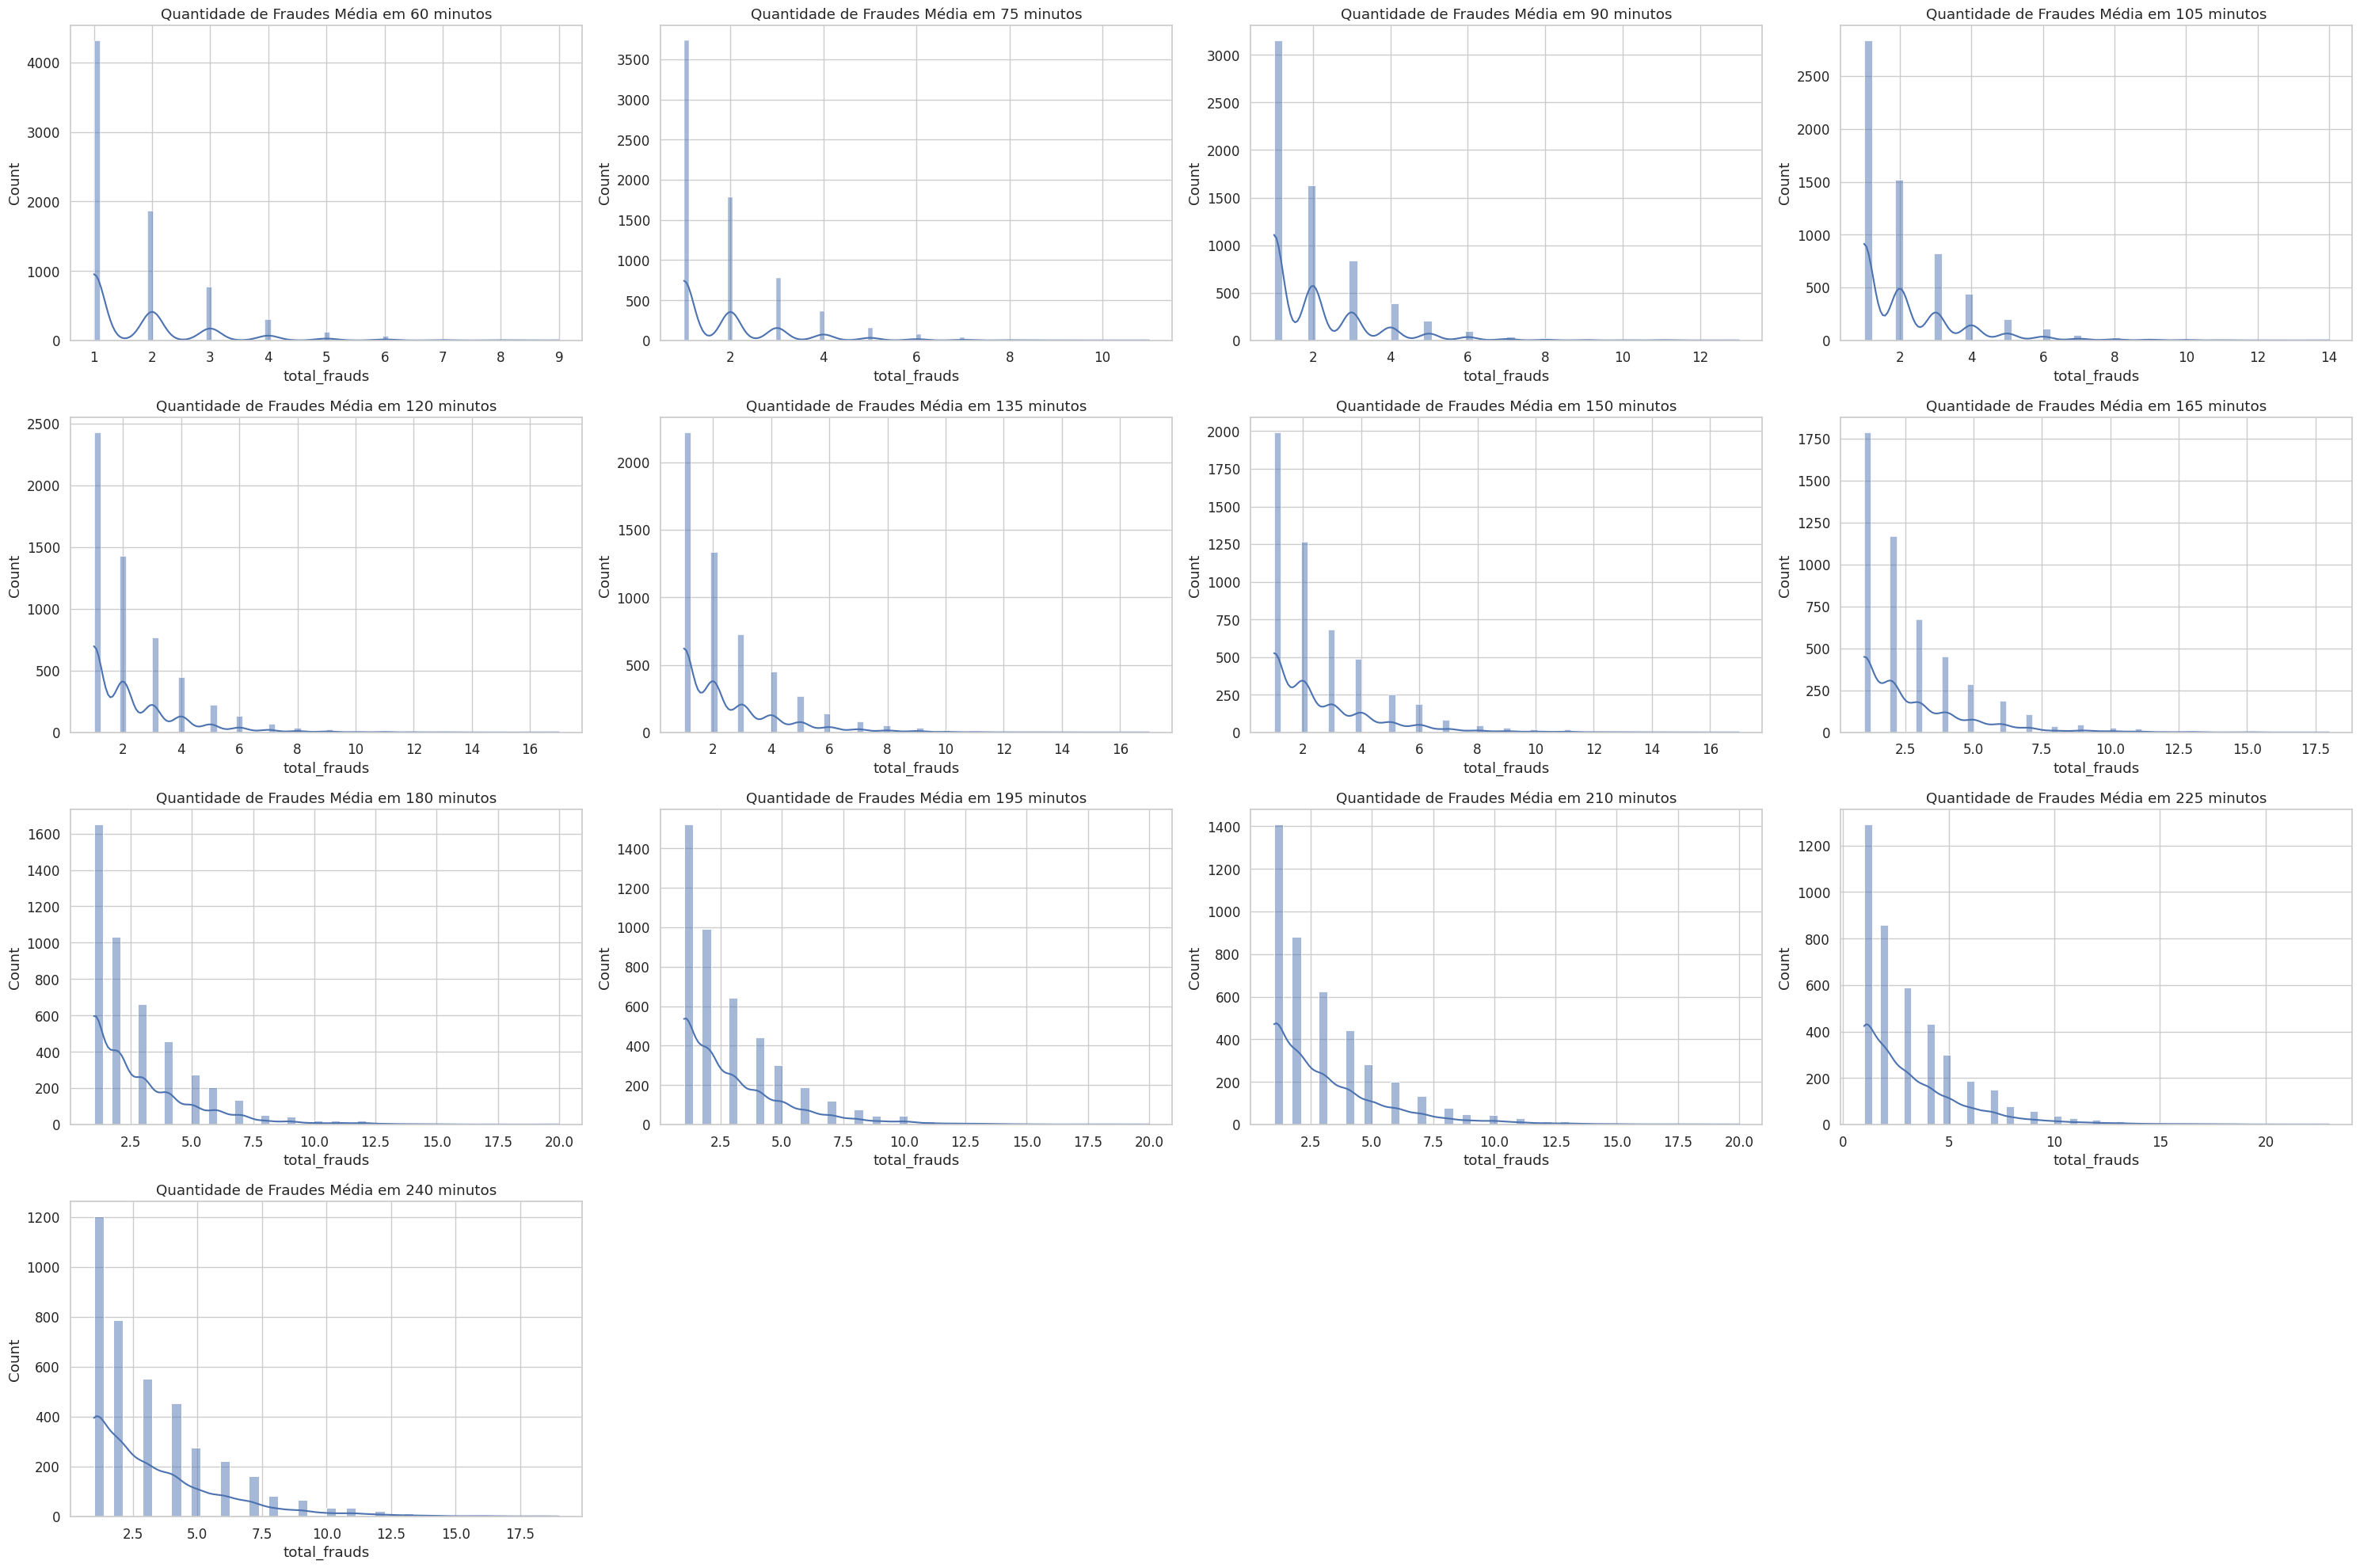

In [48]:
minutes = [60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240]#[120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440]
df_time = df.to_pandas()

# Define n√∫mero de colunas
cols = 4
# Calcula n√∫mero de linhas necess√°rias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes M√©dia em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

### Valida√ß√£o com modelos dummies

In [49]:
%%time

builders = []

for minute in tqdm(minutes, desc='Validando periodos'):

  feature_engineering = FraudFeatureEngineer(freq=f'{minute}T')
  df_train = feature_engineering.engineer_features(df.to_pandas(), debug=False)

  builder = BaselineCountingModel(df_train, f'{minute}m', offset=df_train['duration_sec'])
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 17min 14s, sys: 3min 31s, total: 20min 46s
Wall time: 14min 2s


In [50]:
df_report = pd.concat(list(map(lambda x: x.get_report(), builders)))
df_report.sort_values(by=['LLF'], inplace=True, ascending=False)
df_report.reset_index(drop=True, inplace=True)
df_report

window         model_name           LLF            BIC           AIC  \
0    240m  Binomial Negativa -18326.590286   36673.136556  36657.180572   
1    225m  Binomial Negativa -18891.977825   37804.040669  37787.955649   
2    240m                ZIP -19060.382600   38140.721184  38124.765200   
3    210m               ZINB -19337.554004   38705.442560  38681.108008   
4    210m  Binomial Negativa -19515.557687   39051.338409  39035.115374   
5    225m                ZIP -19747.565201   39515.215423  39499.130402   
6    210m                ZIP -20191.755406   40403.733847  40387.510812   
7    195m  Binomial Negativa -20303.753591   40627.878416  40611.507183   
8    180m               ZINB -20998.811182   42028.419351  42003.622363   
9    195m                ZIP -21050.007274   42120.385782  42104.014548   
10   180m  Binomial Negativa -21141.108690   42302.748706  42286.217381   
11   180m                ZIP -21803.703605   43627.938536  43611.407211   
12   165m               ZINB -21939.187781   43909.433513  43884.375561   
13   165m  Binomial Negativa -22074.146267   44168.997836  44152.292535   
14   165m                ZIP -22703.532141   45427.769584  45411.064283   
15   150m  Binomial Negativa -23183.921039   46388.738000  46371.842078   
16   150m                ZIP -23733.494839   47487.885599  47470.989677   
17   135m  Binomial Negativa -24349.935219   48720.977110  48703.870439   
18   135m                ZIP -24855.995594   49733.097859  49715.991187   
19   120m               ZINB -25468.582686   50969.178720  50943.165372   
20   120m  Binomial Negativa -25579.940191   51181.222614  51163.880382   
21   120m                ZIP -26065.679492   52152.701216  52135.358984   
22   105m               ZINB -27135.031519   54302.476970  54276.063037   
23   105m  Binomial Negativa -27252.887051   54527.383391  54509.774103   
24   105m                ZIP -27568.956497   55159.522283  55141.912994   
25    90m               ZINB -28990.745215   58014.366806  57987.490429   
26    90m  Binomial Negativa -29101.111724   58224.141032  58206.223447   
27    90m                ZIP -29360.132330   58742.182244  58724.264659   
28   240m            Poisson -30836.832927 -164435.475778  61675.665853   
29    75m               ZINB -31425.992515   62885.408354  62857.985030   
30   225m            Poisson -31465.326406 -179235.415575  62932.652811   
31    75m  Binomial Negativa -31519.883647   63062.049509  63043.767294   
32    75m                ZIP -31707.669627   63437.621469  63419.339254   
33   210m            Poisson -31925.868199 -196781.124211  63853.736398   
34   195m            Poisson -32495.467050 -217142.210616  64992.934100   
35   180m            Poisson -33044.178617 -241246.582799  66090.357234   
36   165m            Poisson -33704.587709 -269883.584062  67411.175417   
37    60m               ZINB -34163.567240   68361.227234  68333.134480   
38    60m  Binomial Negativa -34246.843793   68516.416089  68497.687586   
39   150m            Poisson -34358.090719 -304833.592696  68718.181437   
40    60m                ZIP -34379.470489   68781.669481  68762.940979   
41   135m            Poisson -35201.203248 -347710.030175  70404.406496   
42   120m            Poisson -36279.864649 -401620.478195  72561.729298   
43   105m            Poisson -37234.900853 -472707.687504  74471.801706   
44    90m            Poisson -38582.582516 -568265.060757  77167.165033   
45    75m            Poisson -40100.996042 -704690.843946  80203.992083   
46    60m            Poisson -42271.186416 -912492.977550  84544.372832   
47   135m               ZINB           NaN            NaN           NaN   
48   150m               ZINB           NaN            NaN           NaN   
49   195m               ZINB           NaN            NaN           NaN   
50   225m               ZINB           NaN            NaN           NaN   
51   240m               ZINB           NaN            NaN           NaN   

    Converged  RMSE_Pearson

In [51]:
df_best_report = df_report.query('Best == True').groupby(by='model_name').agg(window_count=('window', 'count'), bic=('BIC', 'min')).reset_index().sort_values('window_count', ascending=False).reset_index(drop=True)
df_best_report

model_name  window_count            bic
0            Poisson             8 -912492.977550
1  Binomial Negativa             3   36673.136556
2               ZINB             2   38705.442560

In [52]:
df_best_report_index = df_report[(df_report['Best'] == True) & (df_report['model_name'] == df_best_report.loc[0, 'model_name'])].sort_values('BIC', ascending=True).reset_index(drop=True)
df_best_report_index

window model_name           LLF            BIC           AIC  Converged  \
0    60m    Poisson -42271.186416 -912492.977550  84544.372832       True   
1    75m    Poisson -40100.996042 -704690.843946  80203.992083       True   
2    90m    Poisson -38582.582516 -568265.060757  77167.165033       True   
3   105m    Poisson -37234.900853 -472707.687504  74471.801706       True   
4   120m    Poisson -36279.864649 -401620.478195  72561.729298       True   
5   135m    Poisson -35201.203248 -347710.030175  70404.406496       True   
6   150m    Poisson -34358.090719 -304833.592696  68718.181437       True   
7   165m    Poisson -33704.587709 -269883.584062  67411.175417       True   

   RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  Dispersion  \
0      1.503266    7485.0        8.684806        3.672333    2.259836   
1      1.572771    3230.0        4.684690        4.684690    2.473646   
2      1.661930    3254.0        5.663366        5.663366    2.762058   
3      1.724964    3220.0        6.538204        6.538204    2.975560   
4      1.820367    3183.0        7.386350        7.386350    3.313813   
5      1.857705    3137.0        8.189531        4.696515    3.451160   
6      1.912837    3097.0        8.983582        5.311249    3.659053   
7      1.976458    3011.0        9.607530        6.043395    3.906511   

   df_resid      PseudoR2  RankApplied  Best  
0   86184.0  0.000000e+00         True  True  
1   68947.0  2.220446e-16         True  True  
2   57456.0  0.000000e+00         True  True  
3   49248.0  0.000000e+00         True  True  
4   43092.0  6.661338e-16         True  True  
5   38304.0  3.330669e-16         True  True  
6   34473.0  0.000000e+00         True  True  
7   31339.0  4.440892e-16         True  True

### Sele√ß√£o da melhor janela de tempo

In [53]:
selected_builder = list(filter(lambda x: x.window == df_best_report_index.loc[0, 'window'], builders))[0]
selected_builder.get_report(criterion='BIC')

window         model_name           LLF            BIC           AIC  \
0    60m            Poisson -42271.186416 -912492.977550  84544.372832   
1    60m               ZINB -34163.567240   68361.227234  68333.134480   
2    60m  Binomial Negativa -34246.843793   68516.416089  68497.687586   
3    60m                ZIP -34379.470489   68781.669481  68762.940979   

   Converged  RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  \
0       True      1.503266      7485        8.684806        3.672333   
1       True      1.000176      3165        3.672333        3.672333   
2       True      0.952243      3165        3.672333        3.672333   
3       True      1.050249      3165        3.672333        3.672333   

   Dispersion  df_resid      PseudoR2  RankApplied   Best  
0    2.259836   86184.0  0.000000e+00         True   True  
1    1.000363   86184.0 -1.087800e-08         True  False  
2    0.906777   86184.0 -2.298322e-10         True  False  
3    1.103035   86184.0 -2.359528e-10         True  False

#### Visualiza√ß√£o da distribui√ß√£o observada dos eventos X modelo dummy

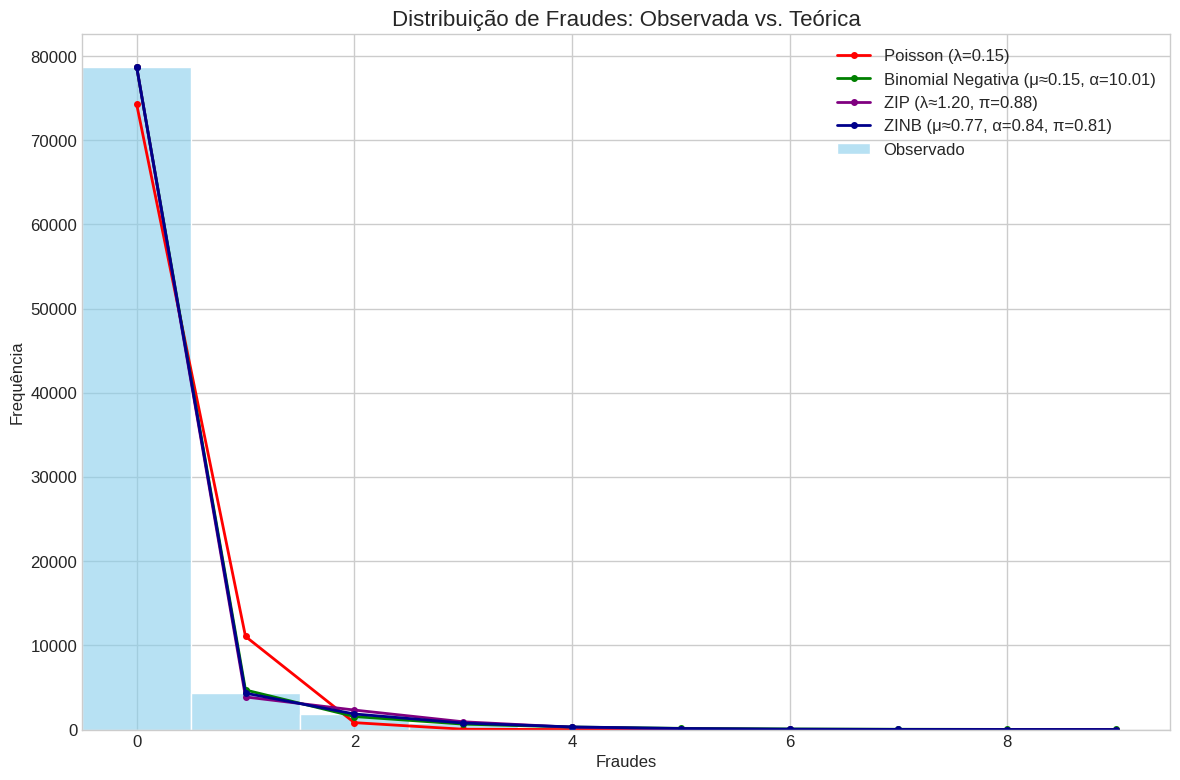

In [54]:
selected_builder.plot_theoretical_distributions()

In [55]:
selected_builder.df.head()

total_transactions  total_amount  chip_ratio  \
2010-01-01 00:00:00                24.0        764.07         0.0   
2010-01-01 01:00:00                21.0       1141.25         0.0   
2010-01-01 02:00:00                25.0       1028.01         0.0   
2010-01-01 03:00:00                20.0        861.65         0.0   
2010-01-01 04:00:00                16.0        598.12         0.0   

                     duration_sec  transactions_per_seconds  \
2010-01-01 00:00:00        3600.0                  0.006667   
2010-01-01 01:00:00        3600.0                  0.005833   
2010-01-01 02:00:00        3600.0                  0.006944   
2010-01-01 03:00:00        3600.0                  0.005556   
2010-01-01 04:00:00        3600.0                  0.004444   

                     avg_transactions_value  geo_dispersion  merchant_entropy  \
2010-01-01 00:00:00               31.836250       23.862712          2.773718   
2010-01-01 01:00:00               54.345238       21.905780          2.912494   
2010-01-01 02:00:00               41.120400       27.195229          3.107972   
2010-01-01 03:00:00               43.082500       17.409498          2.926418   
2010-01-01 04:00:00               37.382500       19.956495          2.772589   

                     avg_credit_score  error_ratio  ...  hour_cos   day_sin  \
2010-01-01 00:00:00        735.416667          0.0  ...  1.000000 -0.433884   
2010-01-01 01:00:00        737.000000          0.0  ...  0.965926 -0.433884   
2010-01-01 02:00:00        726.120000          0.0  ...  0.866025 -0.433884   
2010-01-01 03:00:00        716.600000          0.0  ...  0.707107 -0.433884   
2010-01-01 04:00:00        678.375000          0.0  ...  0.500000 -0.433884   

                      day_cos  is_holiday  change_volume_transaction  \
2010-01-01 00:00:00 -0.900969           1                   0.000000   
2010-01-01 01:00:00 -0.900969           1                  -0.125000   
2010-01-01 02:00:00 -0.900969           1                   0.190476   
2010-01-01 03:00:00 -0.900969           1                  -0.200000   
2010-01-01 04:00:00 -0.900969           1                  -0.200000   

                     velocity_alert  unique_clients  unique_cards  \
2010-01-01 00:00:00               0            22.0          23.0   
2010-01-01 01:00:00               0            19.0          20.0   
2010-01-01 02:00:00               0            25.0          25.0   
2010-01-01 03:00:00               0            19.0          19.0   
2010-01-01 04:00:00               0            16.0          16.0   

                     cards_per_client  frauds  
2010-01-01 00:00:00          1.045455     0.0  
2010-01-01 01:00:00          1.052632     0.0  
2010-01-01 02:00:00          1.000000     0.0  
2010-01-01 03:00:00          1.000000     0.0  
2010-01-01 04:00:00          1.000000     0.0  

[5 rows x 21 columns]

In [56]:
selected_builder.df.describe()

total_transactions  total_amount    chip_ratio  duration_sec  \
count        86185.000000  86185.000000  86185.000000       86185.0   
mean            98.302605   4968.652653      0.342922        3600.0   
std             58.856132   2769.834769      0.352127           0.0   
min              0.000000      0.000000      0.000000        3600.0   
25%             31.000000   2059.280000      0.000000        3600.0   
50%             90.000000   5114.430000      0.000000        3600.0   
75%            155.000000   7158.240000      0.703030        3600.0   
max            236.000000  15886.490000      1.000000        3600.0   

       transactions_per_seconds  avg_transactions_value  geo_dispersion  \
count              86185.000000            86185.000000    86185.000000   
mean                   0.027306               54.571392       21.168373   
std                    0.016349               19.311455        2.123850   
min                    0.000000               12.864615        0.000000   
25%                    0.008611               44.673154       20.042187   
50%                    0.025000               52.698500       21.074632   
75%                    0.043056               60.985233       22.128983   
max                    0.065556             1501.560000       36.481211   

       merchant_entropy  avg_credit_score   error_ratio  ...      hour_cos  \
count      86185.000000      86185.000000  86185.000000  ...  8.618500e+04   
mean           3.810124        714.362689      0.016346  ...  1.160295e-05   
std            0.587096          9.429410      0.018206  ...  7.071150e-01   
min            0.000000        651.000000      0.000000  ... -1.000000e+00   
25%            3.249127        708.826531      0.000000  ... -7.071068e-01   
50%            4.054709        714.397727      0.012579  ...  6.123234e-17   
75%            4.244109        719.666667      0.024691  ...  7.071068e-01   
max            4.752355        788.000000      0.250000  ...  1.000000e+00   

            day_sin       day_cos    is_holiday  change_volume_transaction  \
count  86185.000000  86185.000000  86185.000000               8.618500e+04   
mean      -0.000005     -0.000010      0.027012                        inf   
std        0.707108      0.707113      0.162118                        NaN   
min       -0.974928     -0.900969      0.000000              -1.000000e+00   
25%       -0.781831     -0.900969      0.000000              -1.361257e-01   
50%        0.000000     -0.222521      0.000000              -1.052632e-02   
75%        0.781831      0.623490      0.000000               1.250000e-01   
max        0.974928      1.000000      1.000000                        inf   

       velocity_alert  unique_clients  unique_cards  cards_per_client  \
count    86185.000000    86185.000000  86185.000000      86185.000000   
mean         0.000104       87.654453     91.531879          1.036567   
std          0.010218       50.858006     53.840308          0.033990   
min          0.000000        0.000000      0.000000          0.000000   
25%          0.000000       29.000000     30.000000          1.014493   
50%          0.000000       82.000000     84.000000          1.038095   
75%          0.000000      136.000000    143.000000          1.054795   
max          1.000000      198.000000    213.000000          1.250000   

             frauds  
count  86185.000000  
mean       0.149005  
std        0.580282  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        9.000000  

[8 rows x 21 columns]

#### Correla√ß√£o dos dados no dataframe da janela selecionada

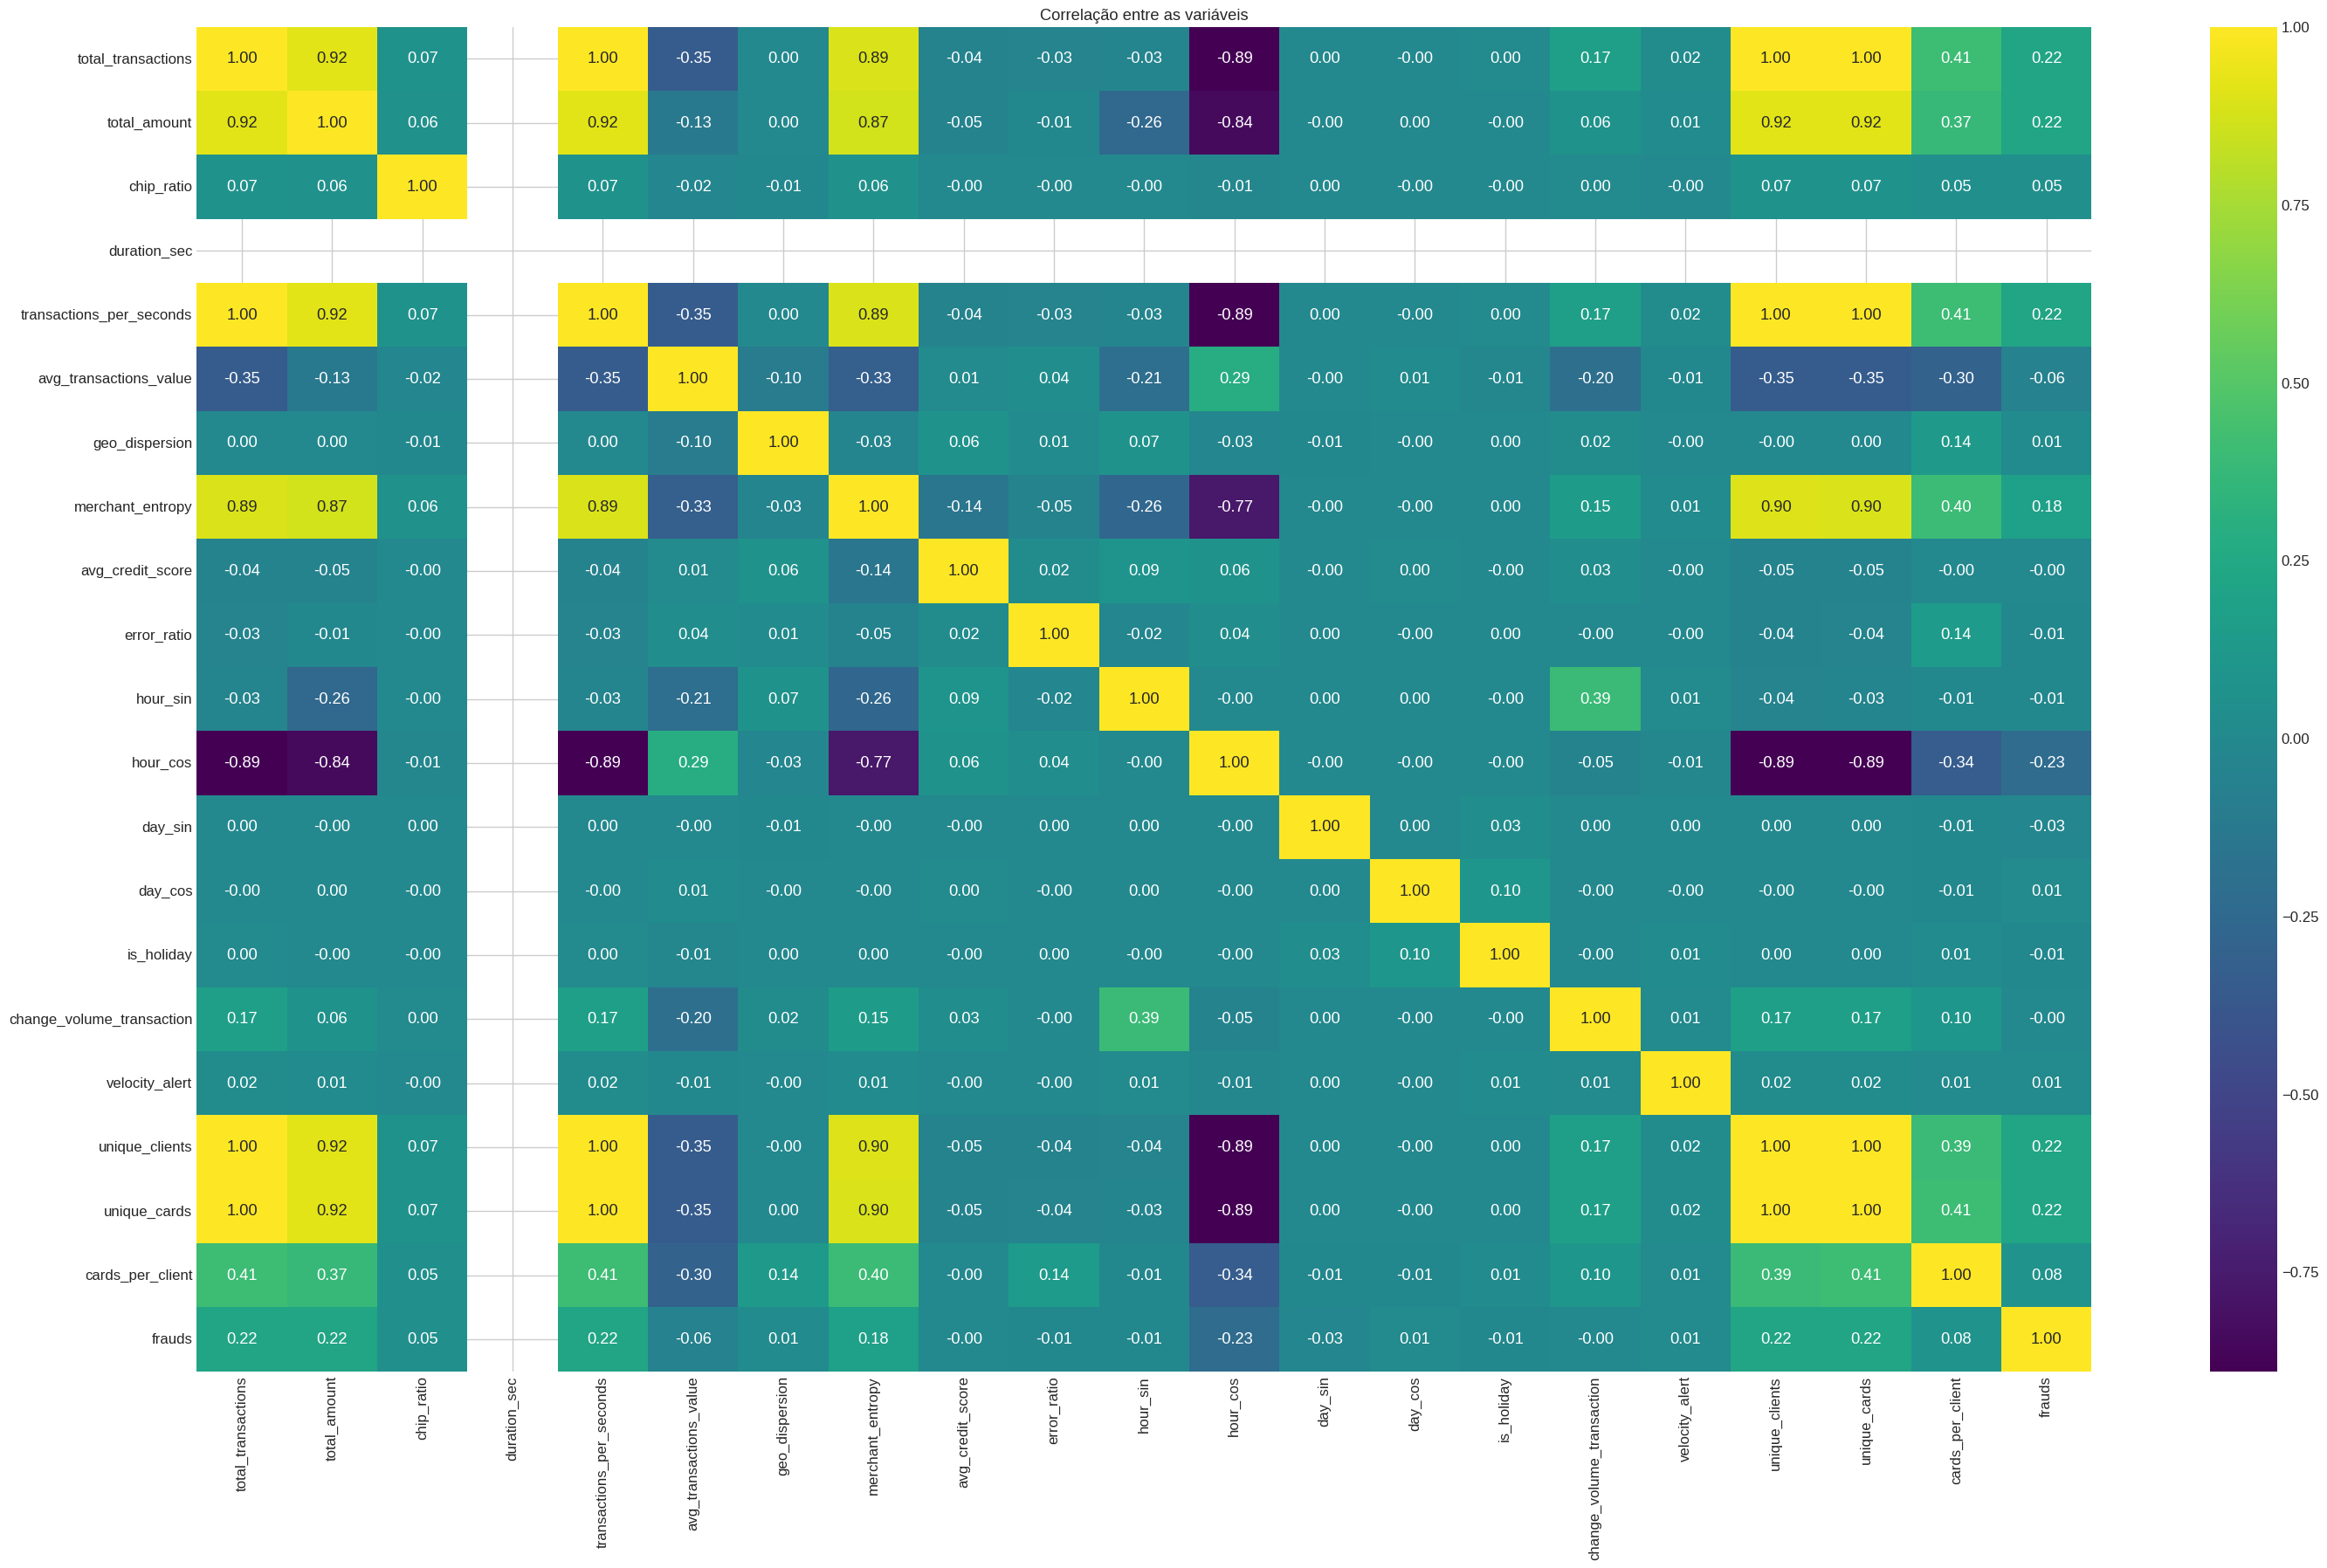

In [57]:
corr = selected_builder.df.corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correla√ß√£o entre as vari√°veis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

##### Remo√ß√£o de colunas com alta correla√ß√£o

In [64]:
remove_columns = remove_highly_correlated_features(selected_builder.df, 0.85)
# remove_columns.pop(remove_columns.index('hour_cos'))
remove_columns.append('change_volume_transaction')
remove_columns

['merchant_entropy',
 'unique_cards',
 'transactions_per_seconds',
 'total_transactions',
 'unique_clients',
 'change_volume_transaction']

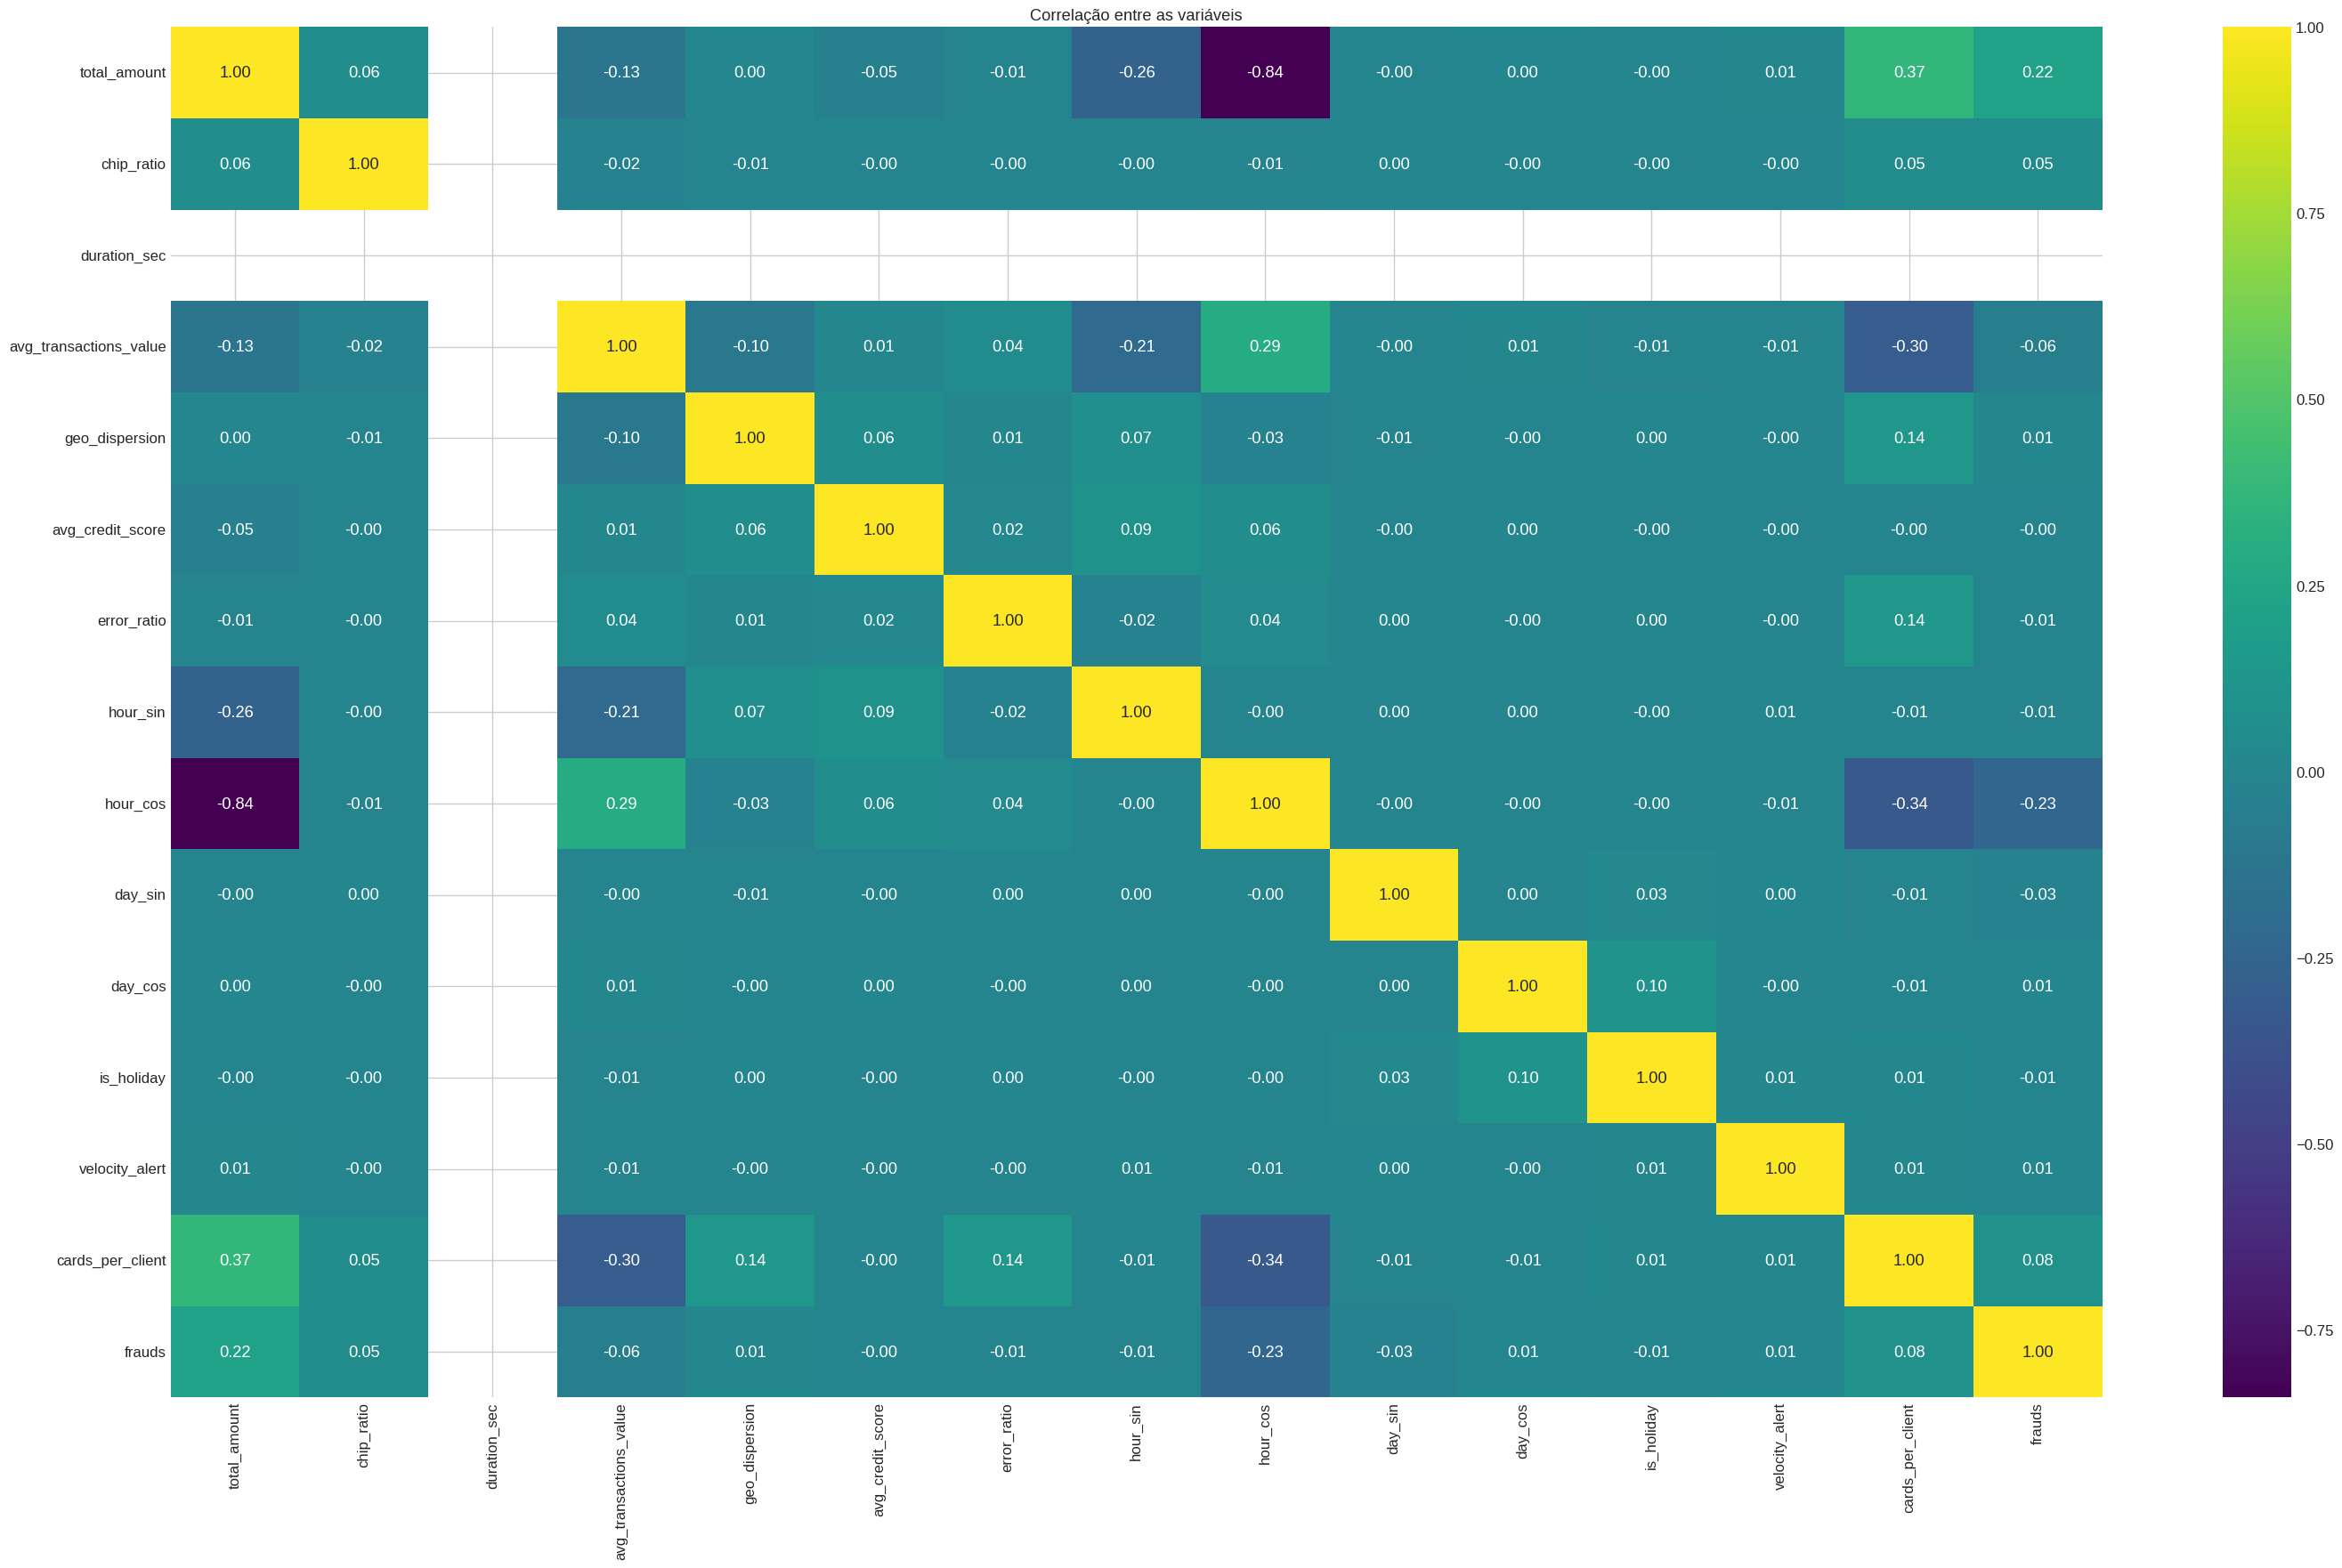

In [65]:
corr = selected_builder.df.drop(columns=remove_columns).corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correla√ß√£o entre as vari√°veis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Modelagem

### **M√©tricas de Avalia√ß√£o de Modelos: LLF, AIC e BIC**

Estas m√©tricas s√£o usadas para avaliar e comparar modelos estat√≠sticos, buscando um equil√≠brio entre o bom ajuste aos dados e a simplicidade do modelo.

---

### **1. LLF (Log-Likelihood Function / Fun√ß√£o de Log-Verossimilhan√ßa)**

Mede o qu√£o bem o modelo se ajusta aos dados observados.

* **Foco:** Apenas na qualidade do ajuste.
* **Interpreta√ß√£o:** Quanto **maior** o valor, melhor o modelo explica os dados.
* **Limita√ß√£o:** N√£o penaliza a complexidade. Modelos mais complexos quase sempre ter√£o uma LLF maior.

---

### **2. AIC (Akaike Information Criterion / Crit√©rio de Informa√ß√£o de Akaike)**

Busca um equil√≠brio entre a qualidade do ajuste (LLF) e a complexidade do modelo (n√∫mero de par√¢metros).

* **F√≥rmula:** $$\text{AIC} = 2k - 2 \ln(\hat{L})$$
  * $k$: n√∫mero de par√¢metros do modelo.
  * $\ln(\hat{L})$: valor da Log-Verossimilhan√ßa.
* **Foco:** Encontrar o melhor modelo para previs√µes.
* **Interpreta√ß√£o:** O modelo com o **menor** valor de AIC √© prefer√≠vel.

---

### **3. BIC (Bayesian Information Criterion / Crit√©rio de Informa√ß√£o Bayesiano)**

Similar ao AIC, mas aplica uma penalidade mais rigorosa √† complexidade, especialmente para grandes volumes de dados.

* **F√≥rmula:**
    $$ \text{BIC} = \ln(n)k - 2 \ln(\hat{L}) $$
    * $n$: n√∫mero de observa√ß√µes (tamanho da amostra).
    * $k$: n√∫mero de par√¢metros do modelo.
    * $\ln(\hat{L})$: valor da Log-Verossimilhan√ßa.
* **Foco:** Encontrar o modelo mais prov√°vel de ser o "verdadeiro" gerador dos dados.
* **Interpreta√ß√£o:** O modelo com o **menor** valor de BIC √© prefer√≠vel. Geralmente, seleciona modelos mais simples que o AIC.

---

### **Tabela Resumo**

| M√©trica | Foco Principal | Interpreta√ß√£o |
| :--- | :--- | :--- |
| **LLF** | Qualidade do ajuste | Quanto **maior**, melhor |
| **AIC** | Equil√≠brio (Ajuste vs. Complexidade) | Quanto **menor**, melhor |
| **BIC** | Equil√≠brio (com maior penalidade √† complexidade) | Quanto **menor**, melhor |

In [66]:
X = selected_builder.df.drop(columns=remove_columns).dropna().copy() #selected_builder.df.copy()
y = X['frauds']

In [67]:
X.describe().T

count          mean          std          min  \
total_amount            86185.0  4.968653e+03  2769.834769     0.000000   
chip_ratio              86185.0  3.429223e-01     0.352127     0.000000   
duration_sec            86185.0  3.600000e+03     0.000000  3600.000000   
avg_transactions_value  86185.0  5.457139e+01    19.311455    12.864615   
geo_dispersion          86185.0  2.116837e+01     2.123850     0.000000   
avg_credit_score        86185.0  7.143627e+02     9.429410   651.000000   
error_ratio             86185.0  1.634579e-02     0.018206     0.000000   
hour_sin                86185.0 -1.846743e-17     0.707107    -1.000000   
hour_cos                86185.0  1.160295e-05     0.707115    -1.000000   
day_sin                 86185.0 -5.034330e-06     0.707108    -0.974928   
day_cos                 86185.0 -1.045389e-05     0.707113    -0.900969   
is_holiday              86185.0  2.701166e-02     0.162118     0.000000   
velocity_alert          86185.0  1.044265e-04     0.010218     0.000000   
cards_per_client        86185.0  1.036567e+00     0.033990     0.000000   
frauds                  86185.0  1.490050e-01     0.580282     0.000000   

                                25%           50%          75%           max  
total_amount            2059.280000  5.114430e+03  7158.240000  15886.490000  
chip_ratio                 0.000000  0.000000e+00     0.703030      1.000000  
duration_sec            3600.000000  3.600000e+03  3600.000000   3600.000000  
avg_transactions_value    44.673154  5.269850e+01    60.985233   1501.560000  
geo_dispersion            20.042187  2.107463e+01    22.128983     36.481211  
avg_credit_score         708.826531  7.143977e+02   719.666667    788.000000  
error_ratio                0.000000  1.257862e-02     0.024691      0.250000  
hour_sin                  -0.707107  0.000000e+00     0.707107      1.000000  
hour_cos                  -0.707107  6.123234e-17     0.707107      1.000000  
day_sin                   -0.781831  0.000000e+00     0.781831      0.974928  
day_cos                   -0.900969 -2.225209e-01     0.623490      1.000000  
is_holiday                 0.000000  0.000000e+00     0.000000      1.000000  
velocity_alert             0.000000  0.000000e+00     0.000000      1.000000  
cards_per_client           1.014493  1.038095e+00     1.054795      1.250000  
frauds                     0.000000  0.000000e+00     0.000000      9.000000

In [68]:
y.value_counts()

frauds
0.0    78700
1.0     4320
2.0     1865
3.0      776
4.0      309
5.0      119
6.0       61
7.0       18
8.0       12
9.0        5
Name: count, dtype: int64

### Modelo de Regress√£o de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regress√£o de Poisson** √© um modelo da fam√≠lia dos **Modelos Lineares Generalizados (GLMs)**, apropriado para vari√°veis dependentes representadas por **contagens**, ou seja, n√∫meros inteiros n√£o negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espa√ßo.

---

### Estrutura dos Dados

Vari√°veis de contagem apresentam as seguintes caracter√≠sticas:

- Assumem valores inteiros e n√£o negativos: $0, 1, 2, \dots$.
- Representam frequ√™ncias de ocorr√™ncia de um evento.
- Apresentam, sob hip√≥tese da Poisson, **m√©dia e vari√¢ncia iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribui√ß√£o de Poisson

A vari√°vel aleat√≥ria $Y$ segue uma distribui√ß√£o de Poisson quando sua probabilidade de assumir o valor $k$ √© dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ √© o par√¢metro da distribui√ß√£o, que representa a m√©dia e a vari√¢ncia;
- $e$ √© a base do logaritmo natural;
- $k!$ √© o fatorial de $k$.

---

### Formula√ß√£o da Regress√£o de Poisson

A regress√£o de Poisson modela o valor esperado da vari√°vel dependente $Y_i$ como uma fun√ß√£o exponencial de uma combina√ß√£o linear de vari√°veis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a m√©dia condicional esperada da vari√°vel resposta √© dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispers√£o

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equil√≠brio entre m√©dia e vari√¢ncia √© conhecido como **equidispers√£o**. Caso essa condi√ß√£o n√£o seja atendida (por exemplo, se a vari√¢ncia for significativamente maior que a m√©dia), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpreta√ß√£o dos Coeficientes

Os coeficientes $\beta_j$ da regress√£o de Poisson s√£o interpretados em termos da **raz√£o de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorr√™ncia $\lambda_i$ √© multiplicada a cada aumento unit√°rio em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estima√ß√£o

A estima√ß√£o dos par√¢metros do modelo √© realizada por **m√°xima verossimilhan√ßa**, considerando a fun√ß√£o de verossimilhan√ßa derivada da distribui√ß√£o de Poisson. A converg√™ncia do modelo depende da estrutura dos dados e da aus√™ncia de sobredispers√£o relevante.


#### Valida√ß√£o de presuposto

Os dados devem apresentar **equidispers√£o**, ou seja, m√©dia igual a vari√¢ncia.

In [69]:
pd.DataFrame({'M√©dia':[y.mean()],'Vari√¢ncia':[y.var()]})

M√©dia  Vari√¢ncia
0  0.149005   0.336727

Existe uma diferen√ßa muito grande entre a m√©dia e a variancia referente a vari√°vel alvo, indicando poss√≠vel subdispers√£o nos dados.

#### Implementa√ß√£o dos modelos

##### Completo

In [70]:
formula = "frauds ~ " + ' + '.join(X.drop(columns=['frauds', 'duration_sec']).columns)
formula

'frauds ~ total_amount + chip_ratio + avg_transactions_value + geo_dispersion + avg_credit_score + error_ratio + hour_sin + hour_cos + day_sin + day_cos + is_holiday + velocity_alert + cards_per_client'

In [71]:
modelo_poisson  = smf.glm(formula=formula, data=X, family=sm.families.Poisson(), offset=np.log(X['duration_sec'])).fit()

In [72]:
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86185
Model:                            GLM   Df Residuals:                    86171
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35883.
Date:                Mon, 08 Sep 2025   Deviance:                       54147.
Time:                        02:38:22   Pearson chi2:                 1.54e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1378
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.7686      1.061     -3.553      0.000      -5.848      -1.690
total_amount               0.0002   8.01e-06     20.299      0.000       0.000       0.000
chip_ratio                 0.4502      0.026     17.516      0.000       0.400       0.501
avg_transactions_value    -0.0112      0.001     -8.305      0.000      -0.014      -0.009
geo_dispersion            -0.0075      0.007     -1.141      0.254      -0.020       0.005
avg_credit_score          -0.0083      0.001     -6.036      0.000      -0.011      -0.006
error_ratio                1.2207      0.760      1.607      0.108      -0.268       2.709
hour_sin                  -0.0320      0.018     -1.808      0.071      -0.067       0.003
hour_cos                  -1.1303      0.033    -33.961      0.000      -1.196      -1.065
day_sin                   -0.1408      0.013    -11.238      0.000      -0.165      -0.116
day_cos                    0.0343      0.013      2.723      0.006       0.010       0.059
is_holiday                -0.1128      0.058     -1.934      0.053      -0.227       0.002
velocity_alert             0.3338      0.448      0.746      0.456      -0.544       1.211
cards_per_client          -1.2052      0.395     -3.051      0.002      -1.979      -0.431
==========================================================================================
"""

In [73]:
overdisp_plot_enhanced(modelo_poisson, 'Poison - Completo')

KeyboardInterrupt: 

Family poisson



# Diagn√≥stico RQR ‚Äî Modelo Poisson

**N√≠vel de signific√¢ncia:** _Œ± = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| M√©dia = 0 | NOK |
| Vari√¢ncia = 1 | NOK |
| Independ√™ncia (Ljung‚ÄìBox) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padr√£o r¬≤~Œº) | NOK |
| Dispers√£o global (œÜÃÇ, Pearson) | NOK |


## 1) Normalidade
| Teste | Estat√≠stica | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro‚ÄìWilk | 0.9801 | 5.642e-70 | NOK |
| Jarque‚ÄìBera  | 13987.60 | 0.000e+00 | NOK |

## 2) Localiza√ß√£o e Escala
| Medida | Valor |
|---|---:|
| M√©dia (E[r]) | -0.028380 |
| Desvio-padr√£o (SD[r]) | 1.067415 |

| Teste | Hip√≥tese | Estat√≠stica | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (m√©dia=0) | H‚ÇÄ: E[r]=0 | -7.805 | 6.003e-15 | NOK |
| œá¬≤ (var=1) | H‚ÇÄ: Var[r]=1 | 98195.88 | 0.000e+00 | NOK |

## 3) Independ√™ncia (Ljung‚ÄìBox)
| Estat√≠stica Q | p-valor | Resultado |
|---:|---:|:--:|
| 7133.446 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padr√£o r¬≤ ~ Œº)
| Coef. de Œº | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.983108 | 17.342 | 2.253e-67 | NOK |

## 5) Dispers√£o Global (Escala)
| Estat√≠stica | df | œÜÃÇ | p(two-sided) | Resultado | Observa√ß√£o |
|---:|---:|---:|---:|:--:|---|
| 153801.94 | 86171 | 1.7848 | 0.000e+00 | NOK | Superdispers√£o (œÜÃÇ>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)‚âà4.55%, P(|r|>3)‚âà0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 5140 | 7.083e-81 | NOK |
| |r| > 3 | 1127 | 0.000e+00 | NOK |

---
### Interpreta√ß√£o r√°pida
- Normalidade: NOK; M√©dia/Vari√¢ncia: NOK; Independ√™ncia: NOK; Caudas: NOK.
- Heterocedasticidade (r¬≤~Œº): NOK.
- Dispers√£o global: NOK (Superdispers√£o (œÜÃÇ>1)).


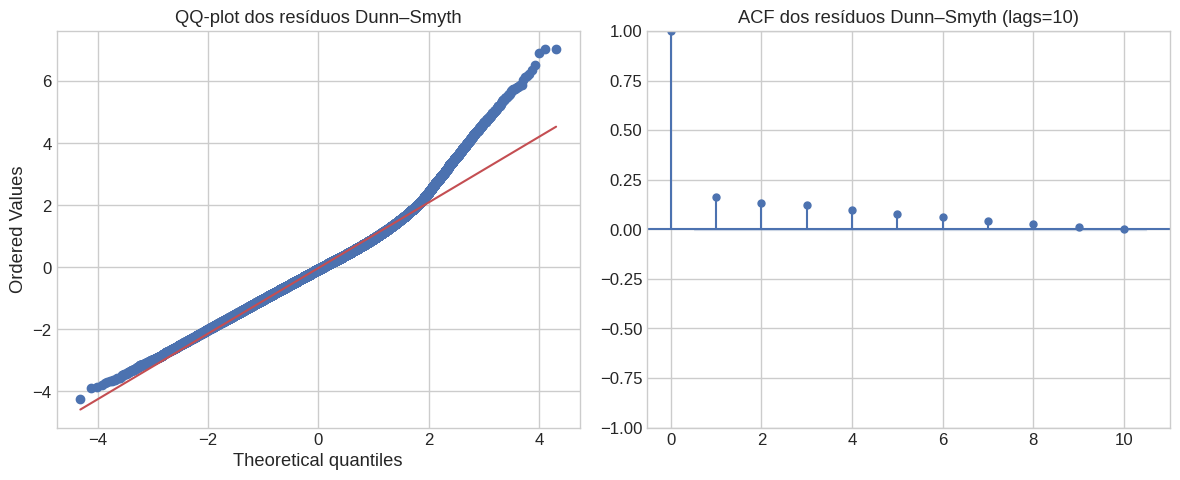

In [74]:
rqr = compute_rqr(modelo_poisson, y, family='auto', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_poisson),
    resid_pearson=modelo_poisson.resid_pearson,
    df_resid=modelo_poisson.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Modelo Poisson",
    alpha=0.05,
    acf_lags=10
)

O gr√°fico indica que o modelo Poisson tem dificuldade em capturar a variabilidade: observa-se um forte ‚Äúfunil‚Äù, violando o pressuposto de equidispers√£o (res√≠duos com vari√¢ncia crescente). A suaviza√ß√£o √© nitidamente descendente, sinal de vi√©s: o modelo tende a superestimar para Œº altos e subestimar quando Œº √© baixo. H√° muitos res√≠duos |r|>2, especialmente em Œº<3, sugerindo heterogeneidade/zeros n√£o explicados.

In [75]:
overdisp(modelo_poisson, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.007      
Dependent Variable:     ystar            AIC:                         623496.2266
Date:                   2025-09-08 02:39 BIC:                         623505.5908
No. Observations:       86185            Log-Likelihood:              -3.1175e+05
Df Model:               1                F-statistic:                 626.6      
Df Residuals:           86184            Prob (F-statistic):          8.38e-138  
R-squared (uncentered): 0.007            Scale:                       81.167     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.6043         0.1440       25.0328       0.0000       3.3221    

O teste evidencia o ponto j√° validado inicialmente do presuposto. O modelo n√£o atende a capacidade de overdispersion.

##### Stepwise

In [76]:
modelo_poisson_stepwise = stepwise(modelo_poisson, pvalue_limit=0.05)
modelo_poisson_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('velocity_alert') + Q('cards_per_client')

 Family type...: 
 Poisson

 Discarding atribute "Q('velocity_alert')" with p-value equal to 0.4559125668609364 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('cards_per_client')

 Family type...: 
 Poisson

 Discarding atribute "Q('geo_dispersion')" with p-value equal to 0.25122333070659886 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86185
Model:                            GLM   Df Residuals:                    86176
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35888.
Date:                Mon, 08 Sep 2025   Deviance:                       54158.
Time:                        02:39:20   Pearson chi2:                 1.52e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1377
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.1217      1.055      3.905      0.000       2.053       6.190
Q('total_amount')               0.0002   7.96e-06     20.531      0.000       0.000       0.000
Q('chip_ratio')                 0.4501      0.026     17.520      0.000       0.400       0.500
Q('avg_transactions_value')    -0.0100      0.001     -8.508      0.000      -0.012      -0.008
Q('avg_credit_score')          -0.0082      0.001     -5.994      0.000      -0.011      -0.006
Q('hour_cos')                  -1.1272      0.033    -33.992      0.000      -1.192      -1.062
Q('day_sin')                   -0.1414      0.013    -11.282      0.000      -0.166      -0.117
Q('day_cos')                    0.0314      0.012      2.509      0.012       0.007       0.056
Q('cards_per_client')          -1.1900      0.395     -3.014      0.003      -1.964      -0.416
===============================================================================================
"""

In [77]:
overdisp_plot_enhanced(modelo_poisson_stepwise, 'Poison - Stepwise')

KeyboardInterrupt: 

Family poisson



# Diagn√≥stico RQR ‚Äî Modelo Poisson Stepwise

**N√≠vel de signific√¢ncia:** _Œ± = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| M√©dia = 0 | NOK |
| Vari√¢ncia = 1 | NOK |
| Independ√™ncia (Ljung‚ÄìBox) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padr√£o r¬≤~Œº) | NOK |
| Dispers√£o global (œÜÃÇ, Pearson) | NOK |


## 1) Normalidade
| Teste | Estat√≠stica | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro‚ÄìWilk | 0.9801 | 6.710e-70 | NOK |
| Jarque‚ÄìBera  | 13884.49 | 0.000e+00 | NOK |

## 2) Localiza√ß√£o e Escala
| Medida | Valor |
|---|---:|
| M√©dia (E[r]) | -0.028362 |
| Desvio-padr√£o (SD[r]) | 1.067403 |

| Teste | Hip√≥tese | Estat√≠stica | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (m√©dia=0) | H‚ÇÄ: E[r]=0 | -7.800 | 6.236e-15 | NOK |
| œá¬≤ (var=1) | H‚ÇÄ: Var[r]=1 | 98193.69 | 0.000e+00 | NOK |

## 3) Independ√™ncia (Ljung‚ÄìBox)
| Estat√≠stica Q | p-valor | Resultado |
|---:|---:|:--:|
| 7144.388 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padr√£o r¬≤ ~ Œº)
| Coef. de Œº | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.984445 | 17.383 | 1.104e-67 | NOK |

## 5) Dispers√£o Global (Escala)
| Estat√≠stica | df | œÜÃÇ | p(two-sided) | Resultado | Observa√ß√£o |
|---:|---:|---:|---:|:--:|---|
| 152091.14 | 86176 | 1.7649 | 0.000e+00 | NOK | Superdispers√£o (œÜÃÇ>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)‚âà4.55%, P(|r|>3)‚âà0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 5132 | 6.361e-80 | NOK |
| |r| > 3 | 1124 | 0.000e+00 | NOK |

---
### Interpreta√ß√£o r√°pida
- Normalidade: NOK; M√©dia/Vari√¢ncia: NOK; Independ√™ncia: NOK; Caudas: NOK.
- Heterocedasticidade (r¬≤~Œº): NOK.
- Dispers√£o global: NOK (Superdispers√£o (œÜÃÇ>1)).


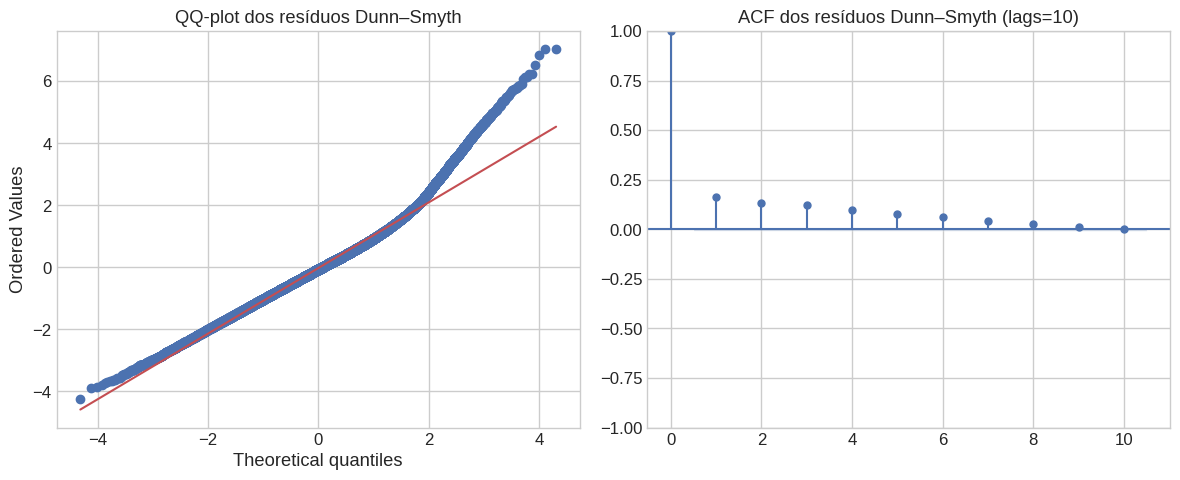

In [78]:
rqr = compute_rqr(modelo_poisson_stepwise, y, family='auto', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_poisson_stepwise),
    resid_pearson=modelo_poisson_stepwise.resid_pearson,
    df_resid=modelo_poisson_stepwise.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Modelo Poisson Stepwise",
    alpha=0.05,
    acf_lags=10
)

O gr√°fico Poisson com sele√ß√£o stepwise ainda exibe forte ‚Äúfunil‚Äù, indicando viola√ß√£o do pressuposto de equidispers√£o (vari√¢ncia dos res√≠duos cresce com Œº).
A suaviza√ß√£o segue descendente, sugerindo vi√©s: subestima para Œº baixos e superestima para Œº altos.
H√° muitos res√≠duos |r|>2, sobretudo em Œº<3, apontando heterogeneidade/zeros n√£o explicados.
O stepwise pode ter ajustado levemente a m√©dia (faixa ~4‚Äì7), mas n√£o corrige a sobredispers√£o.

In [79]:
overdisp(modelo_poisson_stepwise, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.008      
Dependent Variable:     ystar            AIC:                         616256.7712
Date:                   2025-09-08 02:39 BIC:                         616266.1355
No. Observations:       86185            Log-Likelihood:              -3.0813e+05
Df Model:               1                F-statistic:                 681.8      
Df Residuals:           86184            Prob (F-statistic):          1.06e-149  
R-squared (uncentered): 0.008            Scale:                       74.627     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.6038         0.1380       26.1106       0.0000       3.3333    

### Modelo de Regress√£o Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispers√£o

A **Regress√£o Binomial Negativa** √© uma extens√£o do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispers√£o** ‚Äî ou seja, a vari√¢ncia √© significativamente maior que a m√©dia. Esse modelo pertence √† fam√≠lia dos Modelos Lineares Generalizados (GLMs) e √© recomendado quando a suposi√ß√£o de equidispers√£o da Poisson n√£o √© atendida.

---

### Distribui√ß√£o Binomial Negativa

Na parametriza√ß√£o usada em modelagem de contagem, a vari√°vel aleat√≥ria $Y$ segue a distribui√ß√£o:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com m√©dia condicional $\mu$ e par√¢metro de dispers√£o $\theta$. A vari√¢ncia assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ √© a m√©dia esperada condicional de $Y$;
- $\theta > 0$ √© o par√¢metro de dispers√£o, tamb√©m chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a vari√¢ncia a $\mu$.

---

### Estrutura do Modelo

O objetivo √© expressar a m√©dia condicional $\mu_i$ da observa√ß√£o $i$ por meio de uma combina√ß√£o linear dos preditores $x_i$, garantindo positividade com a fun√ß√£o de liga√ß√£o logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a m√©dia esperada √© calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Vari√¢ncia Condicional

A diferen√ßa crucial em rela√ß√£o √† Poisson est√° no termo adicional da vari√¢ncia:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispers√£o observada nos dados, com vari√¢ncia aumentando mais rapidamente do que a m√©dia.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mant√™m a interpreta√ß√£o em termos de log‚Äëm√©dia:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na m√©dia esperada $\mu_i$ para cada aumento unit√°rio em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estima√ß√£o por M√°xima Verossimilhan√ßa

A estima√ß√£o envolve ajuste simult√¢neo de $\beta$ e $\theta$ por m√°xima verossimilhan√ßa. A presen√ßa do par√¢metro extra permite flexibilidade para se adequar a diferentes n√≠veis de dispers√£o nos dados.


#### Valida√ß√£o de presuposto

Os dados devem apresentar **sobredispers√£o**, ou seja, vari√¢ncia maior que a m√©dia.

In [80]:
pd.DataFrame({'M√©dia':[y.mean()],'Vari√¢ncia':[y.var()]})

M√©dia  Vari√¢ncia
0  0.149005   0.336727

#### Implementa√ß√£o dos modelos

##### Completo

In [81]:
modelo_binomial = smf.glm(formula=formula, data=X, family=sm.families.NegativeBinomial(), offset=np.log(X['duration_sec'])).fit()
modelo_binomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86185
Model:                            GLM   Df Residuals:                    86171
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32664.
Date:                Mon, 08 Sep 2025   Deviance:                       39981.
Time:                        02:39:58   Pearson chi2:                 1.30e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1206
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.8790      1.162     -3.337      0.001      -6.157      -1.601
total_amount               0.0002   8.81e-06     17.094      0.000       0.000       0.000
chip_ratio                 0.4152      0.029     14.373      0.000       0.359       0.472
avg_transactions_value    -0.0090      0.001     -6.292      0.000      -0.012      -0.006
geo_dispersion            -0.0023      0.007     -0.316      0.752      -0.016       0.012
avg_credit_score          -0.0084      0.002     -5.567      0.000      -0.011      -0.005
error_ratio                1.5878      0.830      1.914      0.056      -0.038       3.214
hour_sin                  -0.0231      0.019     -1.212      0.225      -0.061       0.014
hour_cos                  -1.1777      0.036    -32.333      0.000      -1.249      -1.106
day_sin                   -0.1527      0.014    -10.754      0.000      -0.181      -0.125
day_cos                    0.0276      0.014      1.935      0.053      -0.000       0.055
is_holiday                -0.0932      0.065     -1.436      0.151      -0.220       0.034
velocity_alert             0.4061      0.560      0.725      0.468      -0.692       1.504
cards_per_client          -1.1913      0.432     -2.756      0.006      -2.038      -0.344
==========================================================================================
"""

In [82]:
overdisp_plot_enhanced(modelo_binomial, 'Binomial Negativo - Completo')

KeyboardInterrupt: 

Family nb2



# Diagn√≥stico RQR ‚Äî Modelo Binomial

**N√≠vel de signific√¢ncia:** _Œ± = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| M√©dia = 0 | NOK |
| Vari√¢ncia = 1 | NOK |
| Independ√™ncia (Ljung‚ÄìBox) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padr√£o r¬≤~Œº) | NOK |
| Dispers√£o global (œÜÃÇ, Pearson) | NOK |


## 1) Normalidade
| Teste | Estat√≠stica | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro‚ÄìWilk | 0.9941 | 2.384e-46 | NOK |
| Jarque‚ÄìBera  | 2673.59 | 0.000e+00 | NOK |

## 2) Localiza√ß√£o e Escala
| Medida | Valor |
|---|---:|
| M√©dia (E[r]) | -0.026509 |
| Desvio-padr√£o (SD[r]) | 1.025101 |

| Teste | Hip√≥tese | Estat√≠stica | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (m√©dia=0) | H‚ÇÄ: E[r]=0 | -7.592 | 3.187e-14 | NOK |
| œá¬≤ (var=1) | H‚ÇÄ: Var[r]=1 | 90564.92 | 0.000e+00 | NOK |

## 3) Independ√™ncia (Ljung‚ÄìBox)
| Estat√≠stica Q | p-valor | Resultado |
|---:|---:|:--:|
| 5251.173 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padr√£o r¬≤ ~ Œº)
| Coef. de Œº | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.296158 | 7.710 | 1.254e-14 | NOK |

## 5) Dispers√£o Global (Escala)
| Estat√≠stica | df | œÜÃÇ | p(two-sided) | Resultado | Observa√ß√£o |
|---:|---:|---:|---:|:--:|---|
| 130475.91 | 86171 | 1.5142 | 0.000e+00 | NOK | Superdispers√£o (œÜÃÇ>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)‚âà4.55%, P(|r|>3)‚âà0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 4569 | 5.342e-25 | NOK |
| |r| > 3 | 631 | 4.056e-103 | NOK |

---
### Interpreta√ß√£o r√°pida
- Normalidade: NOK; M√©dia/Vari√¢ncia: NOK; Independ√™ncia: NOK; Caudas: NOK.
- Heterocedasticidade (r¬≤~Œº): NOK.
- Dispers√£o global: NOK (Superdispers√£o (œÜÃÇ>1)).


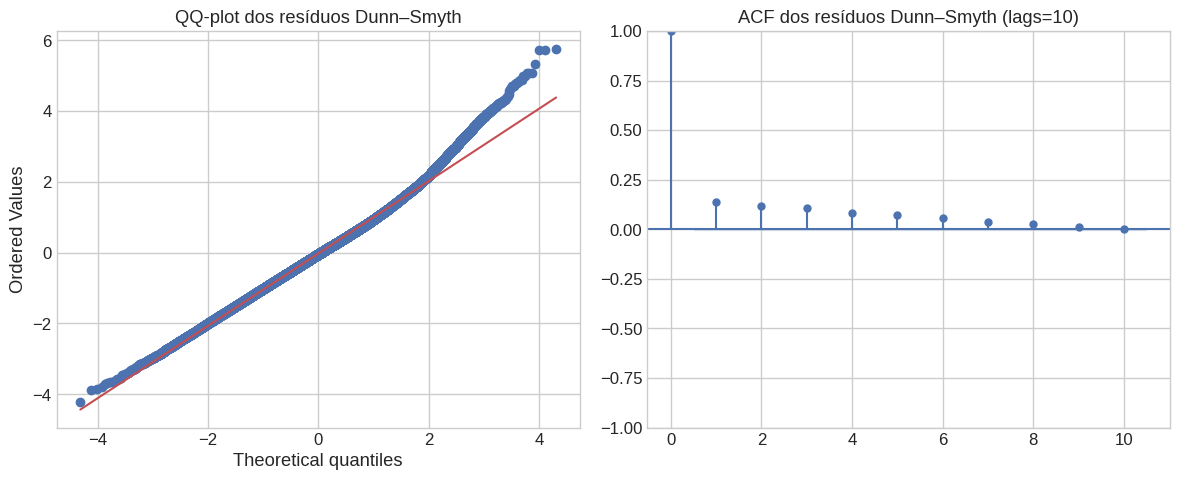

In [84]:
rqr = compute_rqr(modelo_binomial, y, family='nb2', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_binomial),
    resid_pearson=modelo_binomial.resid_pearson,
    df_resid=modelo_binomial.df_resid,
    lags=10,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Modelo Binomial",
    alpha=0.05,
    acf_lags=10
)

O gr√°fico sugere que, embora a Binomial Negativa atenue a sobredispers√£o, o padr√£o de ‚Äúfunil‚Äù persiste: a vari√¢ncia dos res√≠duos cresce quando a m√©dia prevista (Œº) √© baixa. A suaviza√ß√£o levemente descendente indica vi√©s (subestima em Œº pequenos e tende a superestimar em Œº maiores). A maioria dos pontos fica em ¬±2, mas h√° outliers positivos concentrados em Œº<4, sinalizando heterogeneidade/zeros n√£o explicados. Em suma, o ajuste √© melhor que o Poisson, por√©m ainda insuficiente nas baixas m√©dias.

##### Stepwise

In [85]:
modelo_binomial_stepwise = stepwise(modelo_binomial, pvalue_limit=0.05)
modelo_binomial_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('velocity_alert') + Q('cards_per_client')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('geo_dispersion')" with p-value equal to 0.7523313302107473 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('velocity_alert') + Q('cards_per_client')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('velocity_alert')" with p-value equal to 0.46726166604506436 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86185
Model:                            GLM   Df Residuals:                    86177
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32670.
Date:                Mon, 08 Sep 2025   Deviance:                       39992.
Time:                        02:40:40   Pearson chi2:                 1.30e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1205
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.0741      1.159      3.516      0.000       1.803       6.345
Q('total_amount')               0.0002   8.75e-06     17.358      0.000       0.000       0.000
Q('chip_ratio')                 0.4164      0.029     14.419      0.000       0.360       0.473
Q('avg_transactions_value')    -0.0081      0.001     -6.423      0.000      -0.011      -0.006
Q('avg_credit_score')          -0.0083      0.002     -5.508      0.000      -0.011      -0.005
Q('hour_cos')                  -1.1732      0.036    -32.326      0.000      -1.244      -1.102
Q('day_sin')                   -0.1533      0.014    -10.799      0.000      -0.181      -0.125
Q('cards_per_client')          -1.1203      0.429     -2.614      0.009      -1.960      -0.280
===============================================================================================
"""

In [86]:
overdisp_plot_enhanced(modelo_binomial_stepwise, 'Binomial Negativo - Stepwise')

KeyboardInterrupt: 

Family nb2



# Diagn√≥stico RQR ‚Äî Modelo Binomial Stepwise

**N√≠vel de signific√¢ncia:** _Œ± = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| M√©dia = 0 | NOK |
| Vari√¢ncia = 1 | NOK |
| Independ√™ncia (Ljung‚ÄìBox) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padr√£o r¬≤~Œº) | NOK |
| Dispers√£o global (œÜÃÇ, Pearson) | NOK |


## 1) Normalidade
| Teste | Estat√≠stica | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro‚ÄìWilk | 0.9941 | 2.797e-46 | NOK |
| Jarque‚ÄìBera  | 2657.83 | 0.000e+00 | NOK |

## 2) Localiza√ß√£o e Escala
| Medida | Valor |
|---|---:|
| M√©dia (E[r]) | -0.026532 |
| Desvio-padr√£o (SD[r]) | 1.025084 |

| Teste | Hip√≥tese | Estat√≠stica | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (m√©dia=0) | H‚ÇÄ: E[r]=0 | -7.598 | 3.026e-14 | NOK |
| œá¬≤ (var=1) | H‚ÇÄ: Var[r]=1 | 90561.90 | 0.000e+00 | NOK |

## 3) Independ√™ncia (Ljung‚ÄìBox)
| Estat√≠stica Q | p-valor | Resultado |
|---:|---:|:--:|
| 5257.080 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padr√£o r¬≤ ~ Œº)
| Coef. de Œº | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.294733 | 7.686 | 1.512e-14 | NOK |

## 5) Dispers√£o Global (Escala)
| Estat√≠stica | df | œÜÃÇ | p(two-sided) | Resultado | Observa√ß√£o |
|---:|---:|---:|---:|:--:|---|
| 129751.68 | 86177 | 1.5056 | 0.000e+00 | NOK | Superdispers√£o (œÜÃÇ>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)‚âà4.55%, P(|r|>3)‚âà0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 4571 | 3.798e-25 | NOK |
| |r| > 3 | 631 | 4.056e-103 | NOK |

---
### Interpreta√ß√£o r√°pida
- Normalidade: NOK; M√©dia/Vari√¢ncia: NOK; Independ√™ncia: NOK; Caudas: NOK.
- Heterocedasticidade (r¬≤~Œº): NOK.
- Dispers√£o global: NOK (Superdispers√£o (œÜÃÇ>1)).


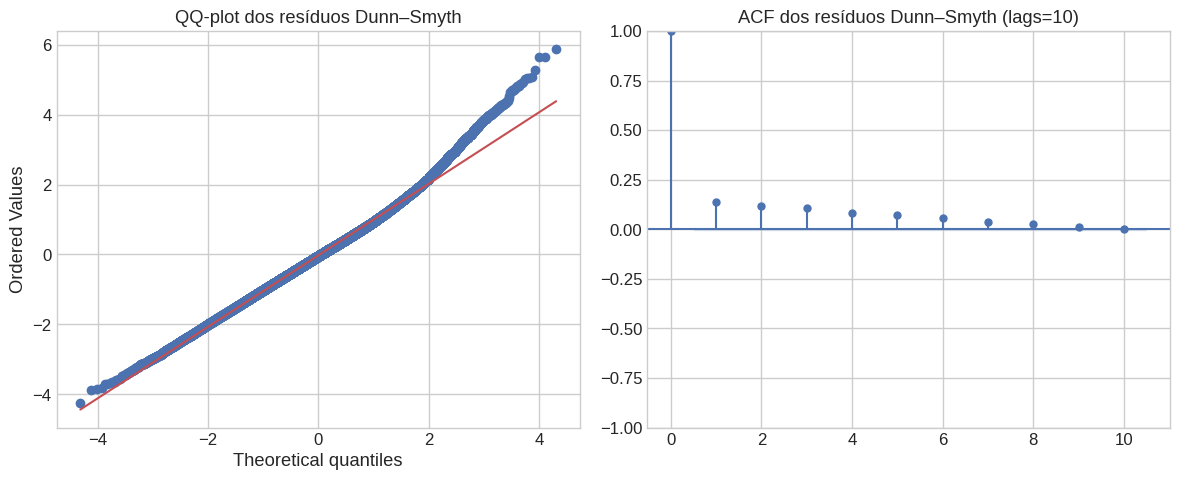

In [87]:
rqr = compute_rqr(modelo_binomial_stepwise, y, family='nb2', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_binomial_stepwise),
    resid_pearson=modelo_binomial_stepwise.resid_pearson,
    df_resid=modelo_binomial_stepwise.df_resid,
    lags=10,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Modelo Binomial Stepwise",
    alpha=0.05,
    acf_lags=10
)

O gr√°fico acima mostra que, mesmo com sele√ß√£o stepwise na Binomial Negativa, o modelo ainda tem dificuldade sobretudo para m√©dias previstas baixas (Œº).
Persiste um padr√£o de ‚Äúfunil‚Äù: a vari√¢ncia dos res√≠duos √© maior quando Œº √© pequeno e vai diminuindo com o aumento de Œº ‚Äî logo, a vari√¢ncia n√£o √© constante.
A suaviza√ß√£o levemente descendente indica vi√©s (subestima em Œº baixos e tende a superestimar em Œº mais altos).
Embora haja melhora em rela√ß√£o ao Poisson, ainda existe heterogeneidade/zeros n√£o explicados.

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** √© uma extens√£o do modelo de regress√£o de Poisson, utilizado quando os dados de contagem apresentam uma **frequ√™ncia excessiva de zeros**, superior √†quela esperada pela distribui√ß√£o de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flex√≠vel para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados s√£o gerados por **dois processos distintos**:

1. Um processo bin√°rio (discreto), que determina se a observa√ß√£o pertence √† **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribui√ß√£o de Poisson** com par√¢metro $\lambda_i$, para as observa√ß√µes que **n√£o pertencem** √† parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribui√ß√£o de probabilidade para $Y_i$ no modelo ZIP √© definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A m√©dia esperada da parte de contagem √© modelada com fun√ß√£o de liga√ß√£o logar√≠tmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo log√≠stico para infla√ß√£o de zeros

A probabilidade $\pi_i$ de uma observa√ß√£o pertencer √† parte inflacionada de zeros √© modelada via regress√£o log√≠stica:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ √© o vetor de preditores da parte Poisson (contagem);
- $z_i$ √© o vetor de preditores da parte bin√°ria (zero inflacionado), que pode coincidir ou n√£o com $x_i$;
- $\beta$ e $\gamma$ s√£o os vetores de coeficientes de cada parte do modelo.

---

### Interpreta√ß√£o dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logar√≠tmico** sobre a taxa de contagem, tal como na regress√£o de Poisson. A raz√£o de taxas √© dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da m√©dia esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de infla√ß√£o de zeros (log√≠stica):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observa√ß√£o perten√ßa √† parte estrutural de zeros. A exponencia√ß√£o dos coeficientes fornece a **raz√£o de chances** associada a cada preditor $z_{ij}$.

---

### Estima√ß√£o

A estima√ß√£o dos par√¢metros √© feita por **m√°xima verossimilhan√ßa**, utilizando uma fun√ß√£o composta que combina as verossimilhan√ßas das partes Poisson e log√≠stica. O processo √© iterativo e requer inicializa√ß√£o adequada dos par√¢metros.

---

### Utiliza√ß√£o

O modelo ZIP √© adequado para situa√ß√µes em que:

- A vari√°vel de contagem apresenta um **excesso de zeros** n√£o compat√≠vel com a distribui√ß√£o de Poisson;
- H√° **dois mecanismos distintos** para gera√ß√£o de zeros: um processo estrutural e outro aleat√≥rio (via Poisson);
- Deseja-se identificar **fatores associados √† presen√ßa estrutural de zeros**, al√©m da contagem em si.

---

### Considera√ß√µes

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispers√£o e verifica√ß√£o do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpreta√ß√£o, por√©m requer cuidado na separa√ß√£o adequada dos preditores entre as duas partes do modelo.

#### Valida√ß√£o de presuposto

Os dados devem apresentar **equidispers√£o**, ou seja, m√©dia igual a vari√¢ncia.

In [88]:
pd.DataFrame({'M√©dia':[y.mean()],'Vari√¢ncia':[y.var()]})

M√©dia  Vari√¢ncia
0  0.149005   0.336727

Existe uma diferen√ßa muito grande entre a m√©dia e a variancia referente a vari√°vel alvo, indicando poss√≠vel subdispers√£o nos dados.

##### Completo

In [89]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()
X1 = sm.add_constant(X1)

In [90]:
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, offset=np.log(X['duration_sec'])).fit(disp=False) # , method='lbfgs', cov_type='HC1'
modelo_zip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86185
Model:             ZeroInflatedPoisson   Df Residuals:                    86171
Method:                            MLE   Df Model:                           13
Date:                 Mon, 08 Sep 2025   Pseudo R-squ.:                -0.04451
Time:                         02:41:31   Log-Likelihood:                -35910.
converged:                       False   LL-Null:                       -34379.
Covariance Type:             nonrobust   LLR p-value:                     1.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
inflate_const                      0.0996        nan        nan        nan         nan         nan
inflate_total_amount              -0.0316        nan        nan        nan         nan         nan
inflate_chip_ratio                 0.1079        nan        nan        nan         nan         nan
inflate_avg_transactions_value    -0.0441        nan        nan        nan         nan         nan
inflate_geo_dispersion             0.0734        nan        nan        nan         nan         nan
inflate_avg_credit_score          -0.0735        nan        nan        nan         nan         nan
inflate_error_ratio                0.1000        nan        nan        nan         nan         nan
inflate_hour_sin                   0.0950        nan        nan        nan         nan         nan
inflate_hour_cos                   0.1044        nan        nan        nan         nan         nan
inflate_day_sin                    0.1071        nan        nan        nan         nan         nan
inflate_day_cos                    0.0942        nan        nan        nan         nan         nan
inflate_is_holiday                 0.0993        nan        nan        nan         nan         nan
inflate_velocity_alert             0.1000        nan        nan        nan         nan         nan
inflate_cards_per_client           0.0998        nan        nan        nan         nan         nan
const                            -11.3697        nan        nan        nan         nan         nan
total_amount                       0.0002        nan        nan        nan         nan         nan
chip_ratio                         0.4726        nan        nan        nan         nan         nan
avg_transactions_value            -0.0099        nan        nan        nan         nan         nan
geo_dispersion                    -0.0060        nan        nan        nan         nan         nan
avg_credit_score                   0.0005        nan        nan        nan         nan         nan
error_ratio                        0.0008        nan        nan        nan         nan         nan
hour_sin                          -0.0329        nan        nan        nan         nan         nan
hour_cos                          -1.1364        nan        nan        nan         nan         nan
day_sin                           -0.1407        nan        nan        nan         nan         nan
day_cos                            0.0330        nan        nan        nan         nan         nan
is_holiday                        -0.0653        nan        nan        nan         nan         nan
velocity_alert                     0.0016        nan        nan        nan         nan         nan
cards_per_client                   0.0070        nan        nan        nan         nan         nan
==================================================================================================
"""

In [91]:
overdisp_plot_enhanced(modelo_zip, 'Zip - Completo')

KeyboardInterrupt: 

Family zip



# Diagn√≥stico RQR ‚Äî Modelo Zip

**N√≠vel de signific√¢ncia:** _Œ± = 0.050_

## Resumo
| Checagem | Resultado |
|---|:--:|
| Normalidade (RQR ~ N(0,1)) | NOK |
| M√©dia = 0 | NOK |
| Vari√¢ncia = 1 | NOK |
| Independ√™ncia (Ljung‚ÄìBox) | NOK |
| Caudas (|r|>2, |r|>3) | NOK |
| Heterocedasticidade (padr√£o r¬≤~Œº) | NOK |
| Dispers√£o global (œÜÃÇ, Pearson) | NOK |


## 1) Normalidade
| Teste | Estat√≠stica | p-valor | Resultado |
|---|---:|---:|:--:|
| Shapiro‚ÄìWilk | 0.9799 | 4.012e-70 | NOK |
| Jarque‚ÄìBera  | 14156.87 | 0.000e+00 | NOK |

## 2) Localiza√ß√£o e Escala
| Medida | Valor |
|---|---:|
| M√©dia (E[r]) | -0.028074 |
| Desvio-padr√£o (SD[r]) | 1.067750 |

| Teste | Hip√≥tese | Estat√≠stica | p-valor | Resultado |
|---|---|---:|---:|:--:|
| t (m√©dia=0) | H‚ÇÄ: E[r]=0 | -7.719 | 1.186e-14 | NOK |
| œá¬≤ (var=1) | H‚ÇÄ: Var[r]=1 | 98257.52 | 0.000e+00 | NOK |

## 3) Independ√™ncia (Ljung‚ÄìBox)
| Estat√≠stica Q | p-valor | Resultado |
|---:|---:|:--:|
| 6997.627 | 0.000e+00 | NOK |

## 4) Heterocedasticidade (padr√£o r¬≤ ~ Œº)
| Coef. de Œº | t | p-valor | Resultado |
|---:|---:|---:|:--:|
| 0.972179 | 17.259 | 9.634e-67 | NOK |

## 5) Dispers√£o Global (Escala)
| Estat√≠stica | df | œÜÃÇ | p(two-sided) | Resultado | Observa√ß√£o |
|---:|---:|---:|---:|:--:|---|
| 153197.41 | 86171 | 1.7778 | 0.000e+00 | NOK | Superdispers√£o (œÜÃÇ>1) |

## 6) Caudas (|r|>2, |r|>3)
Esperado em N(0,1): P(|r|>2)‚âà4.55%, P(|r|>3)‚âà0.27%

| Regra | Contagem observada | p-valor binomial | Resultado |
|---|---:|---:|:--:|
| |r| > 2 | 5120 | 1.926e-78 | NOK |
| |r| > 3 | 1136 | 0.000e+00 | NOK |

---
### Interpreta√ß√£o r√°pida
- Normalidade: NOK; M√©dia/Vari√¢ncia: NOK; Independ√™ncia: NOK; Caudas: NOK.
- Heterocedasticidade (r¬≤~Œº): NOK.
- Dispers√£o global: NOK (Superdispers√£o (œÜÃÇ>1)).


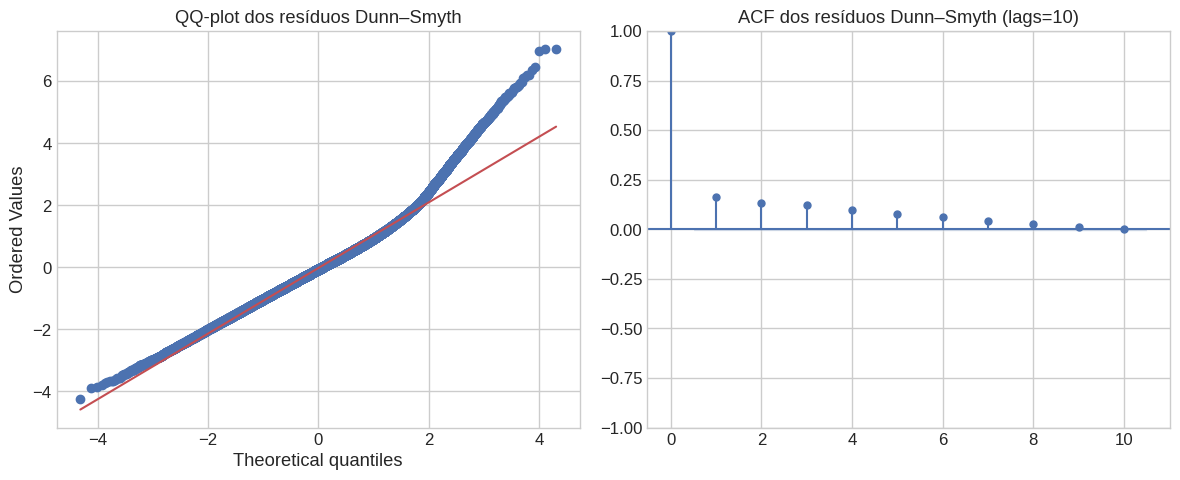

In [92]:
rqr = compute_rqr(modelo_zip, y, family='zip', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_zip),
    resid_pearson=modelo_zip.resid_pearson,
    df_resid=modelo_zip.df_resid,
    lags=10,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Modelo Zip",
    alpha=0.05,
    acf_lags=10
)

O modelo ZIP n√£o conseguiu convergir com todas as features da base.

In [93]:
vuong_test(modelo_poisson, modelo_zip)

Optimization terminated successfully.
         Current function value: 0.416344
         Iterations 17
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: 2.716
p-value: 0.003

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


Conforme teste de Vuong, √© poss√≠vel confirmar que os dados est√£o com infla√ß√£o de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em quest√£o da infla√ß√£o de zeros.

##### Stepwise

In [94]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()

In [ ]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='BIC',
    verbose=False,
    convergence_strictness='high',
    shuffle_features=True,
    shuffle_random_state=45,
    feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']]
)
random_selector_zip = RandomFeatureSelector(step_wise, max_features=0.85, random_state=45, feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']])
random_selector_zip.fit(X1, y, np.log(X['duration_sec']))

In [ ]:
plt.figure(figsize=(25, 20))

# Define o t√≠tulo com uma posi√ß√£o mais alta usando y
plt.suptitle('Distribui√ß√£o de Res√≠duos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espa√ßo entre os subplots e o t√≠tulo
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_zip.models)):
    plt.subplot(5, 2, i+1)
    overdisp_plot_enhanced(model, f'Zip Stepwise {i}')

plt.tight_layout()
plt.show()

In [ ]:
df_trained_zip = build_count_models_report(list(enumerate(map(lambda x: x.final_model_, random_selector_zip.models))), criterion='BIC')
df_trained_zip

In [ ]:
best_model_index_zip = df_trained_zip.loc[0, 'model_name']
best_model_index_zip

In [ ]:
modelo_zip_stepwise = random_selector_zip.models[best_model_index_zip].final_model_
modelo_zip_stepwise.summary()

In [ ]:
overdisp_plot_enhanced(modelo_zip_stepwise, 'Zip - Stepwise')

In [ ]:
rqr = compute_rqr(modelo_zip_stepwise, y, family='zip', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_zip_stepwise),
    resid_pearson=modelo_zip_stepwise.resid_pearson,
    df_resid=modelo_zip_stepwise.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Modelo Zip Stepwise",
    alpha=0.05,
    acf_lags=10
)

In [ ]:
vuong_test(modelo_poisson_stepwise, modelo_zip_stepwise)

O gr√°fico do ZIP‚ÄìStepwise ainda exibe ‚Äúfunil‚Äù: a vari√¢ncia dos res√≠duos √© maior para Œº baixos (‚âà2‚Äì4) e se estabiliza √† medida que Œº cresce, violando a equidispers√£o.
A suaviza√ß√£o levemente negativa sugere vi√©s (subestima em Œº pequenos).
A maioria dos pontos est√° em ¬±2, mas h√° outliers positivos concentrados em Œº<4, indicando heterogeneidade remanescente.
Conclus√£o: a infla√ß√£o de zeros reduziu o problema, por√©m n√£o o eliminou.

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispers√£o e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** √© uma extens√£o do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** n√£o compat√≠vel com a distribui√ß√£o de Poisson ou Binomial Negativa;
- Uma **sobredispers√£o** (vari√¢ncia maior que a m√©dia) nas contagens positivas.

Esse modelo permite que a vari√°vel resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo bin√°rio que determina a ocorr√™ncia de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribui√ß√£o Binomial Negativa** com m√©dia $\mu_i$ e par√¢metro de dispers√£o $\theta$, para as demais observa√ß√µes.

---

### Estrutura do Modelo

A fun√ß√£o de probabilidade do modelo ZINB √© definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ √© a m√©dia condicional do componente Binomial Negativo;
- $\theta > 0$ √© o par√¢metro de dispers√£o;
- $\pi_i$ √© a probabilidade de a observa√ß√£o pertencer √† **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo √© composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A m√©dia da distribui√ß√£o √© modelada com fun√ß√£o de liga√ß√£o logar√≠tmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de infla√ß√£o de zeros (Log√≠stica)

A probabilidade $\pi_i$ √© modelada com uma fun√ß√£o log√≠stica:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Vari√¢ncia

A vari√¢ncia condicional da parte de contagem segue a distribui√ß√£o Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispers√£o, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpreta√ß√£o dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ s√£o interpretados como efeitos logar√≠tmicos sobre a m√©dia $\mu_i$.
- A raz√£o de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem m√©dia de eventos para uma varia√ß√£o unit√°ria em $x_{ij}$.

#### Parte de Zeros (Log√≠stica)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observa√ß√£o pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **raz√£o de chances** associada a cada preditor $z_{ij}$.

---

### Estima√ß√£o

A estima√ß√£o dos par√¢metros $\beta$, $\gamma$ e $\theta$ √© feita por **m√°xima verossimilhan√ßa**, com otimiza√ß√£o conjunta das duas partes do modelo. A presen√ßa do par√¢metro de dispers√£o $\theta$ requer m√©todos num√©ricos robustos para converg√™ncia adequada.

---

### Utiliza√ß√£o

O modelo ZINB √© apropriado quando:

- A vari√°vel resposta apresenta **muitos zeros** e **sobredispers√£o** simultaneamente;
- H√° **dois mecanismos distintos** de gera√ß√£o de zeros: um estrutural (determin√≠stico) e outro probabil√≠stico (contagem);
- √â necess√°rio identificar fatores que influenciam tanto a **presen√ßa de zeros estruturais** quanto o **n√≠vel da contagem**.

---

### Considera√ß√µes Finais

O modelo ZINB √© uma alternativa robusta ao ZIP e √† Binomial Negativa padr√£o. Ele oferece maior capacidade de ajuste e interpreta√ß√£o quando a estrutura dos dados de contagem √© complexa, com varia√ß√µes acentuadas e presen√ßa de dois regimes distintos (zero e contagem positiva).


#### Valida√ß√£o de presuposto

Os dados devem apresentar **sobredispers√£o**, ou seja, vari√¢ncia √© maior que a m√©dia.

In [ ]:
pd.DataFrame({'M√©dia':[y.mean()],'Vari√¢ncia':[y.var()]})

##### Completo

In [ ]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy(deep=True)
X1 = sm.add_constant(X1)

In [ ]:
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, offset=np.log(X['duration_sec'])).fit(disp=False) # , method='lbfgs', cov_type='HC1'
modelo_zinb.summary()

In [ ]:
overdisp_plot_enhanced(modelo_zinb, 'Zip - Completo')

In [ ]:
rqr = compute_rqr(modelo_zinb, y, family='zinb', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_zinb),
    resid_pearson=modelo_zinb.resid_pearson,
    df_resid=modelo_zinb.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Modelo Zinb",
    alpha=0.05,
    acf_lags=10
)

O modelo ZINB n√£o conseguiu convergir com todas as features da base.

In [ ]:
vuong_test(modelo_binomial, modelo_zinb)

##### Stepwise

In [ ]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()

In [ ]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
    verbose=False,
    convergence_strictness='high',
    shuffle_features=True,
    shuffle_random_state=42,
    feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']]
)
random_selector_bneg = RandomFeatureSelector(step_wise, max_features=0.75, random_state=42, feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']])
random_selector_bneg.fit(X1, y, np.log(X['duration_sec']))

In [ ]:
plt.figure(figsize=(25, 20))

# Define o t√≠tulo com uma posi√ß√£o mais alta usando y
plt.suptitle('Distribui√ß√£o de Res√≠duos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espa√ßo entre os subplots e o t√≠tulo
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_bneg.models)):
    plt.subplot(5, 2, i + 1)
    overdisp_plot_enhanced(model, f'Zinb Stepwise {i}')

plt.tight_layout()
plt.show()

In [ ]:
df_trained_zinb = build_count_models_report(list(enumerate(map(lambda x: x.final_model_, random_selector_bneg.models))), criterion='BIC')
df_trained_zinb

In [ ]:
best_model_index_zinb = df_trained_zinb.loc[0, 'model_name']
best_model_index_zinb

In [ ]:
modelo_zinb_stepwise = random_selector_bneg.models[best_model_index_zinb].final_model_
modelo_zinb_stepwise.summary()

In [ ]:
overdisp_plot_enhanced(modelo_zinb_stepwise, 'ZIMB - Stepwise')

In [ ]:
rqr = compute_rqr(modelo_zinb_stepwise, y, family='zinb', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(modelo_zinb_stepwise),
    resid_pearson=modelo_zinb_stepwise.resid_pearson,
    df_resid=modelo_zinb_stepwise.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Modelo Zinb Stepwise ",
    alpha=0.05,
    acf_lags=10
)

O gr√°fico do ZIMB‚ÄìStepwise indica que a heterogeneidade foi bem capturada: o ‚Äúfunil‚Äù √© discreto e a vari√¢ncia dos res√≠duos se mant√©m mais est√°vel ao longo de Œº.
A suaviza√ß√£o fica pr√≥xima de zero, com leve tend√™ncia negativa (vi√©s pequeno em Œº baixos).
A maioria dos pontos est√° dentro de ¬±2 e os outliers s√£o poucos, concentrados em Œº‚âà2‚Äì3.
Em s√≠ntese, entre os modelos analisados este apresenta o melhor equil√≠brio para sobredispers√£o e excesso de zeros.

In [ ]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

## An√°lise dos modelos

Analise geral dos modelos a fim de compreender as metricas existentes entre os modelos

In [ ]:
titles = [
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Completo',
    'ZIP Stepwise',
    'ZINB Completo',
    'ZINB Stepwise'
]
models = [
    modelo_poisson,
    modelo_poisson_stepwise,
    modelo_binomial,
    modelo_binomial_stepwise,
    modelo_zip,
    modelo_zip_stepwise,
    modelo_zinb,
    modelo_zinb_stepwise
]

##### Analise dos modelos com base em seu LLF

In [ ]:
def print_compare_models():
  selected_models = []
  selected_names = []

  for model, name in zip(models, titles):
    if model.converged:
      selected_models.append(model)
      selected_names.append(name)

  compare_models({
    'modelo':selected_names,
    'loglik':[model.llf for model in selected_models]
  })

print_compare_models()

Analisando diretamente a m√©trica do LLF podemos ver claramente que o modelo ZINB obeteve um melhor resultado, sugerindo que esse possa ser o melho modelo, no entanto ser√° necess√°rio validar outros aspectos a fim de garantir que esse modelo realmente possa ser utilizado.

### Dispers√£o dos residuos

In [ ]:
plt.figure(figsize=(25, 20))

# Define o t√≠tulo com uma posi√ß√£o mais alta usando y
plt.suptitle('Distribui√ß√£o de Res√≠duos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espa√ßo entre os subplots e o t√≠tulo
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 2, i + 1)
    overdisp_plot_enhanced(model, titles[i])

plt.tight_layout()
plt.show()

* Poisson (completo/stepwise): forte ‚Äúfunil‚Äù e muitos |r|>2 em Œº baixos ‚áí pressuposto de equidispers√£o violado e vi√©s (tend√™ncia descendente).

* Binomial Negativa (completo/stepwise): reduz bem a heteroscedasticidade; ainda h√° leve vi√©s negativo e outliers concentrados em Œº<4.

* ZIP‚ÄìStepwise: melhora a regi√£o de Œº baixos, mas permanece funil moderado e alguns outliers positivos ‚áí excesso de zeros parcialmente capturado.

* ZIMB‚ÄìStepwise: dispers√£o mais homog√™nea, suaviza√ß√£o pr√≥xima de 0 e poucos outliers; melhor equil√≠brio entre sobredispers√£o e zeros.

<!-- ## Crit√©rio de Sele√ß√£o de Modelos

Dado um conjunto de modelos $\{m=1,\dots,M\}$, definimos um
**score composto** $S_m \in [0,100]$ e selecionamos

$$
  m^\star = \arg\max_{m} S_m .
$$

---

### 1) Normaliza√ß√£o do crit√©rio principal $\kappa_m \in \{\text{AIC},\text{BIC},\text{LLF}\}$

Se $\kappa$ for **AIC/BIC** (quanto menor, melhor):

$$
  \widehat C_m = \frac{\max_j \kappa_j - \kappa_m}{\max_j \kappa_j - \min_j \kappa_j}
  \in [0,1].
$$

Se $\kappa$ for **LLF** (quanto maior, melhor):

$$
  \widehat C_m = \frac{\kappa_m - \min_j \kappa_j}{\max_j \kappa_j - \min_j \kappa_j}
  \in [0,1].
$$

---

### 2) Score de Dispers√£o Global (Pearson)

Seja

$$
  \phi_m = \frac{\sum_i (r^{(P)}_{im})^2}{\text{df}_{\text{resid},m}} .
$$

Penalizamos desvios de $\phi=1$:

$$
  D_m = \exp\!\left(-\lambda \, \big|\log \phi_m\big|\right), \quad D_m \in (0,1].
$$

---

### 3) Score de Diagn√≥stico RQR

Considere os p-valores

$$
  \mathcal P_m = \{p^{SW}_m, \; p^{JB}_m, \; p^{LB}_m, \; p^{(2)}_m, \; p^{(3)}_m\},
$$

para Shapiro‚ÄìWilk, Jarque‚ÄìBera, Ljung‚ÄìBox e propor√ß√µes de cauda
$P(|r|>2)$ e $P(|r|>3)$ dos res√≠duos Dunn‚ÄìSmyth.

Defina

$$
  g(p;\alpha)=\min\!\left(1,\;\frac{p}{\alpha}\right),
$$

$$
  R_m = \frac{1}{5}\sum_{p\in \mathcal P_m} g(p;\alpha) \in [0,1].
$$

---

### 4) Prefer√™ncias (Converg√™ncia e Faixa de Dispers√£o)

$$
  M_m = \mathbf{1}\{\text{modelo convergiu}\}\cdot \mathbf{1}\{L \le \phi_m \le U\},
$$

$$
  B_m = 1 + \beta\, M_m.
$$

---

### 5) Score Final

Com pesos $w_C,w_D,w_R,w_P \ge 0$ tais que $w_C+w_D+w_R+w_P=1$:

$$
  S_m = 100 \times B_m \times
  \Big( w_C\,\widehat C_m + w_D\,D_m + w_R\,R_m + w_P\,P_m \Big),
$$

onde $P_m = \mathbf{1}\{\text{modelo convergiu}\}$ (b√¥nus adicional, opcional).

---

### 6) Sele√ß√£o

O melhor modelo √©

$$
  m^\star = \arg\max_m S_m .
$$

---

### Exemplo de Pesos

$$
  (w_C,w_D,w_R,w_P)=(0.50,\,0.20,\,0.25,\,0.05), \quad
  \lambda=1, \; \beta=0.05, \; [L,U]=[0.8,1.5], \; \alpha=0.05.
$$ -->


In [ ]:
df_metrics = build_count_models_report(list(zip(titles, models)), criterion='BIC').query('Converged == True')
df_metrics

### Compara√ß√£o de metrics (LLF, AIC, BIC e R2)

In [ ]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo', fontsize=16)

highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('M√©trica AIC (Menor √© Melhor)')
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['model_name']
palette_aic = [highlight_color if m == best_model_aic else default_color for m in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('M√©trica BIC (Menor √© Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['model_name']
palette_bic = [highlight_color if m == best_model_bic else default_color for m in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('M√©trica LLF (Maior √© Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['model_name']
palette_llf = [highlight_color if m == best_model_llf else default_color for m in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhan√ßa)')
plt.ylabel('Modelos')

# --- Subplot 4: Score Composto ---
plt.subplot(2, 2, 4)
plt.title('Score Composto (Maior √© Melhor)')
df_sorted = df_metrics.sort_values(by='Score', ascending=False)
best_model_score = df_metrics.loc[df_metrics['Score'].idxmax()]['model_name']
palette_score = [highlight_color if m == best_model_score else default_color for m in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='Score', palette=palette_score)
plt.xlabel('Score')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


O painel acima mostra que um √∫nico crit√©rio n√£o resolve o problema: AIC e LLF apontam o ZINB Stepwise como melhor ajuste (captura sobredispers√£o + zeros), enquanto o BIC ‚Äî mais parcimonioso ‚Äî favorece o NB Stepwise.
O Pseudo-R¬≤ destaca os modelos Poisson, mas essa m√©trica √© pouco compar√°vel entre fam√≠lias e tende a supervalorizar ajustes que violam a equidispers√£o observada nos res√≠duos.
Assim, para um ajuste realista dos dados, o ZINB Stepwise √© o mais aderente; se a prioridade for simplicidade, o NB Stepwise √© alternativa s√≥lida.


In [ ]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

Aplicando o teste Voung se valida que o modelo Zinb se adequa melhor ao problema uma vez que a hipotese nula foi refutada.

## Sele√ß√£o do melhor modelo

In [ ]:
best_model = df_metrics.loc[0, 'model_name']
best_model

In [ ]:
indice = titles.index(best_model)
best_model = models[indice]
best_model.summary2()

<!-- #### Tabela de features -->

In [ ]:
# df_exog_inf = pd.DataFrame()
# if hasattr(best_model.model, 'exog_infl'):
#   df_exog_inf = best_model.model.exog_infl
#   feature_exog_inf = [column for column in best_model.model.exog_names if ('inflate_' in column)]
#   df_exog_inf = pd.DataFrame(df_exog_inf, columns=feature_exog_inf)

In [ ]:
# df_exog = best_model.model.exog
# features_exog = [column for column in best_model.model.exog_names if not ('inflate_' in column or 'alpha' in column)]
# df_exog = pd.DataFrame(df_exog, columns=features_exog)

In [ ]:
# df_features = pd.concat([df_exog, df_exog_inf], axis=1)
# df_features['residuos'] = best_model.resid_pearson.values if hasattr(best_model.resid_pearson, 'values') else best_model.resid_pearson
# df_features['fitted'] = best_model.fittedvalues.values
# df_features['target'] = y.values
# df_features

#### An√°lise das estatisticas computadas durante o treinamento

In [ ]:
rqr = compute_rqr(best_model, y, family='zinb', random_state=123)
rep = diagnostico_rqr(
    rqr,
    mu_pred=_fitted_mean(best_model),
    resid_pearson=best_model.resid_pearson,
    df_resid=best_model.df_resid,
    lags=20,
    alpha=0.05
)

plot_report(
    report=rep,
    rqr=rqr,
    title="Diagn√≥stico RQR ‚Äî Melhor Modelo - Zinb Stepwise",
    alpha=0.05,
    acf_lags=10
)

#### Histograma dos residuos de Dunn Smyth

In [ ]:
best_model_residuos = compute_rqr(best_model, y)

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(best_model_residuos, kde=True, color='skyblue')
plt.title("Histograma e KDE dos Res√≠duos de Dunn Smyth")
plt.xlabel("Res√≠duos de Dunn Smyth")
plt.ylabel("Frequ√™ncia")
plt.tight_layout()
plt.show()

#### Visualiza√ß√£o da auto-correla√ß√£o dos residuos de Dunn-Smyth

In [ ]:
plot_acf_pacf(best_model_residuos, 10)

## Ajuste no modelo para remo√ß√£o de auto-correla√ß√£o

In [ ]:
from statsmodels.tools import add_constant
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
X_leg = X[[param for param in best_model.params.index if ((not 'inflate_' in param) & (not 'const' in param) & (not 'alpha' in param))]]
X_inflate_leg = X[[str(param).replace('inflate_', '') for param in best_model.params.index if ('inflate_' in param) and (not 'const' in param) and (not 'alpha' in param)]]
offset_leg = np.log(X['duration_sec'])

In [ ]:
def fit_zinb(y, X, X_infl, offset=None, maxiter=200, start_params=None):
    model = ZeroInflatedNegativeBinomialP(
        endog=y,
        exog=add_constant(X, has_constant='add'),
        exog_infl=add_constant(X_infl, has_constant='add'),
        inflation='logit',
        offset=offset  # offset apenas no componente de contagem
    )
    res = model.fit(method='bfgs', maxiter=maxiter, disp=0, start_params=start_params)
    return res

In [ ]:
def ljungbox_pvalues(residuals, lags=10):
    lb = acorr_ljungbox(residuals, lags=lags, return_df=True)
    return lb['lb_pvalue']

In [ ]:
def arma_correction_series(resid, order=(1,0,1), seasonal_order=(0,0,0,0)):
    """
    Ajusta ARMA (via SARIMAX com d=0) nos res√≠duos e retorna o fitted in-sample
    como Series, preservando o √≠ndice temporal.
    """
    resid = pd.Series(resid)  # garante Series com √≠ndice
    mod = SARIMAX(
        resid, order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    )
    res = mod.fit(disp=False)
    fitted = pd.Series(res.fittedvalues, index=resid.index, name='arma_fit')
    return res, fitted

In [ ]:
def build_augmented_design(X, X_infl, corr_fit, *, name='arCorr', lags=(1,), add_to=("X","Z")):
    """
    Cria lags do componente ARMA e adiciona em X e/ou X_infl.
    Use add_to=("X",) para adicionar apenas na contagem e reduzir n¬∫ de par√¢metros.
    """
    X = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
    X_infl = X_infl.copy() if isinstance(X_infl, pd.DataFrame) else pd.DataFrame(X_infl)

    base_index = X.index if isinstance(X, pd.DataFrame) else corr_fit.index
    X.index = base_index
    X_infl.index = base_index

    aux = pd.DataFrame(index=base_index)
    aux[name] = pd.Series(corr_fit).reindex(base_index)

    for L in lags:
        aux[f'{name}_lag{L}'] = aux[name].shift(L)

    lag_cols = [c for c in aux.columns if c.startswith(f'{name}_lag')]

    X_aug = X.copy()
    Z_aug = X_infl.copy()
    if "X" in add_to:
        X_aug = pd.concat([X_aug, aux[lag_cols]], axis=1)
    if "Z" in add_to:
        Z_aug = pd.concat([Z_aug, aux[lag_cols]], axis=1)

    # df com as lags para controlar dropna posterior
    df_lags = aux[lag_cols]
    return df_lags, X_aug, Z_aug

In [ ]:
def zinb_with_ar_correction(y, X, X_infl, offset=None,
                            ar_order=(1,0,1), lags_to_use=(1,),
                            add_to=("X","Z"),
                            max_rounds=3, alpha=0.05, lb_lags=10):
    """
    Loop:
      1) Ajusta ZINB (X, X_infl, offset)
      2) Testa Ljung-Box nos res√≠duos de Pearson
      3) Se falhar: ajusta ARMA nos res√≠duos, cria lags -> concatena em X e X_infl
      4) Reajusta ZINB com as matrizes augmentadas (e offset realinhado)
      5) Repete at√© parar de rejeitar (ou atingir max_rounds)
    """
    # C√≥pias de trabalho
    _y = y.copy()
    _X = X.copy()
    _X_infl = X_infl.copy()
    _offset = offset.copy() if offset is not None else None

    if _offset is not None:
      _offset = _offset.replace([np.inf, -np.inf], np.nan)

    # 0) Ajuste inicial (ZINB puro)
    res = fit_zinb(_y, _X, _X_infl, _offset)
    best = res

    for rnd in range(1, max_rounds + 1):
        resid = pd.Series(res.resid_pearson, index=_y.index)

        # 1) Ljung-Box
        pvals = ljungbox_pvalues(resid.dropna(), lags=lb_lags)
        if (pvals > alpha).all():
            # Sem autocorrela√ß√£o remanescente
            break

        # 2) ARMA nos res√≠duos
        arma_res, arma_fit = arma_correction_series(resid.fillna(0.0), order=ar_order)

        # 3) Construir regressoras augmentadas com lags (usa argumentos passados!)
        df_lags, X_aug, X_infl_aug = build_augmented_design(_X, _X_infl, arma_fit, name='arCorr', lags=lags_to_use, add_to=add_to)

        # 4) Alinhamento/limpeza (drop de NaNs gerados pelas lags)
        valid_idx = X_aug.dropna().index.intersection(X_infl_aug.dropna().index).intersection(df_lags.dropna().index)
        y_use = _y.loc[valid_idx]
        X_use = X_aug.loc[valid_idx]
        X_infl_use = X_infl_aug.loc[valid_idx]
        offset_use = _offset.loc[valid_idx] if _offset is not None else None

        # 5) Reajuste com as MATRIZES AUGMENTADAS
        res = fit_zinb(y_use, X_use, X_infl_use, offset_use)
        best = res

        # 6) Atualiza bases para pr√≥xima itera√ß√£o (mantendo as lags atuais como parte do design)
        _y, _offset = y_use, offset_use

    return best, _y

In [ ]:
model_leg, _y = zinb_with_ar_correction(y, X_leg, X_inflate_leg, offset_leg, ar_order=(1,0,1), lags_to_use=(1,2,3,), max_rounds=5, add_to=('X' ))
print(model_leg.summary())

In [ ]:
_y.shape

In [ ]:
model_leg_residuos = compute_rqr(model_leg, _y)

In [ ]:
print(acorr_ljungbox(model_leg_residuos, lags=10, return_df=True))

In [ ]:
residuos_ljung_box_autocorrelacao_test(model_leg_residuos, 10)

In [ ]:
plot_acf_pacf(model_leg_residuos, 10)

## Infer√™ncia Estatistica

Identificar as features que possam melhor identificar as fraudes atrav√©s de um processo de infer√™ncia estat√≠stica.

In [ ]:
best_model.summary()

In [ ]:
# Calculando a estat√≠stica Qui-quadrado de Pearson
chi2_stat = np.sum(best_model.resid_pearson**2)
dof = best_model.df_resid # Graus de liberdade (observa√ß√µes - n√∫mero de par√¢metros)
p_value_gof = stats.chi2.sf(chi2_stat, dof)

print("\n--- Diagn√≥stico do Modelo ---")
print(f"Estat√≠stica Qui-quadrado de Pearson: {chi2_stat:.2f}")
print(f"Graus de Liberdade: {dof}")
print(f"P-valor do Teste de Goodness-of-Fit: {p_value_gof:.4f}")

if p_value_gof > 0.05:
    print("Conclus√£o: N√£o h√° evid√™ncia para rejeitar a hip√≥tese nula. O modelo parece se ajustar bem aos dados (p > 0.05).")
else:
    print("Conclus√£o: O p-valor √© baixo (p <= 0.05), o que sugere um poss√≠vel mau ajuste do modelo.")


#### Tabela de componentes

In [ ]:
df_inference = pd.concat([best_model.params.copy(), best_model.conf_int()], axis=1)
df_inference.index = [str(index).replace("Q('", '').replace("')", '') for index in df_inference.index]
df_inference.columns = ['params', '2.5%', '97.5%']
df_inference['IRR/Odds Ratio'] = np.exp(df_inference['params'])
df_inference

#### An√°lise do componente log√≠stico (infla√ß√£o de zeros estruturais)

##### Probabilidade m√©dia geral de ser um zero estrutural

In [ ]:
pi_hat = _predict_prob_zero(best_model)
np.mean(pi_hat)

O modelo estima que 54.95% das transa√ß√µes s√£o zero estruturais, ou seja, s√£o grupos de transa√ß√µes que s√£o fundamentalmente diferentes, o risco de fraudes neles √©, para todos os efeitos, nulos.

##### Componente de Infla√ß√£o de Zeros M√©dio

In [ ]:
inflate_components = [str(component).replace('inflate_', '') for component in df_inference.index if ('inflate_' in component and not 'const' in component)]
inflate_components

In [ ]:
inflate_sample_means = X[inflate_components].mean(axis=0).to_frame().T.assign(const=1)
inflate_sample_means.columns = ['inflate_' + column for column in inflate_sample_means.columns]
inflate_sample_means = inflate_sample_means[[column for column in best_model.model.exog_names if 'inflate_' in column]]
inflate_sample_means

##### Experimento Ceteris Paribus para componente de Infla√ß√£o

In [ ]:
var_types = {
    "chip_ratio": "proportion",
    "merchant_entropy": "entropy",
    "cards_per_client": "count",
    "avg_credit_score": "score",
    "avg_transactions_value": "currency",
}

In [ ]:
inflate_sample_deltas = suggest_natural_deltas(X, var_types)
inflate_sample_deltas

In [ ]:
inflate_sample_pi_base = best_model.predict(exog_infl=inflate_sample_means, which='prob-zero')
inflate_sample_pi_base

In [ ]:
inflate_sample_pi_base.mean()

O registro m√©dio apresenta praticamente a mesma m√©dia geral do modelo, 55%.

In [ ]:
rows = []
for row in inflate_sample_deltas.to_dict(orient='records'):
    pi_after = simulate_delta_inflate(best_model, inflate_sample_means, inflate_sample_means.columns.to_list(), 'inflate_' + row['component'], row['delta']).mean()

    pi_base = inflate_sample_pi_base.mean()
    odds_base = _prob_to_odds(pi_base)
    odds_after = _prob_to_odds(pi_after)

    rows.append({
        "Vari√°vel (inflate)": row['component'],
        "Delta aplicado": row['delta'],
        "Prob. base (registro m√©dio)": pi_base,
        "Prob. ap√≥s delta": pi_after,
        "Diferen√ßa (p.p.)": (pi_after - pi_base) * 100,
        "Odds base": odds_base,
        "Odds ap√≥s delta": odds_after,
        "Fator nas chances (emp√≠rico)": odds_after/odds_base
    })

In [ ]:
inflate_components_simulate = pd.DataFrame(rows)
Markdown(build_inflate_summary_table(inflate_components_simulate, inflate_sample_deltas, inflate_sample_pi_base.mean()))

#### An√°lise do componente de contagem

##### Componente de Contagem M√©dio

In [ ]:
counting_components = [str(component) for component in df_inference.index if ('inflate_' not in component and not 'const' in component and not 'alpha' in component)]
counting_components

In [ ]:
counting_components_means = X[counting_components].median(axis=0).to_frame().T.assign(const=1)
counting_components_means = counting_components_means[[column for column in best_model.model.exog_names if ('inflate_' not in column and 'alpha' not in column)]]
counting_components_means

In [ ]:
S = X['hour_sin'].mean()
C = X['hour_cos'].mean()
mu = np.arctan2(S, C)
mu

In [ ]:
h, m, s = angle_to_hour(mu)
print(f"{h:02d}:{m:02d}:{s:02d}")

In [ ]:
counting_components_means['hour_sin'] = np.sin(mu)
counting_components_means['hour_cos'] = np.cos(mu)
counting_components_means_map = counting_components_means.to_dict(orient='records')[0]
counting_components_means_map

##### An√°lise do padr√£o de hora

In [ ]:
df_hours = pd.DataFrame({'hour': np.arange(24)})
df_hours['hour_sin'] = np.sin(2 * np.pi * df_hours['hour'] / 24)
df_hours['hour_cos'] = np.cos(2 * np.pi * df_hours['hour'] / 24)
df_hours

In [ ]:
df_inference_params = df_inference.loc[[index for index in df_inference.index.to_list() if ('inflate_' not in index and index != 'alpha')], 'params']
df_inference_params

In [ ]:
offset_log = np.log(X['duration_sec'].values[0])
offset_log

In [ ]:
log_rate = df_inference_params['const']
log_rate += df_inference_params['hour_sin'] * df_hours['hour_sin']
log_rate += df_inference_params['hour_cos'] * df_hours['hour_cos']
log_rate += df_inference_params['cards_per_client'] * counting_components_means_map['cards_per_client']
log_rate += df_inference_params['avg_credit_score'] * counting_components_means_map['avg_credit_score']

In [ ]:
df_hours['expected_rate'] = np.exp(log_rate + offset_log)

In [ ]:
plot_hours(df_hours)

In [ ]:
# picos/vales usando a s√©rie que j√° cont√©m exp(log_rate + offset_log)
peak_hour_row   = df_hours.loc[df_hours['expected_rate'].idxmax()]
trough_hour_row = df_hours.loc[df_hours['expected_rate'].idxmin()]

peak_hour    = int(peak_hour_row['hour'])
trough_hour  = int(trough_hour_row['hour'])
peak_count   = float(peak_hour_row['expected_rate'])    # = Œº(h_pico)
trough_count = float(trough_hour_row['expected_rate'])  # = Œº(h_vale)

percentage_diff = ((peak_count - trough_count) / trough_count) * 100

exposure = float(np.exp(offset_log))  # exposi√ß√£o correspondente ao offset em log

print("\n--- An√°lise da Curva C√≠clica ---")
print(
    "O modelo aprende a TAXA por unidade de exposi√ß√£o Œª(h). "
    f"Para obter a contagem esperada na janela, somamos o offset em log (={offset_log:.6f}) "
    f"ao preditor linear ‚Äî equivalente a multiplicar a taxa pela exposi√ß√£o e^(offset)= {exposure:,.0f}."
)
print("\nResultados:")
print(f"  -> Hor√°rio de Pico de Atividade: {peak_hour:02d}:00h (Contagem esperada na janela: {peak_count:.5f})")
print(f"  -> Hor√°rio de Vale de Atividade: {trough_hour:02d}:00h (Contagem esperada na janela: {trough_count:.5f})")
print("\nConclus√£o da Infer√™ncia:")
print(
    f"  A contagem esperada no hor√°rio de pico ({peak_hour:02d}:00h) √© "
    f"{percentage_diff:.1f}% maior do que no hor√°rio de vale ({trough_hour:02d}:00h)."
)
print("  (Essa diferen√ßa percentual independe do offset quando a exposi√ß√£o √© constante ao longo das horas.)")


##### Experimento Ceteris Paribus para componente de Contagem

In [ ]:
var_types_count = {
    "cards_per_client": "count",
    "avg_credit_score": "score",
}

In [ ]:
count_sample_delta_types = suggest_natural_deltas(
    X[list(var_types_count.keys())],
    var_types=var_types_count,
    center="mean"
)

count_sample_delta_hours = cyclic_delta_from_sincos(X)

count_sample_deltas = pd.concat(
    [count_sample_delta_types, pd.DataFrame([count_sample_delta_hours])],
    ignore_index=True
)
count_sample_deltas

In [ ]:
inflate_sample_means

In [ ]:
counting_components_means

In [ ]:
pi0, mu0, EY0 = predict_components(best_model, counting_components_means.copy(), inflate_sample_means.copy(), offset_log)

In [ ]:
counting_components_means.columns.to_list()

In [ ]:
rows = []
count_names = counting_components_means.columns.to_list()
for r in count_sample_deltas.to_dict(orient='records'):
    component, delta, comp_type = r['component'], float(r['delta']), r['type']
    if delta <= 0:
        continue

    # aplica o Œî (hora = rota√ß√£o; demais = soma escalar)
    if comp_type == "cyclic":
        rc1 = rotate_hour_features(counting_components_means.copy(), dhours=delta)
    else:
        rc1 = counting_components_means.copy()
        rc1.loc[:, component] = float(rc1[component]) + delta

    # guard-rails: const + ordem
    assert set(rc1.columns) >= set(count_names)
    rc1 = rc1[count_names]

    # previs√µes
    pi1, mu1, EY1 = predict_components(best_model, rc1, inflate_sample_means, offset_log)

    rows.append({
        "Vari√°vel (contagem)": ("hour" if comp_type == "cyclic" else component),
        "Delta aplicado": (f"{delta} h" if comp_type == "cyclic" else delta),
        "mu cond. base": mu0,
        "mu cond. ap√≥s Œî": mu1,
        "IRR emp√≠rico (mu1/mu0)": mu1/mu0,
        "IRR te√≥rico (exp(Œ≤¬∑Œîx))": irr_teorico_count(best_model, counting_components_means[count_names], rc1, count_names),
        "E[Y] base": EY0,
        "E[Y] ap√≥s Œî": EY1,
        "Œî E[Y] abs.": EY1 - EY0,
        "Œî E[Y] rel. (%)": (EY1/EY0 - 1)*100 if EY0>0 else np.nan
    })

counting_components_simulate = pd.DataFrame(rows)
counting_components_simulate

In [ ]:
Markdown(build_counting_summary_table(counting_components_simulate, count_sample_deltas, inflate_sample_pi_base.mean()))

## Conclus√£o

Pode-se concluir que, as features:

* `avg_credit_score` e `chip_ratio` quando aumentadas em +1 unidade reduzem as changes de uma janela de transa√ß√µes permanecerem como zero estruturais.
* `cards_per_client` e `avg_credit_score` quando auementadas em +1 unidade aumentam as taxas/contagens esperadas de eventos.
* `hour` possui maior horario de pico as 02:00 e menor as 14:00.
